In [16]:
import geopandas as gpd
import pandas as pd
import shutil
import matplotlib.pyplot as plt
# import seaborn as sns
import copy
import numpy as np
import shapely
from shapely.geometry import Point
import string
import os, sys, getpass
import io, uuid
import time

# Set up

### Common folders and variables

In [2]:
table_source = "C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet/TABLES"
attributes_source = "C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet"
stad_source = "C:/Users/akm03/Alaa/NERGYHUB/data/vasteras_stad/processed_data"


min_height = 2.4
min_volume = 3.2

# common names of files that will be used
raw_buildings = 'buildings_filtered'
final_buildings = "buildings"

raw_properties = "ay_riks_updated"
final_properties = 'properties'

raw_addresses = 'ADRPL_90A.xlsx'
final_addresses = 'addresses'

height_on_perimeter = 'dtm_values_at_perimeters.csv'


#final_file = 'joined_buildings_addresses_properties'

### open attribute table that will be use to specify columns to keep and their new names
data_list = os.path.join(attributes_source, "data_list.xlsx")

attributes_sheet_name = "Attributes_description"
attributes = pd.read_excel(data_list, attributes_sheet_name)

codes_sheet_name = "Codes"
codes = pd.read_excel(data_list, codes_sheet_name)

options_sheet_name = "Attributes_options"
options = pd.read_excel(data_list, options_sheet_name)

In [3]:
city_name = 'Vasteras'

input_dtm = 'C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet/{}/DTM/at_perimeters'.format(city_name)
input_dsm = 'C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet/{}/DSM/at_perimeters'.format(city_name)
input_dsm_pixel = 'C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet/{}/DSM/at_buildings'.format(city_name)

destination = "C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet/{0}/processed_data".format(city_name)
source = "C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet/{0}/Fastighetskartan".format(city_name)

# extent = gpd.read_file(os.path.join(destination, 'properties_extent.shp'))

In [4]:
def check_duplication(df, column = None, drop = False, **kwargs):    
    if column and column not in df.columns:
        print('Column {} does not exist in dataframe'.format(column))
    else:
        if column is None:
            column = list(df.columns)   
        df_duplicated = df.loc[df[column].duplicated(), :]
        if len(df_duplicated)>0:    
            print(len(df_duplicated[column].values.tolist()))
            #print(df_duplicated[column].values.tolist())
            if drop:
                #print(kwargs)
                df.drop_duplicates(subset = column, **kwargs)
                return df
        else:
            print("No duplications")

### Convert addresses from tables to a shapefile (already run)

In [4]:
# # set the table source as the directory
# os.chdir(table_source)
# sheetname = 'Data'
# # read file
# addresses_table = pd.read_excel(raw_addresses, sheet_name = sheetname)
# # use deep copy to reduce loading time of the data especially when debugging the code
# addresses = copy.deepcopy(addresses_table)
# # remove rows with no value for POSTNR because it is not a building
# addresses = addresses[addresses['POSTNR'].notnull()]

# #### convert file to geopandas
# from geopandas import GeoDataFrame
# from shapely.geometry import Point

# Xcoord = 'YKOORD'
# Ycoord = 'XKOORD'
# XcoordL = 'YKOORDL'
# YcoordL = 'XKOORDL'

# geometry = [Point(xy) for xy in zip(addresses[Xcoord], addresses[Ycoord])]
# addresses = addresses.drop([Xcoord, Ycoord, XcoordL, YcoordL], axis=1)
# addresses = GeoDataFrame(addresses, crs="EPSG:3006", geometry=geometry)

# # Save as shapefile
# addresses.to_file(final_addresses + '.shp')

# Buildings data

In [4]:
# set the destination as the directory
os.chdir(destination)

In [ ]:
#################### read the building file for curation
buildings = gpd.read_file(raw_buildings + ".shp")

In [6]:
buildings = pd.read_excel(raw_buildings + ".xlsx")

In [7]:
buildings.columns

Index(['OBJEKT_ID', 'OBJEKT_VER', 'DETALJTYP', 'ADAT', 'INSAM_LAGE', 'XYFEL',
       'NAMN1', 'NAMN2', 'NAMN3', 'HUVUDBYGGN', 'ANDAMAL_1', 'ANDAMAL_1T',
       'ANDAMAL_2', 'ANDAMAL_3', 'ANDAMAL_4', 'ANDAMAL_5', 'ANDAMAL_6',
       'ANDAMAL_7', 'ANDAMAL_8', 'ANDAMAL_9', 'ANDAMAL_10', 'HUSNR',
       'DSM_mean', 'DSM_max', 'DTM_mean', 'DTM_max'],
      dtype='object')

In [8]:
# calculate height as the difference between the average DTM and maximum DSM
buildings['Height'] = buildings['DSM_max'] - buildings['DTM_mean']

#### Some buildings will have less than 2.4 m height which is incorrect. That means that this method has a certain uncertainty. **Can we measure it?**

Calculate the percentage of builidngs with a height < 2.4 and set their height to nan

             Height
count  66059.000000
mean       6.225043
std        4.861797
min      -43.182287
25%        3.326529
50%        5.302618
75%        7.469110
max      314.182476
Number of builidngs with abnormal height : 4843


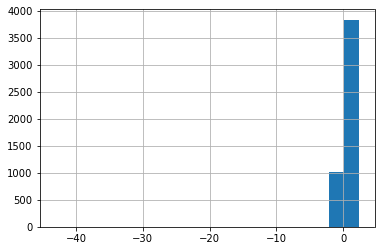

In [9]:
# check values range
print(buildings[['Height']].describe())
buildLessThan2o2 = buildings.loc[buildings['Height']<min_height, 'Height']
buildLessThan2o2.hist(bins=20)
print('Number of builidngs with abnormal height : {0}'.format(len(buildLessThan2o2)))

In [11]:
percBuildLessThan2o2 = len(buildLessThan2o2)/len(buildings)*100
print('Percentage of buildings with abnormal height :{0} %'.format(round(percBuildLessThan2o2,2)))

Percentage of buildings with abnormal height :7.33 %


In [12]:
# Set the heught of these buildings to Nan
buildings.loc[buildings['Height']<min_height, 'Height'] = np.nan

In [13]:
len(buildings)

66059

In [14]:
buildings.columns

Index(['OBJEKT_ID', 'OBJEKT_VER', 'DETALJTYP', 'ADAT', 'INSAM_LAGE', 'XYFEL',
       'NAMN1', 'NAMN2', 'NAMN3', 'HUVUDBYGGN', 'ANDAMAL_1', 'ANDAMAL_1T',
       'ANDAMAL_2', 'ANDAMAL_3', 'ANDAMAL_4', 'ANDAMAL_5', 'ANDAMAL_6',
       'ANDAMAL_7', 'ANDAMAL_8', 'ANDAMAL_9', 'ANDAMAL_10', 'HUSNR',
       'DSM_mean', 'DSM_max', 'DTM_mean', 'DTM_max', 'Height'],
      dtype='object')

#### Delete/rename buildings shapefiles columns

In [15]:
# get buildings attributes only
attributes_buildings = attributes[attributes['Feature']=='Buildings']
updated_columns = []
for col in buildings.columns:
    j = attributes_buildings['Attribute'].tolist().index(col)
    updated_columns.append(attributes_buildings['NewName'].tolist()[j])
drop_columns = [col for col in buildings.columns if updated_columns[buildings.columns.tolist().index(col)] == 'REMOVE']
updated_columns = [i for i in updated_columns if i != 'REMOVE']
buildings.drop(drop_columns, inplace=True, axis=1)
buildings.columns = updated_columns

In [16]:
# replace Type values by their english synonyms for data_file, options sheet
# swedish list
swedish = options[options['Attribute']=='DETALJTYP']['Purpose'].tolist()
english = options[options['Attribute']=='DETALJTYP']['Definition'].tolist()
buildings['Type'] = buildings['Type'].replace(swedish, english)

In [17]:
def purpose(x, codes_list, purposes_list, column_name):
    j = codes_list.index(x[column_name])
    return purposes_list[j]

Add Purpose and Details columns that give information about the building purpose based on its code

In [18]:
# read codes list from data list, codes sheet
#code column name
code_column = 'Code'

codes_list = codes[code_column].tolist()
purposes_list = codes['Purpose'].tolist()
detailed_purposes_list = codes['Details'].tolist()
buildings['Purpose'] = buildings.apply(lambda x: purpose(x, codes_list, purposes_list, code_column), axis = 1)
buildings['Details'] = buildings.apply(lambda x: purpose(x, codes_list, detailed_purposes_list, code_column), axis = 1)

In [ ]:
# check the units of the shapefile
print(buildings.crs.axis_info[0].unit_name)
# add area field; convert if unit is not meter
buildings['Area'] = buildings.geometry.area

#### Buildings volumes
The buildings volumes to be calculated by multiplying the area with the height on the perimeter. It is calculated in 1_nrgyhub_qgis jupyter notebook. Load the resulted file to calculate the volume

In [22]:
heightsPerimeter = pd.read_csv(os.path.join('C:/Users/akm03/Alaa/NERGYHUB/data/lantmateriet/Vasteras/DSM/las2dempro/at_deeper_perimeters', "dsm_values_at_perimeters.csv"))
#heightsPerimeter.drop(columns = ['Unnamed: 0'], inplace = True)
check_duplication(heightsPerimeter, column = 'ID', drop = True, 
                                     keep = 'first', inplace = True, ignore_index = True)

# concatenate files based on building id
buildings = buildings.merge(heightsPerimeter, how='left', left_on='BuildingID', right_on='ID')

590


In [24]:
# check columns and drop redundant varibales
print(buildings.columns)

# calculate volume
buildings['Height2'] = buildings['Value']-buildings['DTM_mean']
buildings.loc[buildings['Height2']<min_height, 'Height2'] = np.nan
buildings['Volume'] = buildings['Area']*buildings['Height2']
buildings.drop(columns = ['ID', 'Value'], inplace = True)

Index(['BuildingID', 'Type', 'Name', 'Code', 'DSM_mean', 'DSM_max', 'DTM_mean',
       'DTM_max', 'Height', 'Purpose', 'Details', 'ID', 'Value', 'Height2'],
      dtype='object')


#### Some buildings have negative values and less than 3.2 m3. If height != 0, replace volume by height*area

In [23]:
buildings['Volume2'] = buildings['Height'] * buildings['Area']
buildings.loc[(buildings['Volume']<min_volume)&(buildings['Height']!=0), 'Volume'] = buildings.loc[(buildings['Volume']<min_volume)&(buildings['Height']!=0), 'Volume2']
buildings.loc[buildings['Volume']<min_volume, 'Volume'] = np.nan

In [24]:
buildings.drop(columns = ['Volume2'], inplace = True)

In [5]:
import scipy.stats as stats
import numpy as np
from scipy import stats


def freedman_diaconis(data, returnas="width"):
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
    return(result)

def plot_hist(ID, df):
    df = df.loc[df['ID']==ID,'Value']
    print(df.min(), df.max(), df.median(), df.mean())
    fig, ax = plt.subplots(figsize = (6,4))
    # Plot histogram
    #df.plot(kind = "hist", density = True, bins = 20, grid=True,) # change density to true, because KDE uses density
    ax.hist(df, bins=freedman_diaconis(df, returnas = 'bins'), density = True)
    # Plot KDE
    df.plot(kind = "kde")
    
    # non-parametric pdf
    nparam_density = stats.kde.gaussian_kde(df.ravel())
    x = np.linspace(-20, max(df)+20, 500)
    nparam_density = nparam_density(x)
    #ax.plot(x, nparam_density, 'r-', label='non-parametric density (smoothed by Gaussian kernel)')
    
#     # Calculate percentiles
#     quant_5, quant_25, quant_50, quant_75, quant_95 = df.quantile(0.05), df.quantile(0.25), df.quantile(0.5), df.quantile(0.75), df.quantile(0.95)
#     # [quantile, opacity, length]
#     quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
#     # Plot the lines with a loop
#     for i in quants:
#         ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
        
    # X #
    ax.set_xlabel("Pixel Height (m)")
    ax.set_xlim(round(df.max())-5, round(df.max())+5)
    # Y #
    #ax.set_ylim(0, 2)
    #ax.set_yticks([])
    ax.set_ylabel("Frequency")
    
    
    # Annotations
#     ax.text(quant_5-.1, 0.17, "5th", size = 10, alpha = 0.8)
#     ax.text(quant_25-.13, 0.27, "25th", size = 11, alpha = 0.85)
#     ax.text(quant_50-.13, 0.37, "50th", size = 12, alpha = 1)
#     ax.text(quant_75-.13, 0.47, "75th", size = 11, alpha = 0.85)
#     ax.text(quant_95-.25, 0.57, "95th Percentile", size = 10, alpha =.8)
    
    # Overall #
    #ax.grid(False)
    ax.set_title("Building #{}".format(ID))

    # Remove ticks and spines
    #ax.tick_params(left = False, bottom = False)
    #for ax, spine in ax.spines.items():
     #   spine.set_visible(False)
        
    plt.show()

#### Volumes based on height on the perimeter didn't work. Another method os to try sth?!

43.7299995422363 53.8899993896484 49.6699981689453 50.55016342265494


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


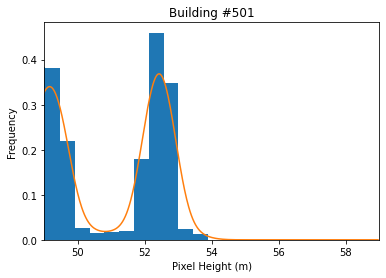

38.5900001525879 41.310001373291 40.8400001525879 40.80635297438678


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


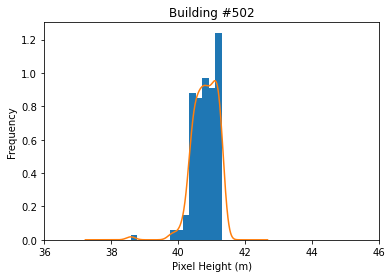

17.4799995422363 23.8899993896484 23.3299999237061 22.876582243606848


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


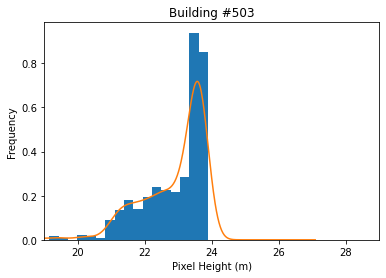

28.9799995422363 31.7199993133545 30.0799999237061 30.100360711415615


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


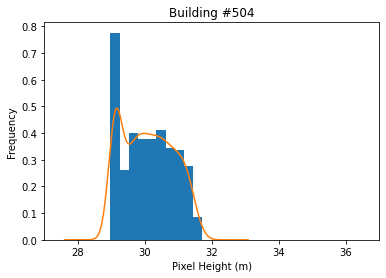

16.2800006866455 22.5499992370606 21.6100006103516 21.56003013863621


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


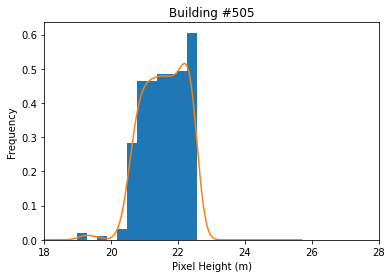

25.5300006866455 28.2299995422363 28.0400009155273 27.95635600009208


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


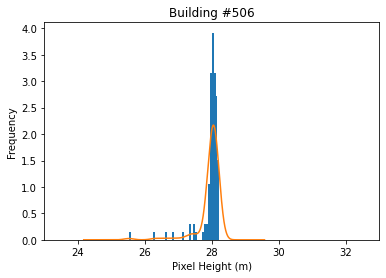

0.0 29.8799991607666 0.0 13.549394899113164


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


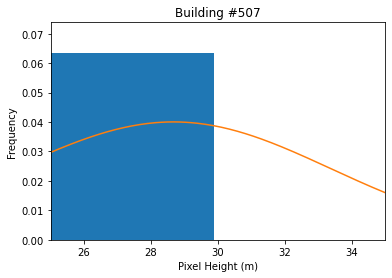

28.9699993133545 33.4599990844727 32.4300003051758 32.18212234601844


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


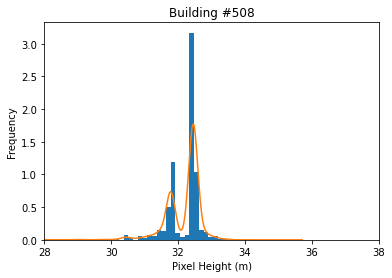

27.7299995422363 32.0499992370605 29.5300006866455 29.59934223003132


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


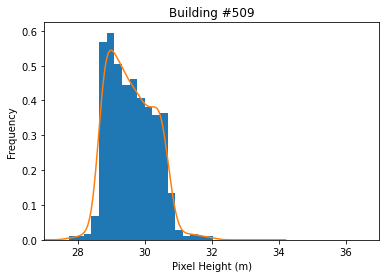

54.25 73.2799987792969 59.9199981689453 59.707400749083305


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


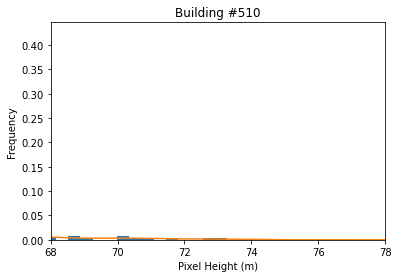

43.4000015258789 51.060001373291 50.060001373291 49.87591124026575


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


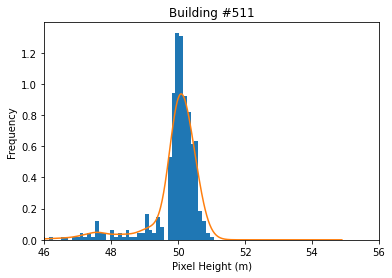

37.6300010681152 40.2900009155273 40.1500015258789 39.836445888841006


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


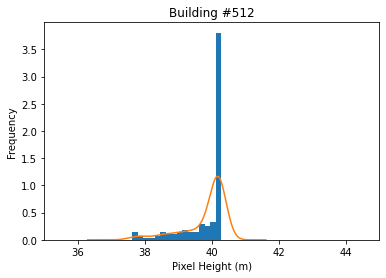

36.8800010681152 41.810001373291 41.0699996948242 40.94062294881852


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


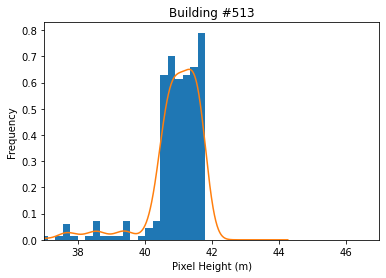

36.9099998474121 38.1300010681152 38.0200004577637 37.99307686243303


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


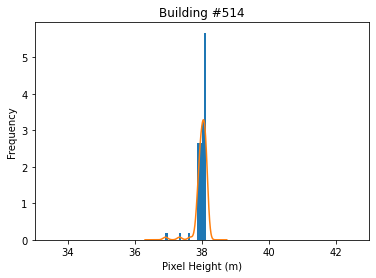

31.6399993896484 33.7799987792969 33.2900009155273 33.19068694660682


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


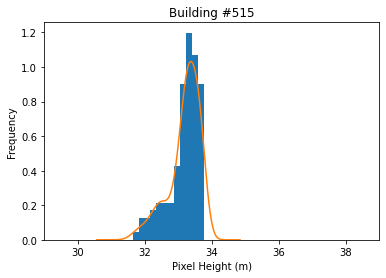

34.2200012207031 41.2700004577637 37.9799995422363 38.046851143582174


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


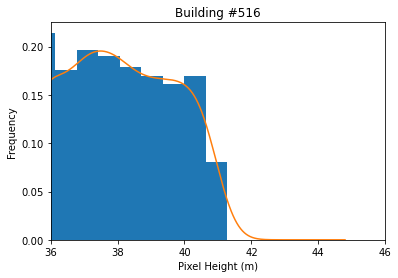

32.0099983215332 34.8800010681152 34.55500030517575 34.13313558546163


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


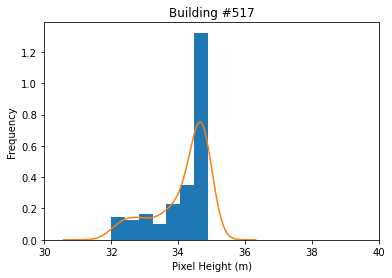

42.3300018310547 47.0999984741211 44.2299995422363 44.30509189297171


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


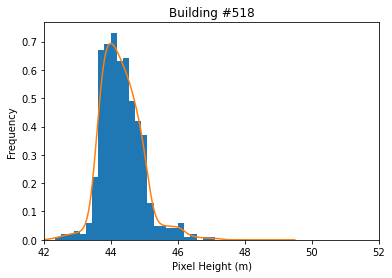

21.2099990844727 26.6299991607666 25.3700008392334 25.21028170637868


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


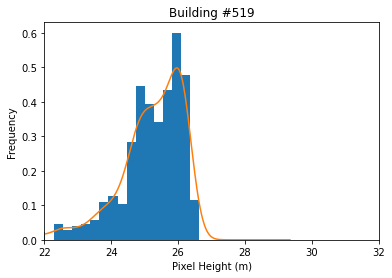

23.7600002288818 27.25 26.5 26.41950542324193


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


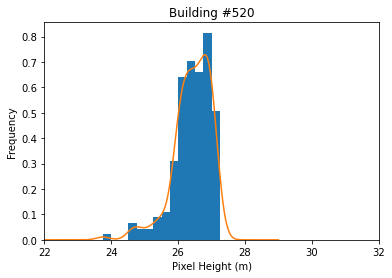

25.0499992370606 35.8600006103516 34.8600006103516 34.692422117741465


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


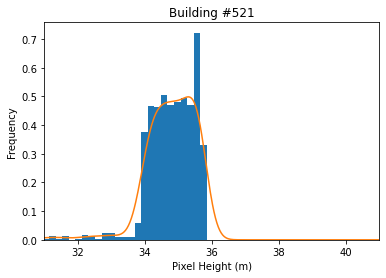

35.0699996948242 41.9500007629395 40.5400009155273 40.13169615716475


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


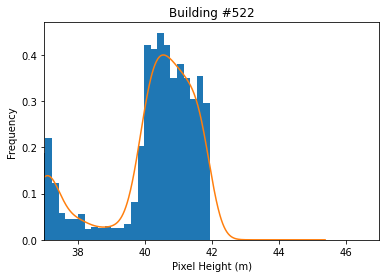

27.6900005340576 32.7400016784668 29.1399993896484 29.239784571589254


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


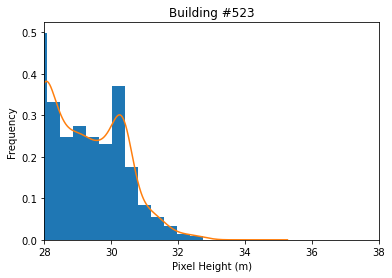

39.6300010681152 44.0900001525879 42.2099990844727 42.22211072374341


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


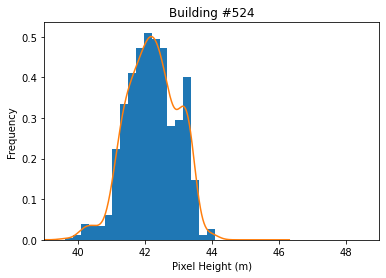

31.7900009155273 37.4599990844727 36.2450008392334 36.04006941230209


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


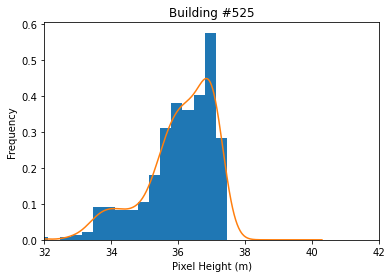

36.0499992370606 61.5400009155274 45.8800010681152 47.56496724691877


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


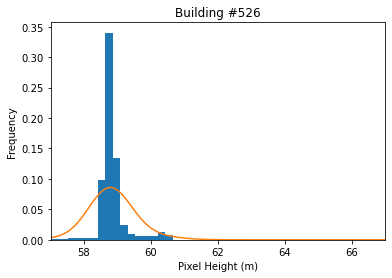

0.0 41.3699989318848 36.9000015258789 24.46529849133088


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


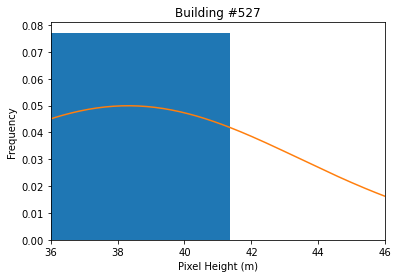

36.5499992370606 39.060001373291 38.4099998474121 38.25710914409267


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


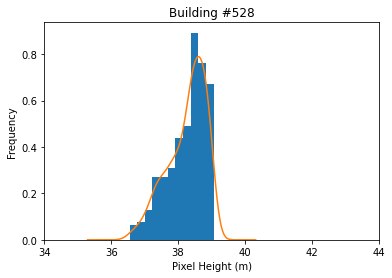

45.7900009155274 58.9799995422363 51.6399993896484 52.92184590910641


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


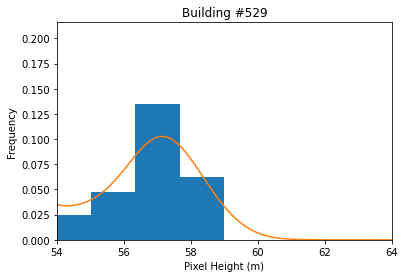

37.310001373291 41.2599983215332 39.8899993896484 39.846952727778046


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


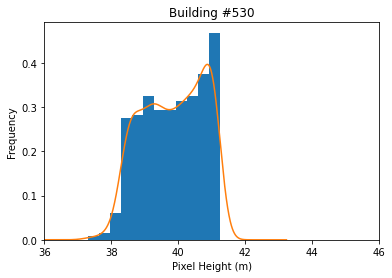

27.75 34.0099983215332 31.4500007629395 31.509230781620385


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


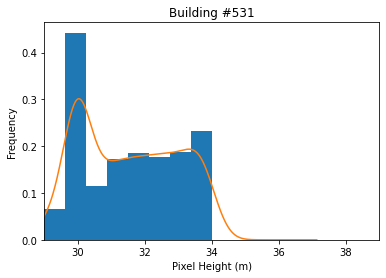

30.8899993896484 38.0200004577637 34.42499923706055 34.27898709116311


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


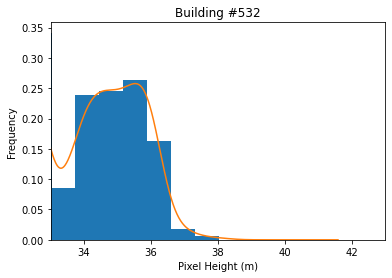

43.8400001525879 47.1500015258789 46.01499938964845 45.954956026720524


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


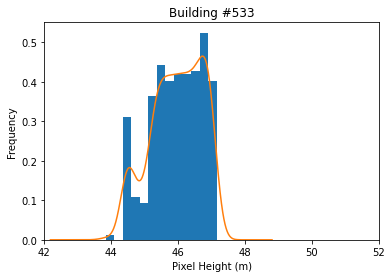

35.7000007629395 40.4599990844727 39.5400009155273 39.47312421224792


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


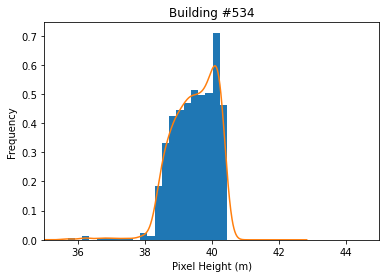

36.4799995422363 36.7000007629395 36.5800018310547 36.58000013563368


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


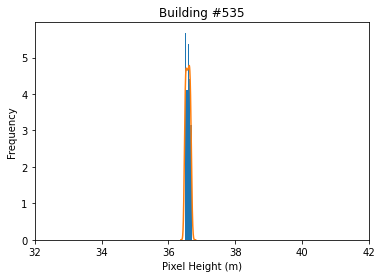

42.2099990844727 48.4900016784668 46.25 46.13688311886478


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


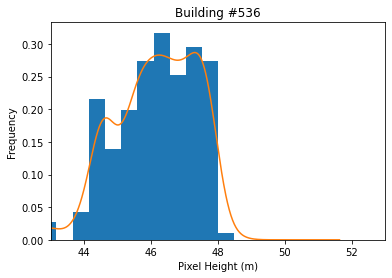

34.0 40.3499984741211 38.2700004577637 38.09366530941841


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


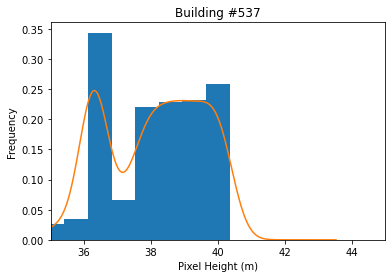

24.8600006103516 29.2800006866455 26.2149991989136 26.345523838769825


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


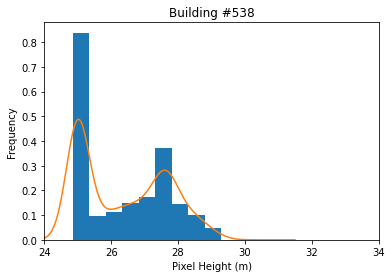

28.3899993896484 32.3300018310547 31.2900009155273 31.27939498806339


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


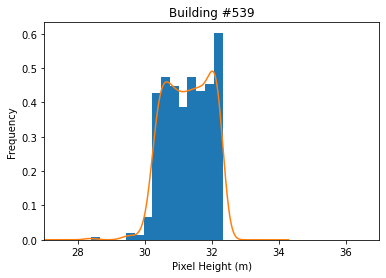

12.3999996185303 20.4400005340576 18.1100006103516 18.062199503289442


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


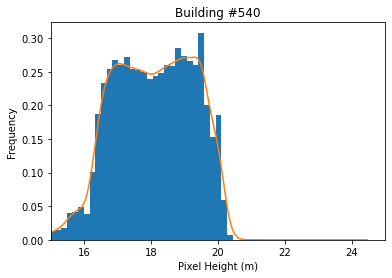

24.8999996185303 40.0400009155273 29.8049993515015 29.74164504214273


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


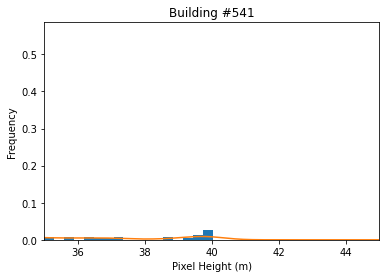

35.9900016784668 52.560001373291 48.2700004577637 47.60922608545529


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


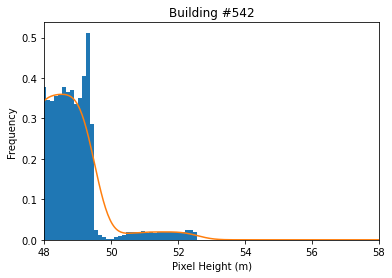

17.2099990844727 26.75 24.2399997711182 23.954010221331608


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


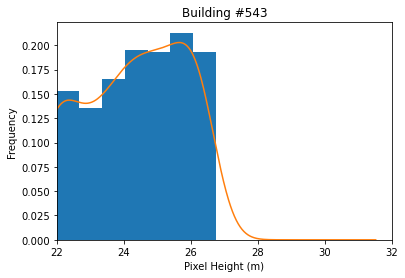

47.9300003051758 53.5800018310547 53.1399993896484 52.88925200153577


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


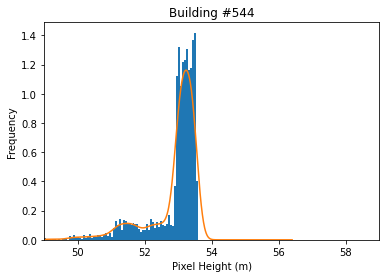

20.8799991607666 30.4400005340576 28.2900009155273 28.11318286008814


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


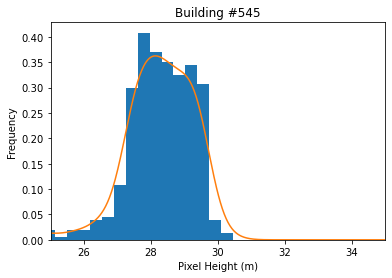

36.5499992370606 41.6599998474121 39.7900009155273 39.77899785641668


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


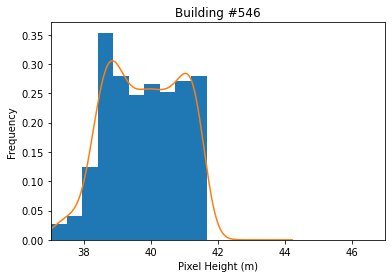

37.5200004577637 52.060001373291 49.6300010681152 49.165332126218786


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


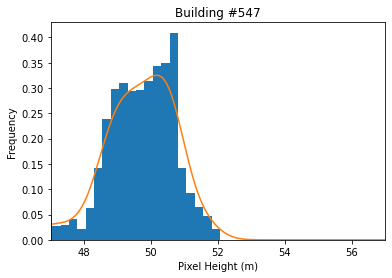

0.0 45.7599983215332 43.0699996948242 37.081342859205854


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


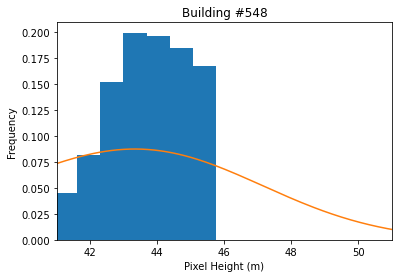

39.2000007629395 42.7400016784668 41.7000007629395 41.65846420208197


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


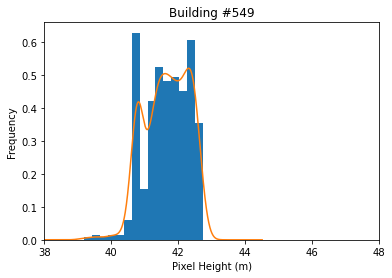

37.689998626709 44.8300018310547 43.14500045776365 42.35297122626259


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


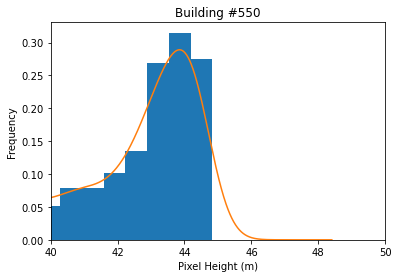

38.189998626709 41.0 40.5900001525879 40.45941168841195


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


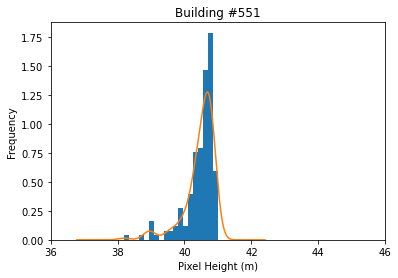

41.0699996948242 46.939998626709 45.53499984741215 45.382092655657196


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


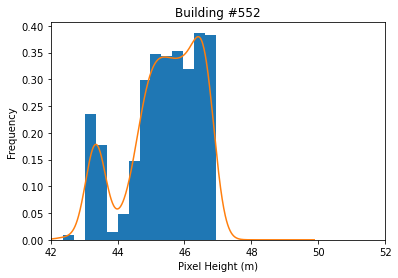

28.3099994659424 33.6100006103516 32.39500045776365 32.28227845928337


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


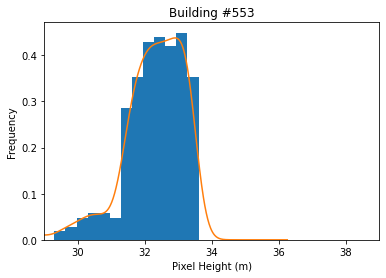

36.6199989318848 44.0299987792969 41.4799995422363 41.301284939217176


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


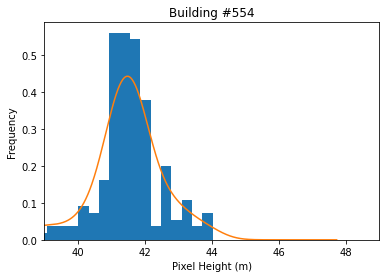

45.3499984741211 45.5699996948242 45.4599990844727 45.4578471183777


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


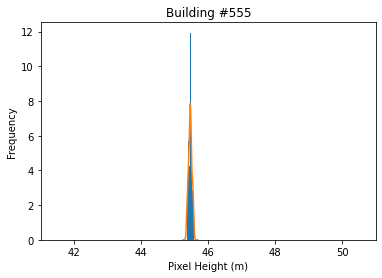

40.5099983215332 48.0200004577637 45.7299995422363 45.60841703175301


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


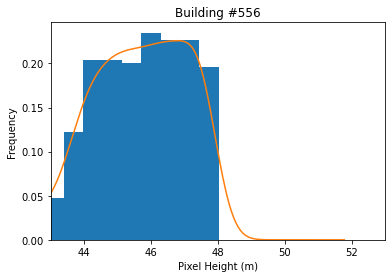

49.8300018310547 66.8600006103516 53.3400001525879 53.32531724451532


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


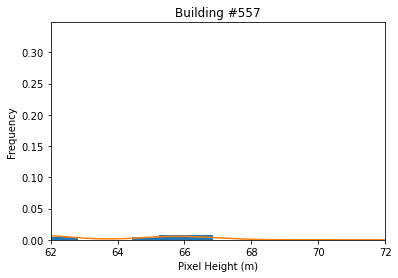

31.0799999237061 36.5 35.0 34.78081153648487


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


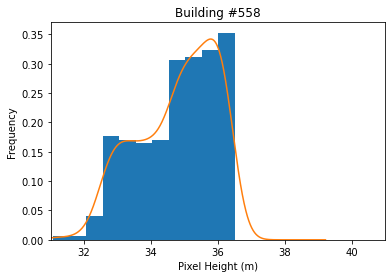

32.6500015258789 37.4599990844727 35.7099990844727 35.628851453612064


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


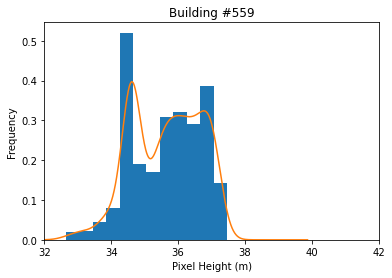

36.4000015258789 39.8499984741211 38.3300018310547 38.34901442894569


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


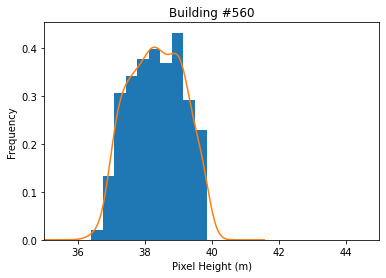

36.7200012207031 39.939998626709 39.0 38.940332796305796


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


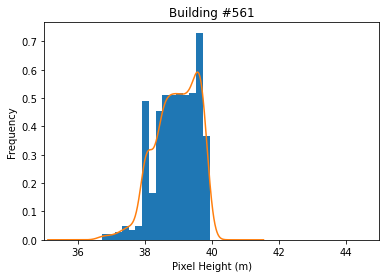

35.810001373291 40.0 38.7099990844727 38.71103336473717


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


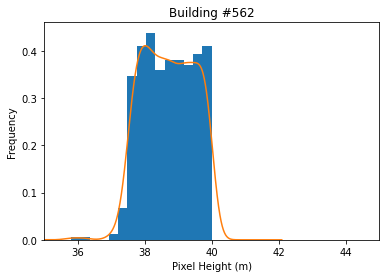

37.8899993896484 41.2299995422363 40.810001373291 40.619152715650664


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


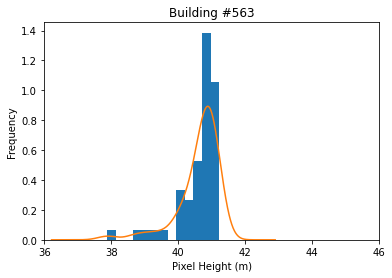

32.9900016784668 46.9599990844727 43.560001373291 41.211391986485324


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


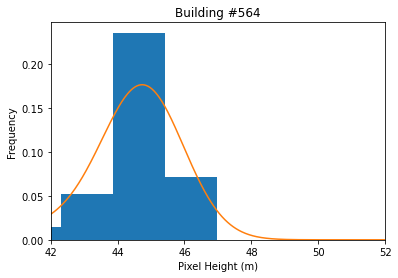

39.2900009155273 42.8800010681152 40.5 40.867207192085885


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


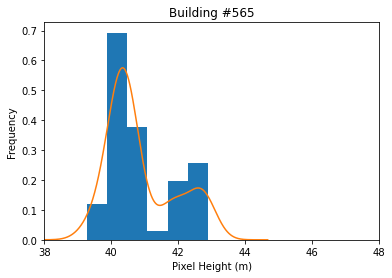

36.5200004577637 38.5299987792969 38.2099990844727 38.17870324214528


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


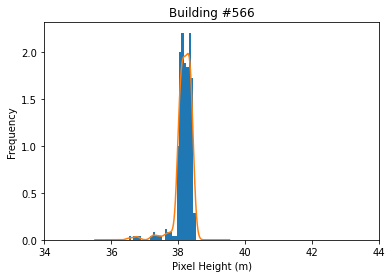

44.5099983215332 45.9300003051758 45.7000007629395 45.59061198331873


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


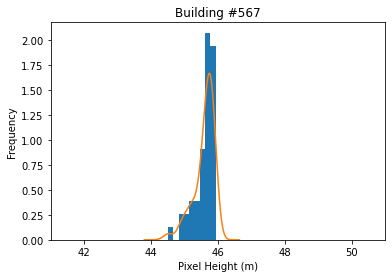

35.6399993896484 42.8800010681152 40.5400009155273 40.55428572278335


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


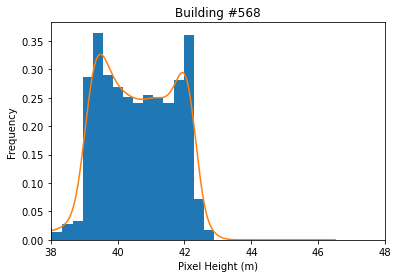

27.8700008392334 33.7099990844727 31.6599998474121 31.542202421366447


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


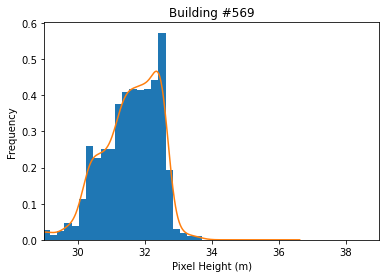

28.25 33.8899993896484 32.5999984741211 32.200551181703105


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


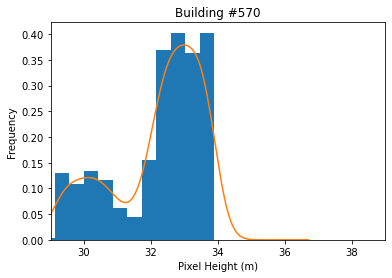

36.7599983215332 43.0499992370606 40.4500007629395 40.52797646513154


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


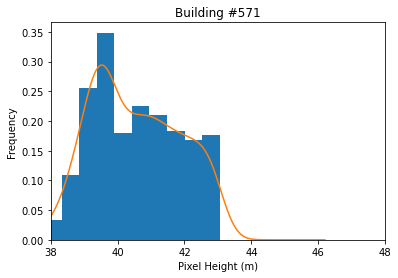

39.810001373291 43.6800003051758 42.5699996948242 42.57635628447241


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


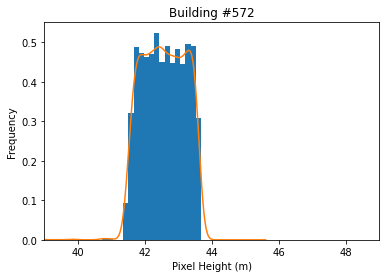

24.3500003814697 32.4599990844727 27.63999938964845 27.900656497839734


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


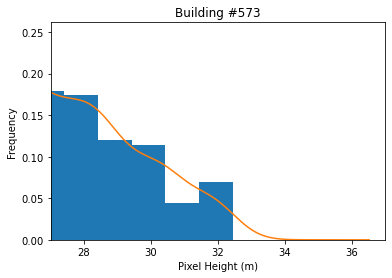

43.3300018310547 45.3699989318848 43.8449993133545 43.929938990895344


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


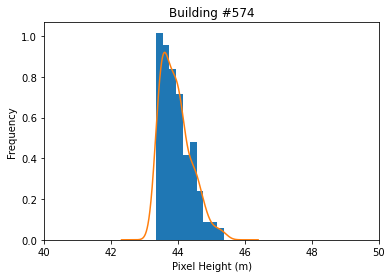

31.3799991607666 37.060001373291 34.9799995422363 34.75106751685049


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


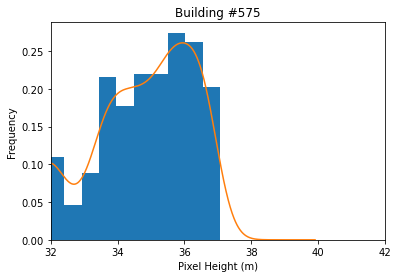

50.0400009155274 56.4799995422363 51.3400001525879 51.70602934220258


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


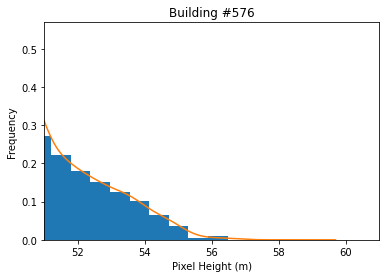

36.7200012207031 37.8400001525879 37.6699981689453 37.56431325276693


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


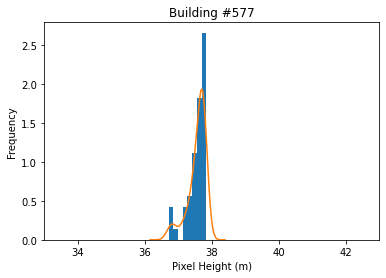

35.9700012207031 40.810001373291 39.92000007629395 39.781056908088004


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


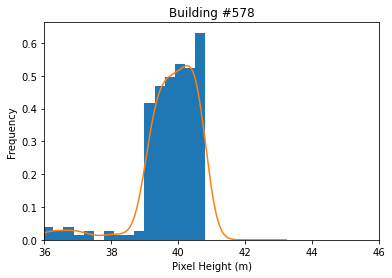

39.2000007629395 47.25 44.2900009155273 43.90323009659759


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


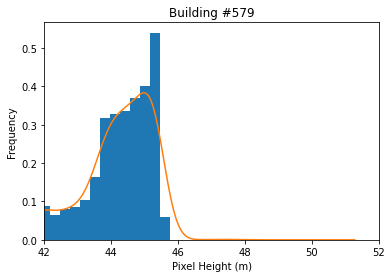

33.1699981689453 38.9500007629395 38.6399993896484 38.132816916452335


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


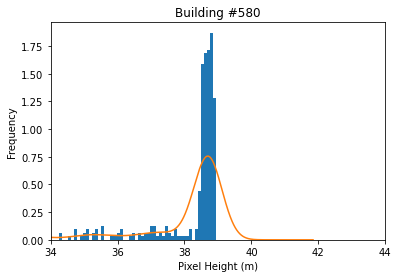

35.4700012207031 41.2700004577637 38.6399993896484 38.80390097740853


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


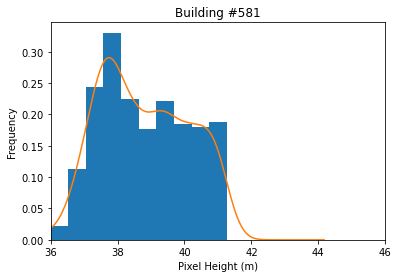

25.6299991607666 30.2399997711182 27.5799999237061 27.404952346710935


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


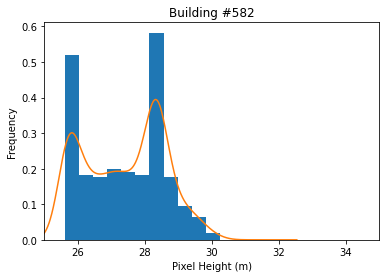

45.0200004577637 50.7299995422363 48.9700012207031 48.78539785569715


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


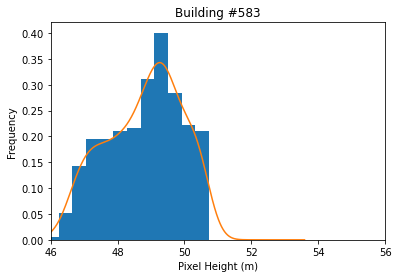

38.5900001525879 41.810001373291 40.6199989318848 40.592778572887404


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


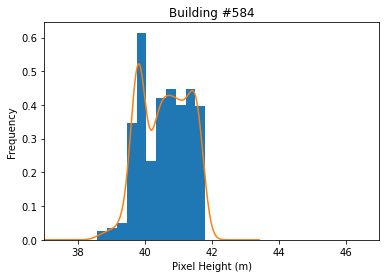

37.5200004577637 48.8499984741211 41.30500030517575 41.274987245092596


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


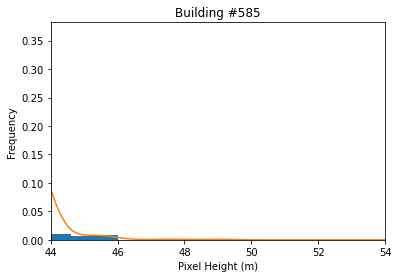

34.3400001525879 36.4300003051758 34.5200004577637 34.8194957701098


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


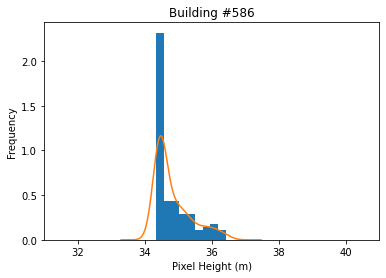

36.7400016784668 39.2200012207031 38.1500015258789 38.17862545831686


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


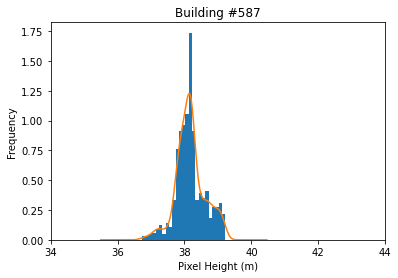

29.4799995422363 35.7200012207031 34.7549991607666 34.36100904657207


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


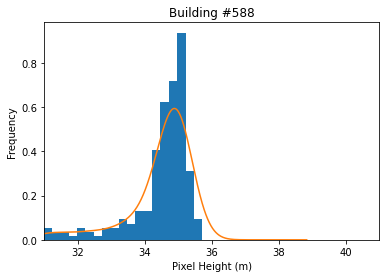

29.9500007629395 35.2799987792969 33.85499954223635 33.615251577125406


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


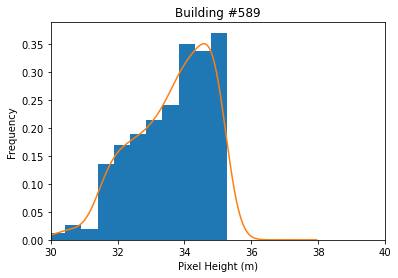

39.8899993896484 48.9599990844727 46.2900009155274 45.69025640895224


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


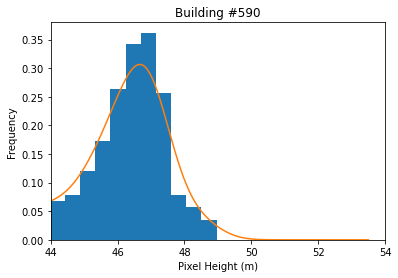

32.1199989318848 35.7999992370605 35.1800003051758 34.93097322177044


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


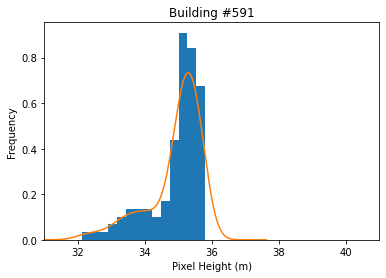

67.879997253418 77.1900024414063 75.4800033569336 74.77533220596544


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


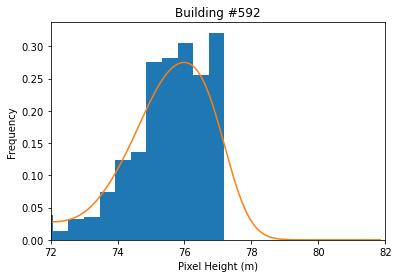

0.0 37.8600006103516 36.4700012207031 32.397047332402394


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


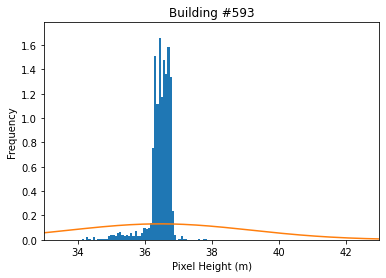

28.4400005340576 30.5900001525879 30.1399993896484 30.046153908101928


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


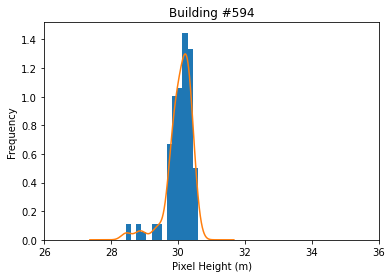

43.5299987792969 47.8699989318848 46.2999992370606 46.25635065887398


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


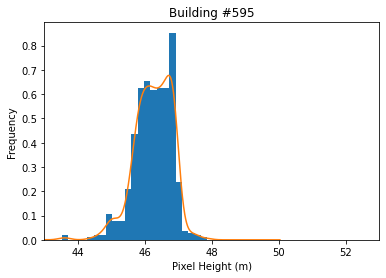

29.3299999237061 37.5099983215332 34.6199989318848 33.871394208294184


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


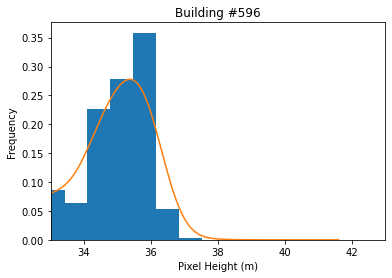

27.0200004577637 45.0699996948242 31.0100002288818 32.587024783299974


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


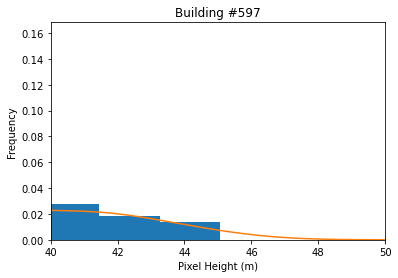

37.9799995422363 41.8600006103516 40.2599983215332 40.25175505364399


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


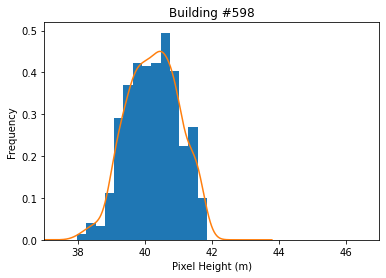

26.3999996185303 34.0999984741211 27.8899993896484 28.091165271856024


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


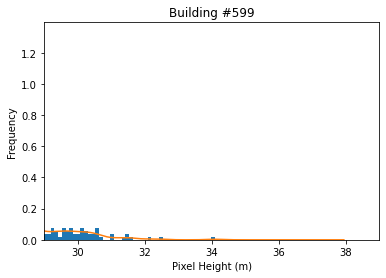

32.5299987792969 38.1199989318848 37.5800018310547 37.145999974789824


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


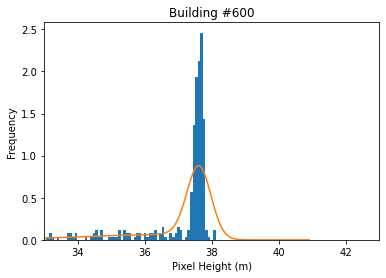

52.1699981689453 66.0400009155273 56.0900001525879 57.16044447157118


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


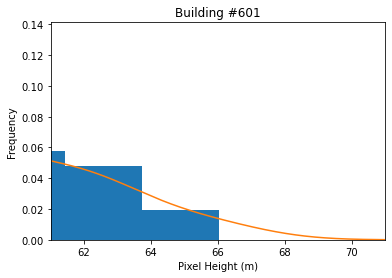

29.5400009155273 35.2299995422363 33.2049999237061 33.169914943613904


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


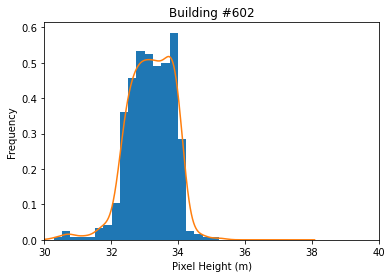

45.3300018310547 55.25 52.64500045776365 52.20263493250287


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


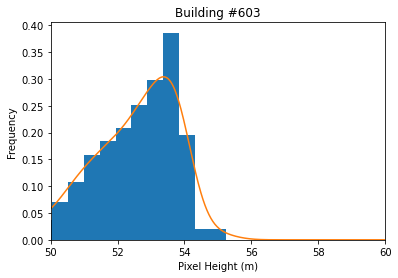

42.3300018310547 43.8800010681152 43.7749996185303 43.727771207510706


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


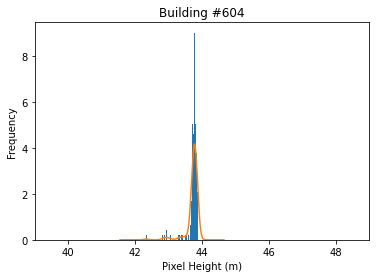

27.1900005340576 39.4000015258789 37.4900016784668 37.305550362329065


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


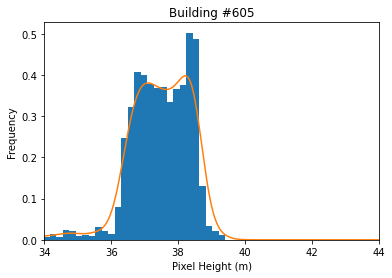

32.7299995422363 46.5499992370606 35.1100006103516 35.9570588504567


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


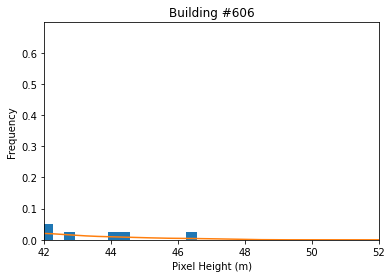

36.0499992370606 41.8300018310547 41.4799995422363 41.34788466023875


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


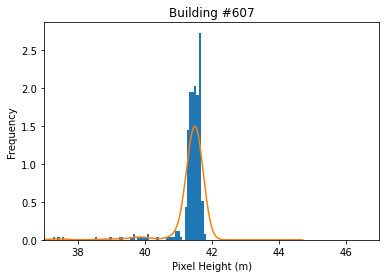

25.3600006103516 27.4599990844727 26.8700008392334 26.89503585993176


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


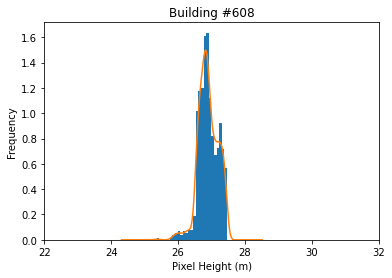

30.8700008392334 32.4199981689453 32.0099983215332 31.94926838758515


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


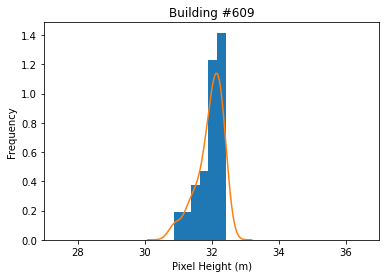

37.0 41.310001373291 39.9099998474121 39.864249587944684


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


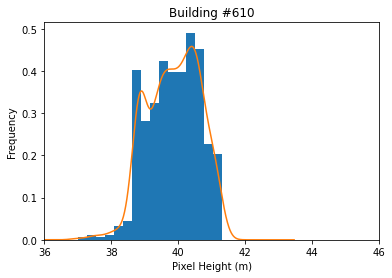

34.8499984741211 53.7200012207031 36.3499984741211 39.54348194898005


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


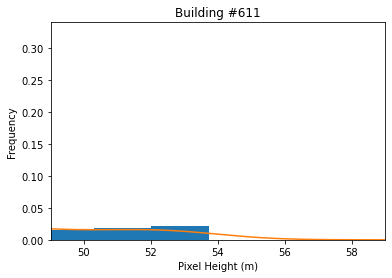

23.0100002288818 41.5299987792969 32.8199996948242 32.63418056015984


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


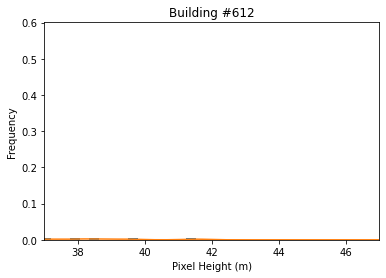

27.5599994659424 39.2599983215332 36.7099990844727 36.283521352262575


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


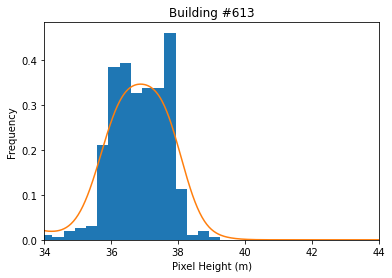

38.5200004577637 41.9500007629395 41.2900009155273 41.22659385048146


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


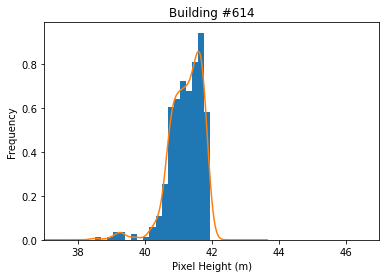

31.1299991607666 36.939998626709 35.5 35.038417944684625


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


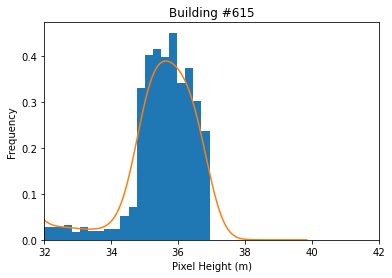

44.1800003051758 55.7799987792969 47.2299995422363 46.94521720572104


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


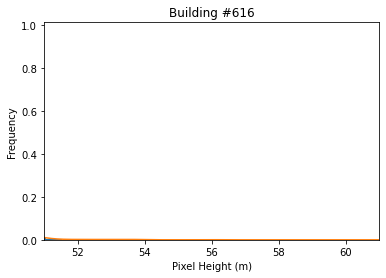

25.0900001525879 40.9199981689453 33.0850009918213 33.063944560378346


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


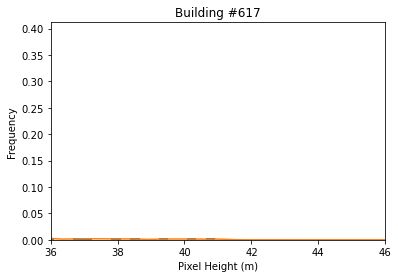

33.8499984741211 36.4700012207031 36.1500015258789 35.91605585409825


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


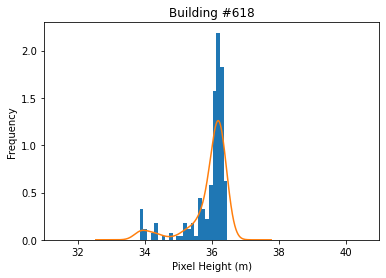

24.8099994659424 31.1100006103516 29.75 29.63962263431189


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


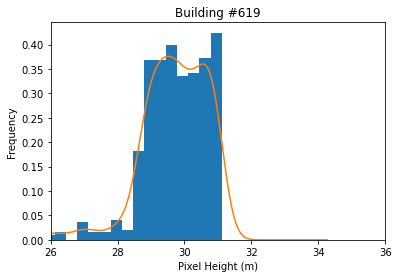

36.7200012207031 41.3699989318848 39.8400001525879 39.69010974481109


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


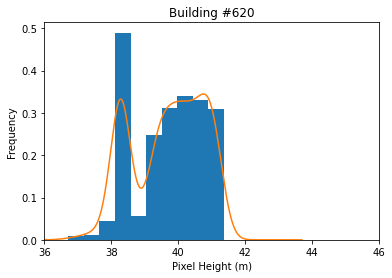

27.1000003814697 28.8600006103516 28.649999618530302 28.42500005449568


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


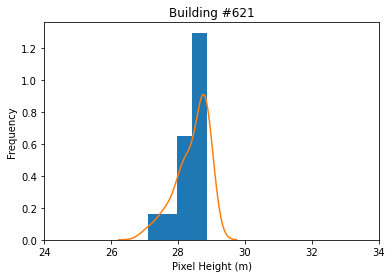

39.3400001525879 46.2400016784668 42.8499984741211 42.86403717811047


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


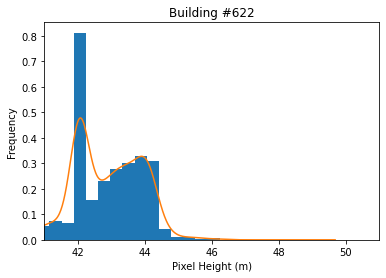

0.0 32.8300018310547 28.99499988555905 23.513525360740278


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


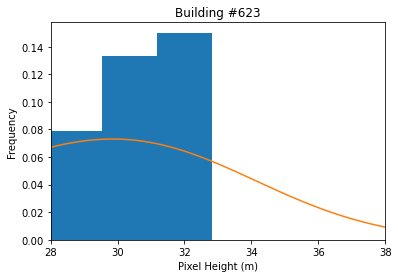

45.4199981689453 51.7000007629395 49.1800003051758 49.00632057120458


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


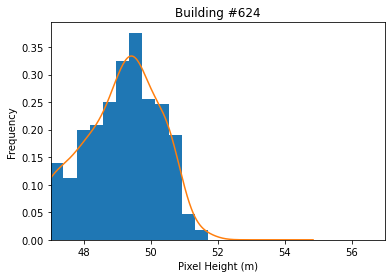

54.2099990844727 63.0499992370606 55.0 55.26682289441427


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


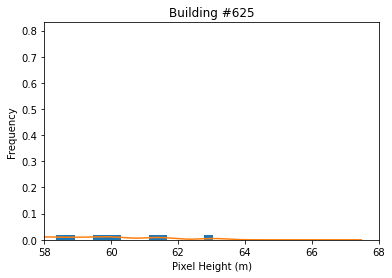

38.560001373291 42.6199989318848 40.6699981689453 40.661536924811784


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


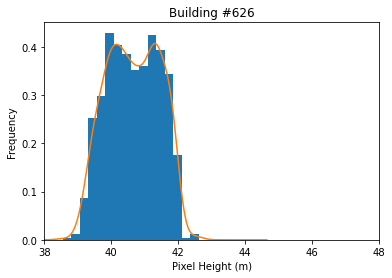

33.9500007629395 39.7599983215332 39.4199981689453 39.27604574733614


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


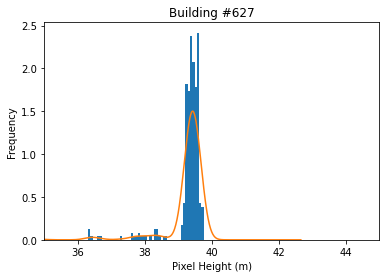

34.4199981689453 49.0 37.689998626709 37.573575590932094


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


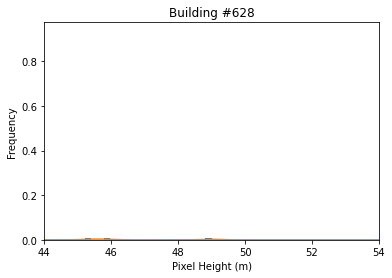

37.0200004577637 43.3699989318848 39.7299995422363 39.625983119262955


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


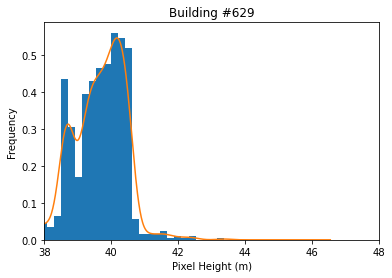

29.1499996185303 31.0400009155273 30.6900005340576 30.56857136317662


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


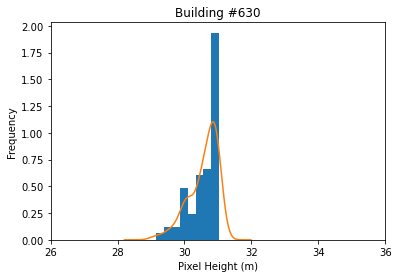

40.5699996948242 43.0 42.9500007629395 42.77886190647034


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


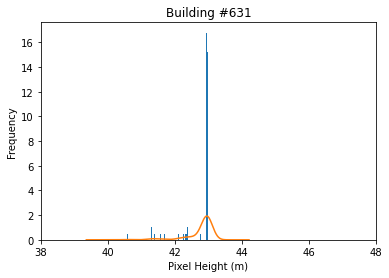

35.4599990844727 39.8699989318848 39.060001373291 38.49067445234819


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


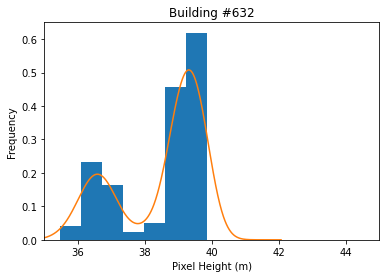

32.8899993896484 41.9500007629395 33.4000015258789 34.32432829444089


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


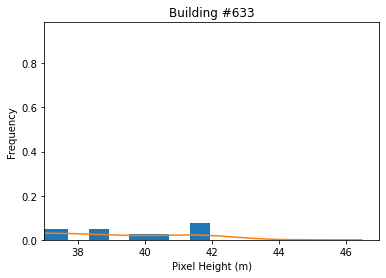

41.1100006103516 43.3899993896484 43.0999984741211 42.93160700798035


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


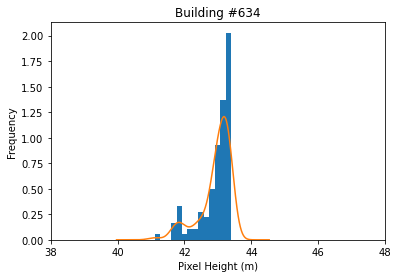

32.9199981689453 37.060001373291 35.6649990081787 35.43562504223415


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


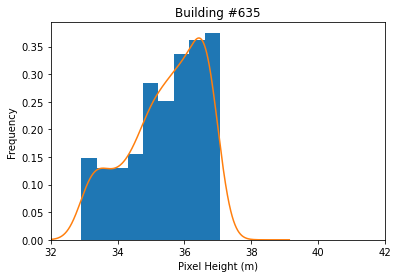

29.1800003051758 32.7400016784668 30.6800003051758 30.70973333086287


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


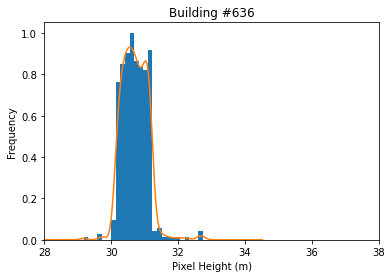

30.4300003051758 36.6699981689453 35.2049999237061 35.16288174675934


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


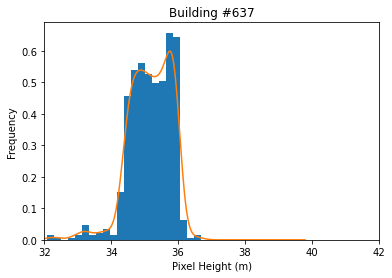

32.1399993896484 33.9500007629395 33.6149997711182 33.50435892740885


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


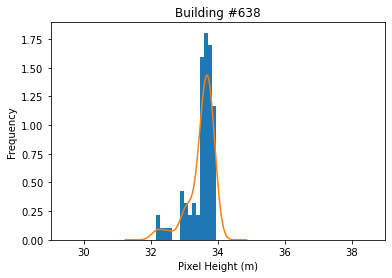

29.0 33.2700004577637 32.5400009155273 32.4419948106567


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


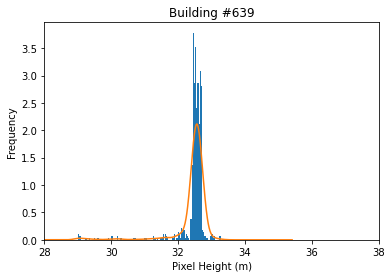

35.0299987792969 39.5800018310547 38.1100006103516 38.13291763305664


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


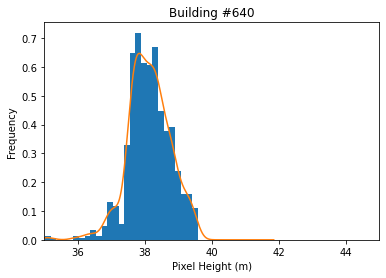

39.3199996948242 44.5 42.8199996948242 42.77582576357085


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


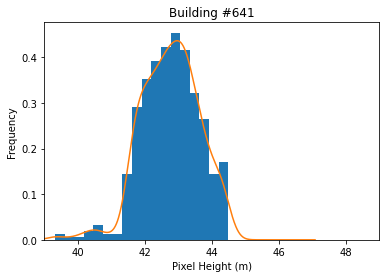

45.4199981689453 47.3600006103516 47.2700004577637 47.011944664849175


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


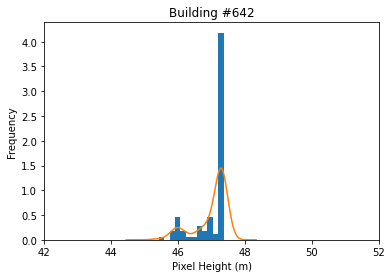

31.2900009155273 33.7299995422363 32.94499969482425 32.9171134516136


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


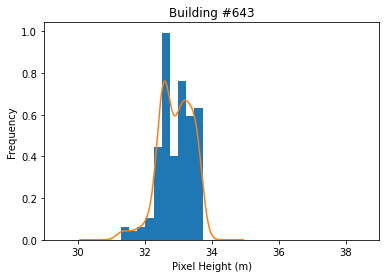

36.6800003051758 42.4599990844727 39.3449993133545 39.230817514573225


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


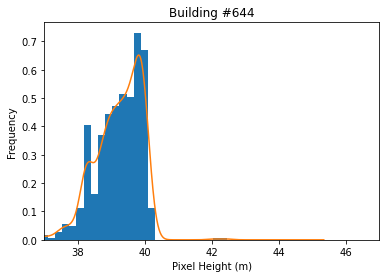

44.7200012207031 48.4199981689453 47.4300003051758 47.3082858252147


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


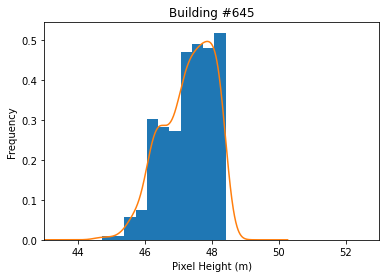

49.7999992370606 60.4599990844727 53.5299987792969 53.43131139965191


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


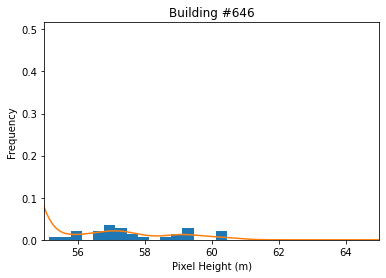

37.9700012207031 44.4199981689453 43.6599998474121 43.44622583696919


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


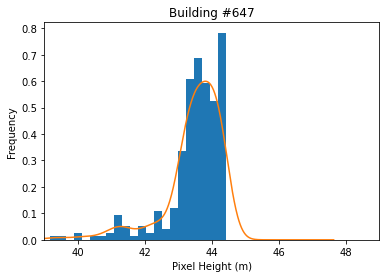

32.9199981689453 38.4700012207031 35.4700012207031 35.693035568509785


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


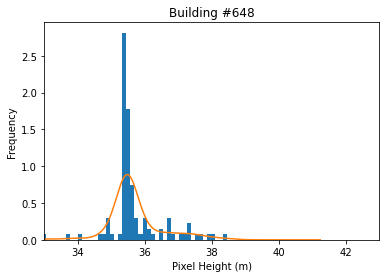

34.1300010681152 38.0400009155273 37.7200012207031 37.47653245179178


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


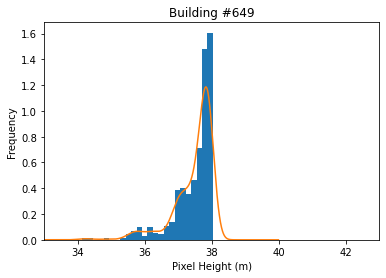

36.9900016784668 38.9700012207031 38.5850009918213 38.37260025024414


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


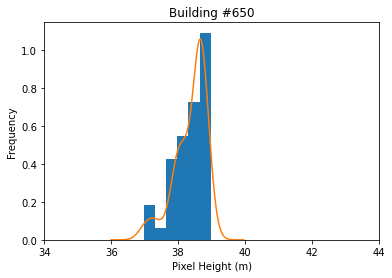

37.7000007629395 41.4199981689453 40.0900001525879 40.080168367636325


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


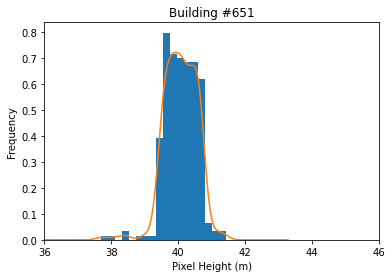

51.8400001525879 57.2700004577637 53.1849994659424 53.324374973773956


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


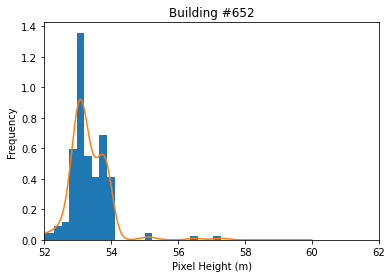

32.5900001525879 37.810001373291 34.5900001525879 34.69509812897327


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


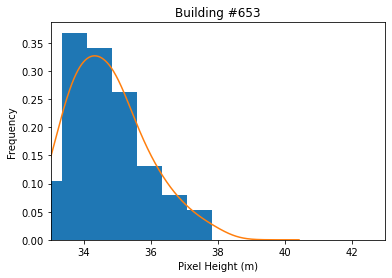

35.0499992370606 46.4099998474121 40.4300003051758 40.18929688632488


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


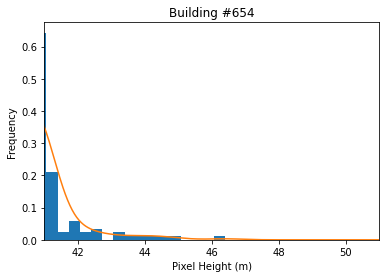

36.2299995422363 38.8499984741211 38.2799987792969 38.24732095355929


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


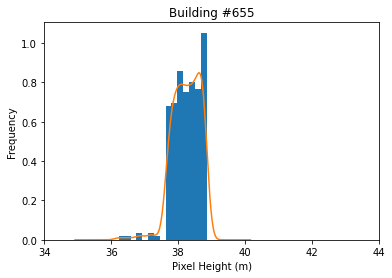

36.9599990844727 43.8600006103516 41.9700012207031 41.91440984135481


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


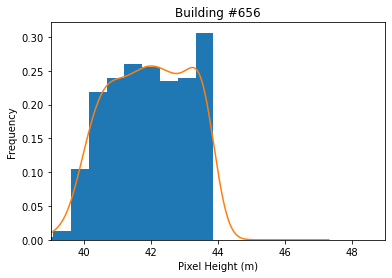

40.810001373291 54.0 43.939998626709 45.222980145587044


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


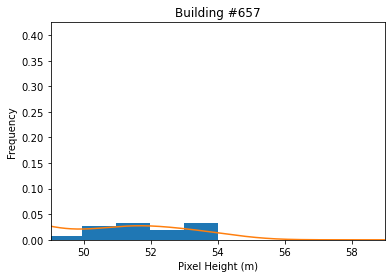

23.8700008392334 41.9500007629395 38.1100006103516 37.95679070535917


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


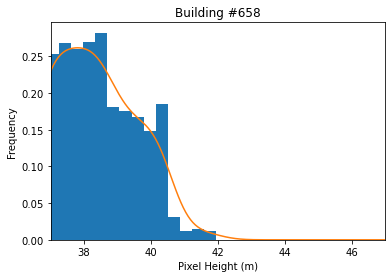

33.8699989318848 37.8699989318848 36.5049991607666 36.4190495312214


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


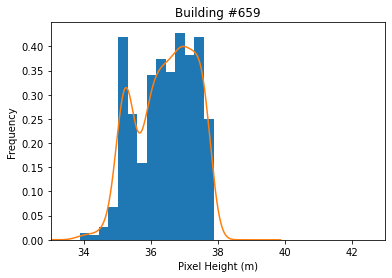

39.3800010681152 44.8899993896484 42.9149990081787 42.84839987618582


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


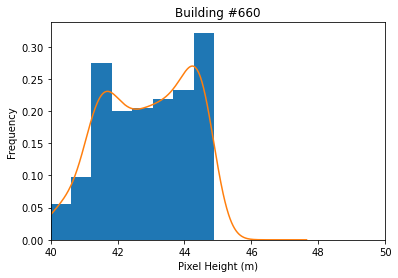

37.2799987792969 38.7599983215332 38.69499969482425 38.473863861777566


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


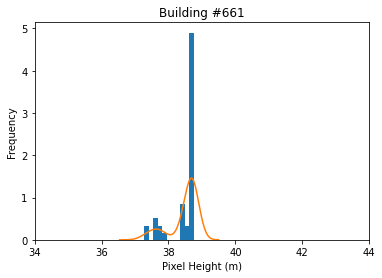

25.6399993896484 28.5100002288818 28.0599994659424 27.932990300453323


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


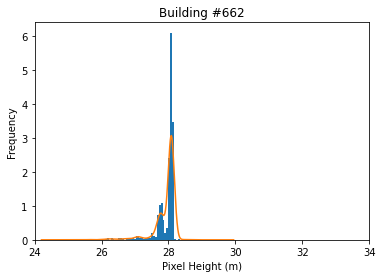

39.0499992370606 42.9599990844727 40.5699996948242 41.101858358467574


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


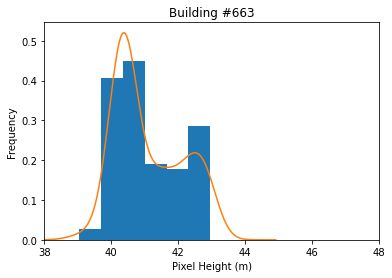

32.2599983215332 37.5900001525879 36.420000076293945 35.733318531407726


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


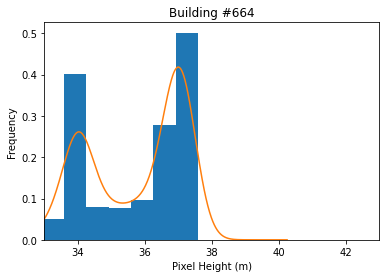

34.8199996948242 46.4599990844727 35.8300018310547 36.08383109876845


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


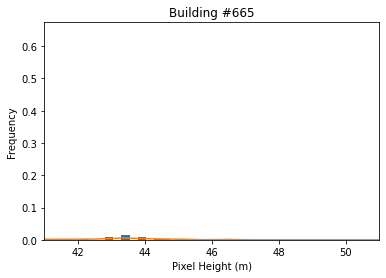

30.5100002288818 32.5800018310547 32.07500076293945 32.02000009218852


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


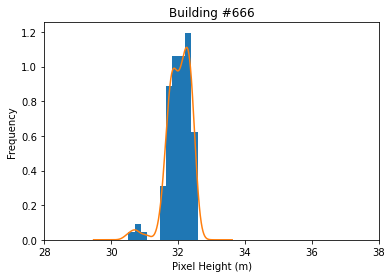

29.3299999237061 32.4500007629395 30.8799991607666 30.94809424136895


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


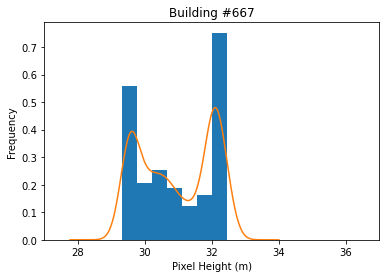

33.7799987792969 36.2900009155273 36.0400009155273 35.934757830410604


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


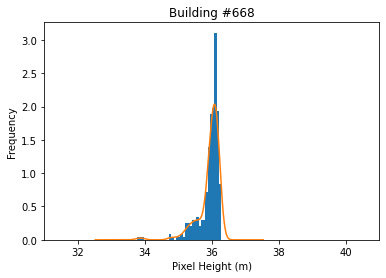

24.920000076294 37.2599983215332 29.6800003051758 29.672305727916164


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


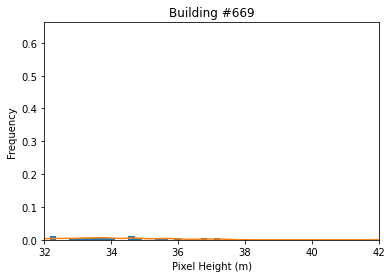

34.4799995422363 39.3499984741211 38.939998626709 38.775042219564945


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


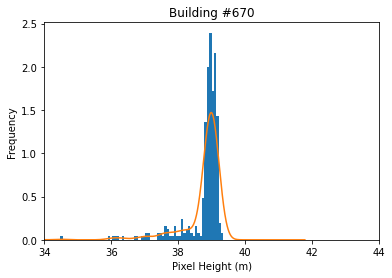

41.3400001525879 50.2599983215332 46.8899993896484 46.797639317712566


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


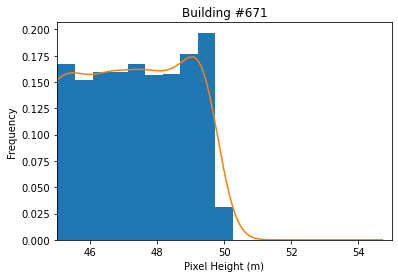

29.25 33.1399993896484 32.0400009155273 32.10169600219727


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


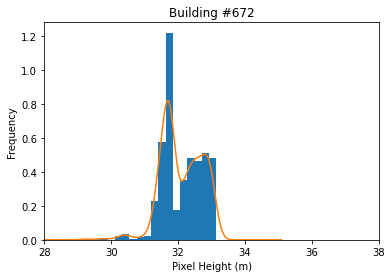

30.4799995422363 35.25 33.7900009155273 33.658627198610695


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


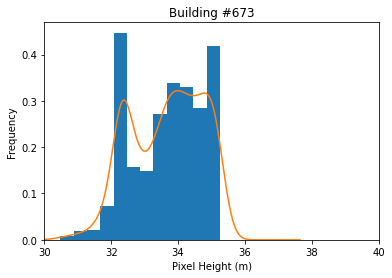

37.689998626709 41.9099998474121 40.3600006103516 40.35662389632759


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


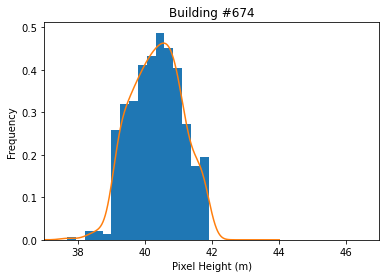

45.1599998474121 50.2000007629395 48.810001373291 48.554914273959206


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


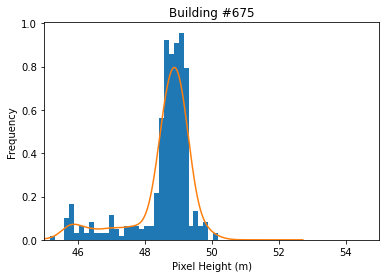

40.0099983215332 45.3600006103516 43.5699996948242 43.31611977553949


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


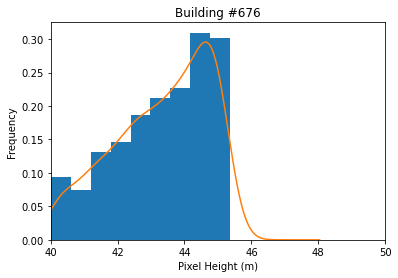

35.2799987792969 41.9700012207031 41.1599998474121 40.989935511927456


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


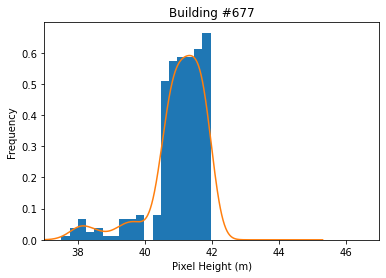

23.25 33.2299995422363 27.3700008392334 27.489388794567066


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


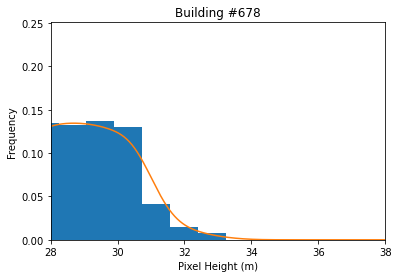

32.4799995422363 36.0200004577637 35.6699981689453 35.50483245423386


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


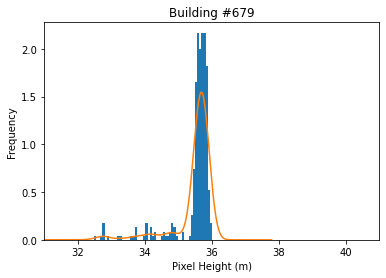

17.25 22.5599994659424 21.5799999237061 21.54964177145887


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


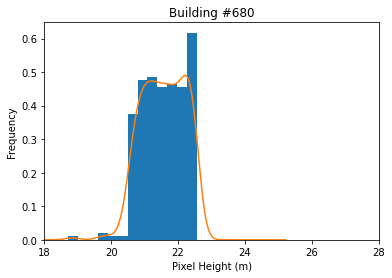

0.0 40.6800003051758 40.189998626709 35.659826162587045


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


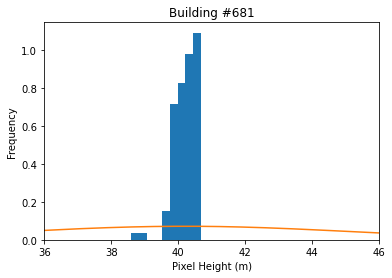

38.0 40.1699981689453 40.1300010681152 39.98188690569415


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


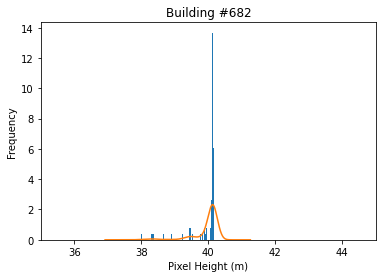

36.0699996948242 42.9199981689453 39.4950008392334 39.680443476605156


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


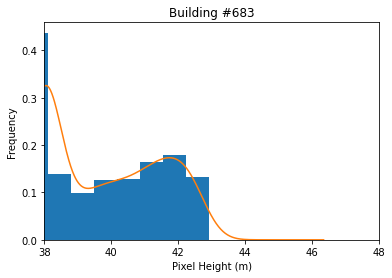

18.5100002288818 28.0699996948242 25.0799999237061 24.682184214341017


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


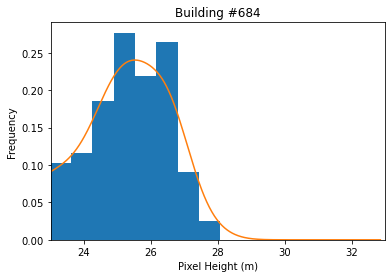

33.8899993896484 36.7200012207031 36.1500015258789 36.10450612762828


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


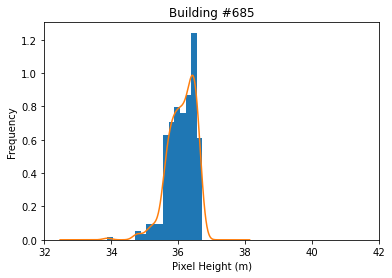

42.4900016784668 48.3400001525879 46.340000152587905 45.86006901181979


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


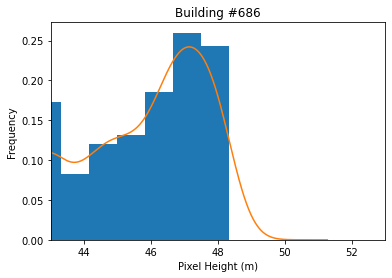

37.8199996948242 44.0200004577637 42.9599990844727 42.352650773936304


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


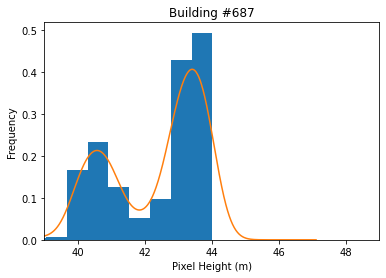

32.0099983215332 35.9199981689453 35.0999984741211 34.937836705421915


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


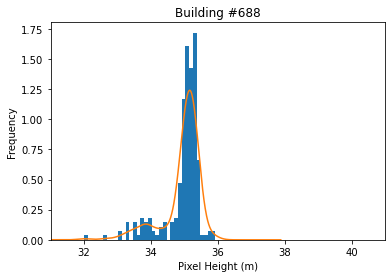

33.5499992370606 46.689998626709 44.75 43.81904948932583


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


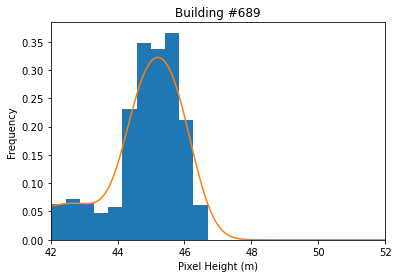

33.2099990844727 37.4900016784668 36.2799987792969 36.17511414247742


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


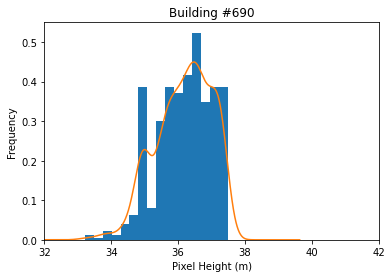

31.1499996185303 36.8400001525879 35.4900016784668 35.15858360593109


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


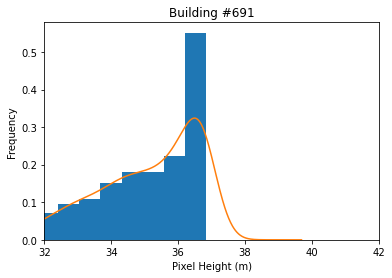

30.1399993896484 33.4500007629395 33.1599998474121 33.025695632062174


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


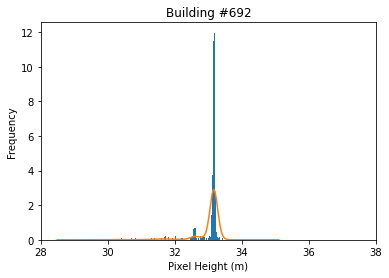

43.2200012207031 46.1100006103516 45.5099983215332 45.41996435437885


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


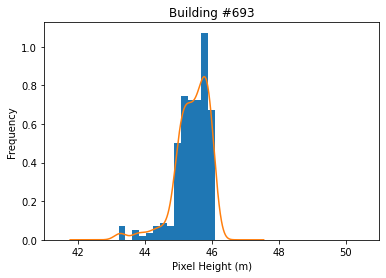

21.8600006103516 29.9500007629395 26.7700004577637 26.31444578515479


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


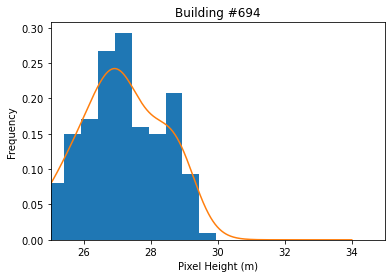

25.9099998474121 28.6000003814697 27.8899993896484 27.799740283520197


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


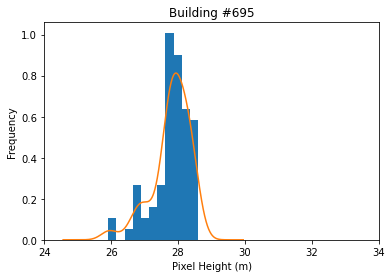

29.9300003051758 32.3199996948242 31.7800006866455 31.74933702247578


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


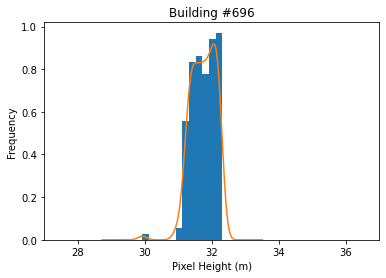

36.5800018310547 41.3499984741211 39.7900009155273 39.5701762464078


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


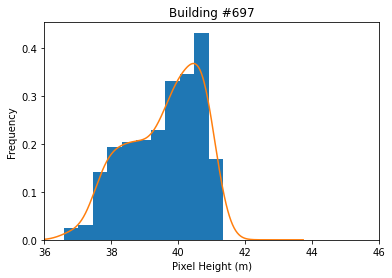

37.2900009155273 39.0900001525879 38.57999992370605 38.580964841340716


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


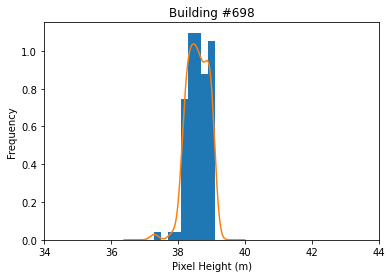

25.1399993896484 28.0599994659424 25.4599990844727 25.854178888298005


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


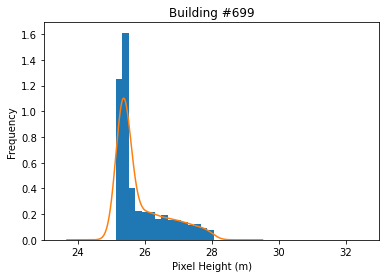

41.0099983215332 46.8899993896484 44.2200012207031 44.2799280784113


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


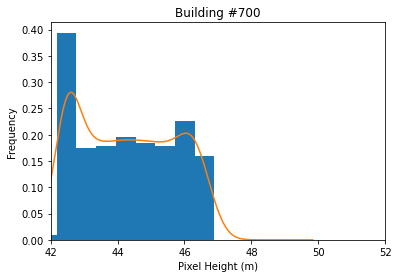

30.6900005340576 37.7700004577637 33.9900016784668 33.94466176634515


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


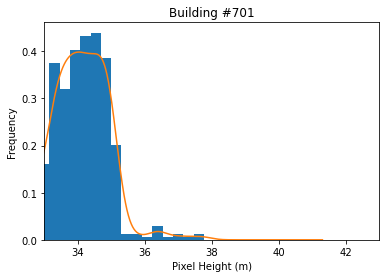

31.1399993896484 40.2900009155273 37.7299995422363 37.18983340355027


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


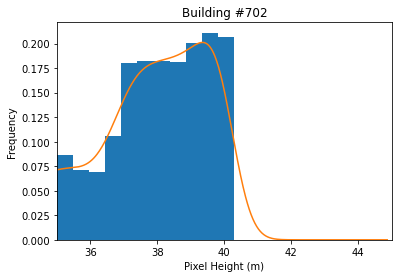

33.9700012207031 42.1599998474121 39.8899993896484 39.80686557032481


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


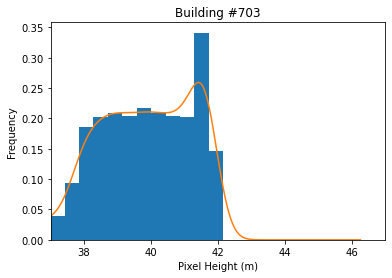

26.5 29.5799999237061 29.4599990844727 29.229835687924737


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


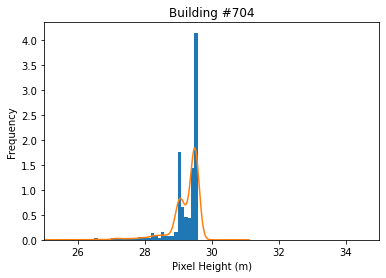

37.6699981689453 41.8400001525879 40.5200004577637 40.42915354637026


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


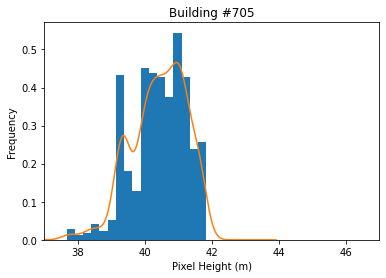

45.1800003051758 50.8800010681152 48.5400009155273 48.40393718877294


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


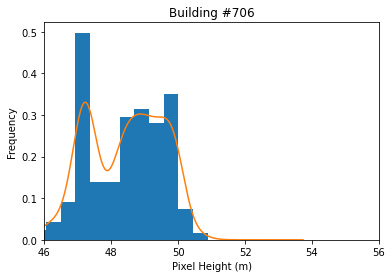

50.5200004577637 62.0999984741211 52.560001373291 52.96687498357561


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


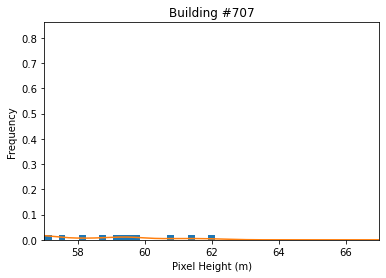

37.4799995422363 41.4199981689453 40.0800018310547 40.01065120890241


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


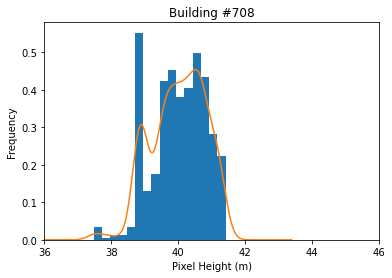

25.9500007629395 29.3400001525879 28.77000045776365 28.71456531856371


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


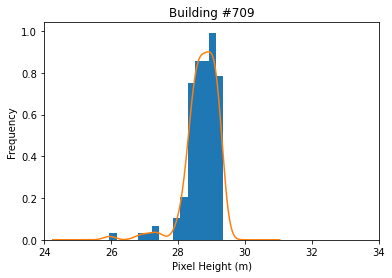

27.5300006866455 31.4899997711182 29.9899997711182 29.681336059261437


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


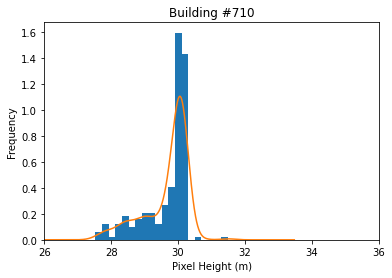

41.5200004577637 49.8300018310547 47.6100006103516 46.696813964843756


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


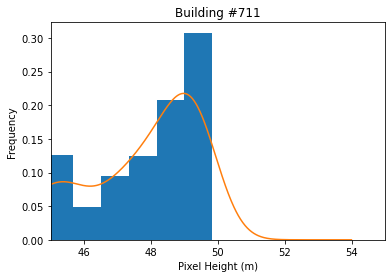

49.5099983215332 70.9899978637695 60.2700004577637 60.60328950380024


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


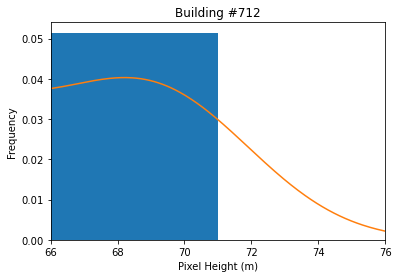

37.3199996948242 41.0800018310547 39.9599990844727 39.909788826576886


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


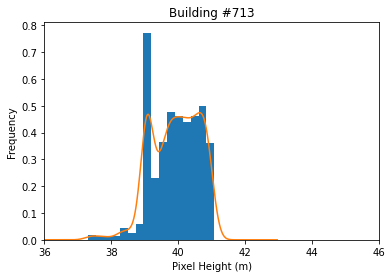

28.1299991607666 30.3099994659424 29.3600006103516 29.363274832682773


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


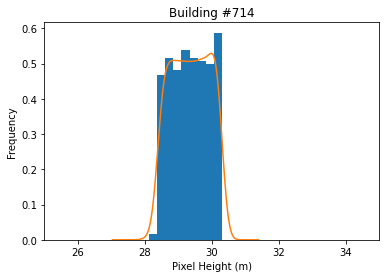

34.6399993896484 37.1199989318848 36.6500015258789 36.50922476598459


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


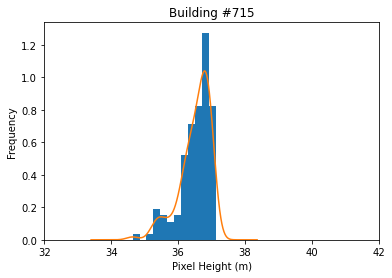

66.0699996948242 76.7900009155274 69.2699966430664 69.23319782702451


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


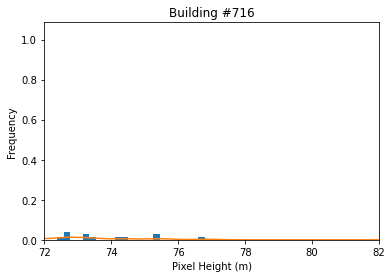

27.6499996185303 34.8699989318848 29.2550001144409 29.422926239154307


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


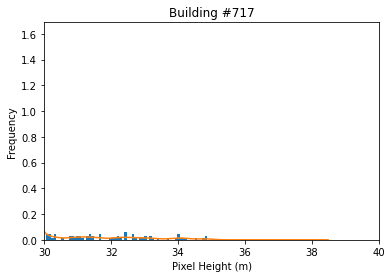

32.0699996948242 37.3800010681152 36.17499923706055 36.044730658483026


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


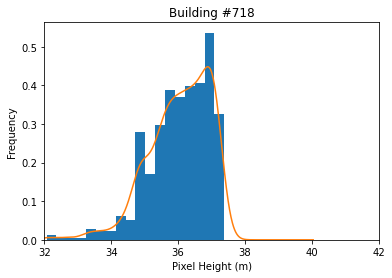

33.1300010681152 39.9900016784668 36.789999008178754 36.99846163303894


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


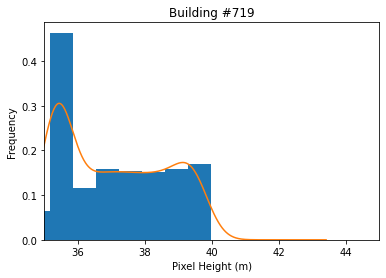

26.0 29.920000076294 28.3400001525879 28.228561206323214


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


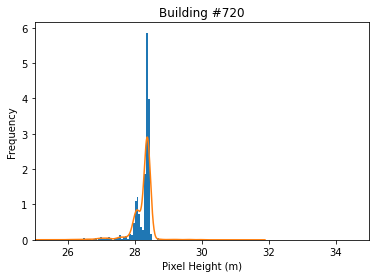

44.0200004577637 47.7400016784668 47.0049991607666 46.88882349051681


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


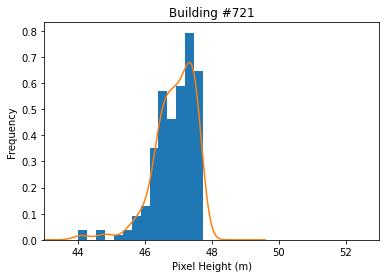

38.0499992370606 42.4599990844727 41.0200004577637 40.98432466901582


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


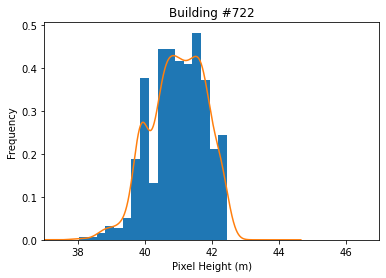

34.8499984741211 38.8199996948242 36.7099990844727 36.70044522442567


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


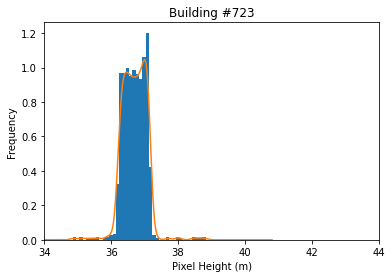

31.170000076294 37.2299995422363 36.6399993896484 36.451891153111504


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


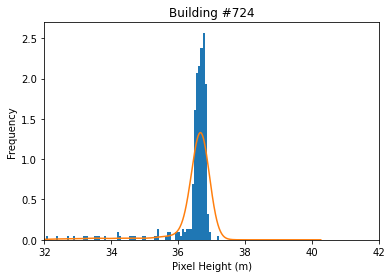

27.3500003814697 34.8699989318848 32.0999984741211 32.07126353707985


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


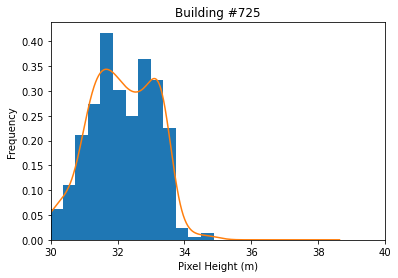

35.7700004577637 45.1199989318848 42.5099983215332 41.83896036036921


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


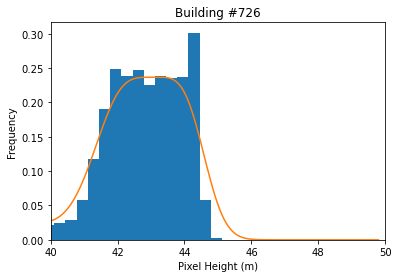

35.1699981689453 39.4599990844727 37.5999984741211 37.64808847026614


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


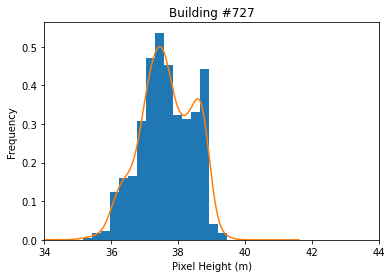

37.9199981689453 43.9099998474121 41.6149997711182 41.453515653808914


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


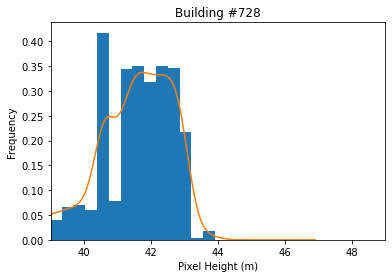

14.0600004196167 27.9200000762939 16.0499992370605 16.5367826047151


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


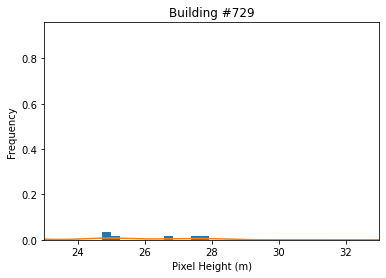

31.75 37.060001373291 36.7700004577637 36.59405717032296


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


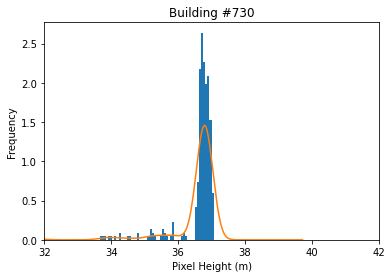

25.6100006103516 28.7700004577637 28.2399997711182 28.21325448843149


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


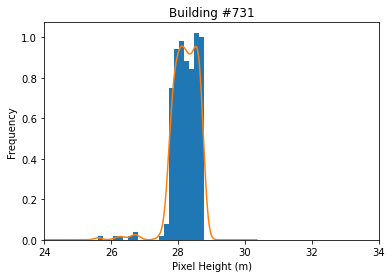

36.1599998474121 40.1699981689453 38.810001373291 38.74654717295229


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


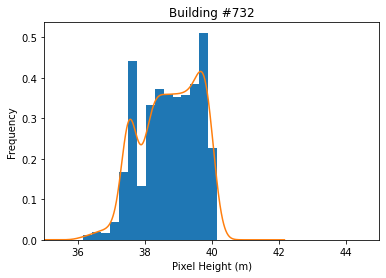

32.0200004577637 37.9199981689453 37.5800018310547 37.25265356948256


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


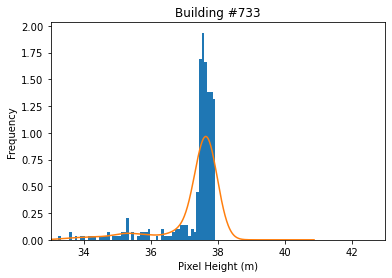

35.0999984741211 39.560001373291 39.2400016784668 39.04073877768083


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


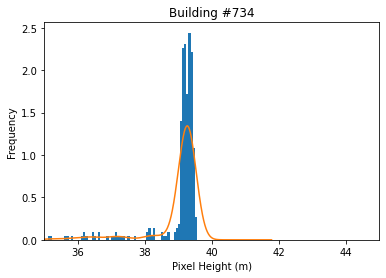

33.8199996948242 38.439998626709 37.23500061035155 37.170331305768116


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


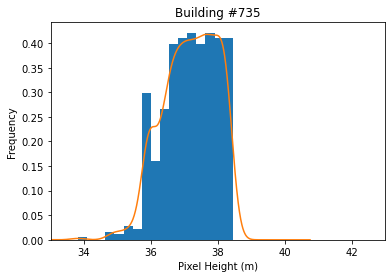

26.3600006103516 27.3899993896484 27.3149995803833 27.248709586358846


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


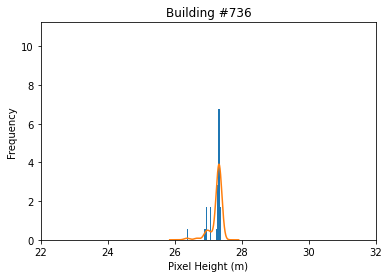

33.2299995422363 42.9300003051758 41.2000007629395 40.4919284126722


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


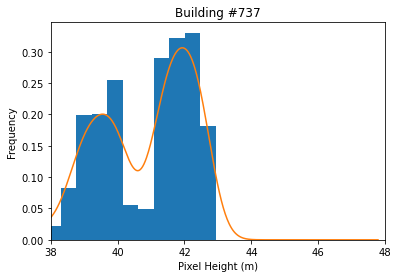

35.5200004577637 37.2999992370606 37.2700004577637 37.14860849795135


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


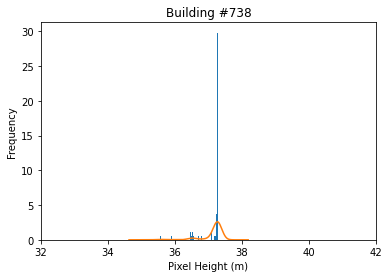

38.5 41.2400016784668 40.4799995422363 40.327860742066036


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


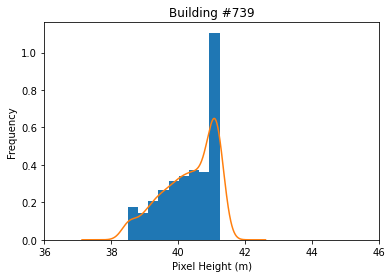

22.4099998474121 30.25 28.3999996185303 28.36034092939262


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


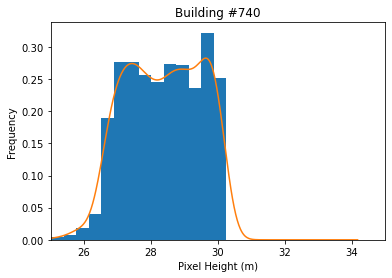

28.1000003814697 33.0099983215332 31.60500049591065 31.602897119522094


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


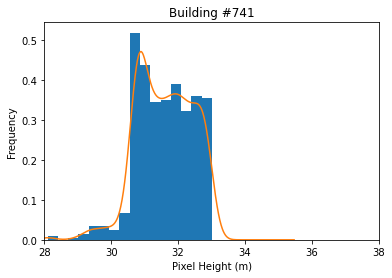

34.4599990844727 40.689998626709 38.8800010681152 38.728199676991444


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


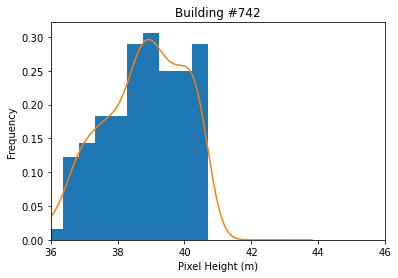

35.9300003051758 41.7099990844727 41.4349994659424 41.1944231410603


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


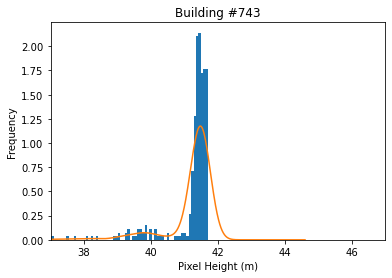

48.0800018310547 55.7799987792969 54.1699981689453 53.61956353242651


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


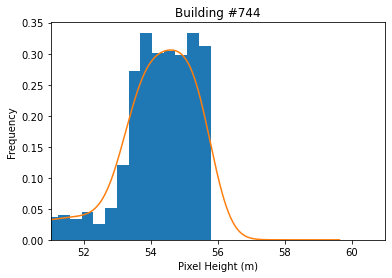

0.0 28.9400005340576 21.1299991607666 19.506560337526953


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


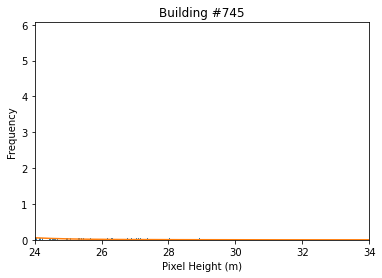

45.8800010681152 52.6500015258789 50.7900009155274 50.75315260599895


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


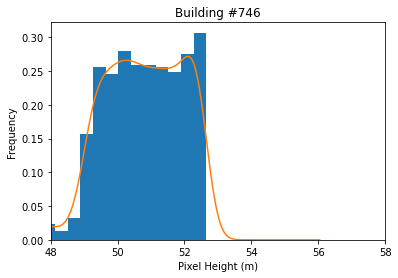

0.0 45.8199996948242 43.9500007629395 42.30669227013221


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


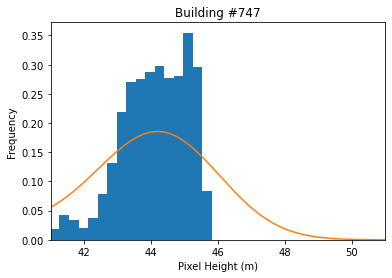

42.9500007629395 45.1800003051758 44.810001373291 44.70907145908901


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


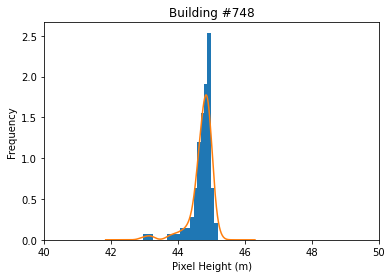

19.8299999237061 21.9400005340576 21.2999992370606 21.20071769787364


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


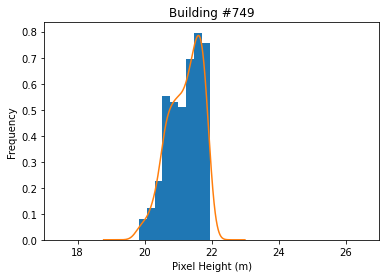

28.7999992370606 36.75 35.3800010681152 35.11157546915582


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


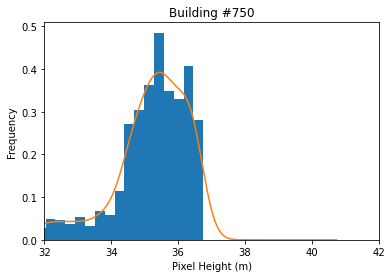

32.0200004577637 37.0299987792969 35.2749996185303 35.25860201261506


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


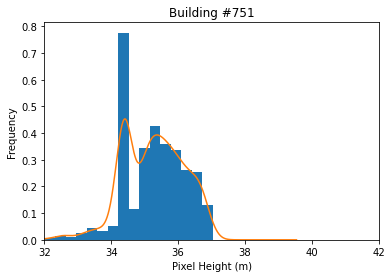

39.1500015258789 45.8499984741211 45.0999984741211 44.877060582462605


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


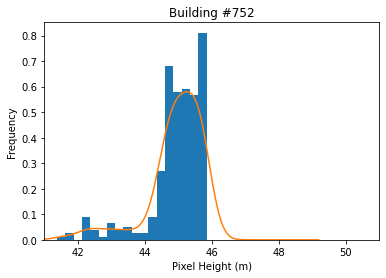

50.7900009155274 74.0800018310547 54.8499984741211 54.76613748550415


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


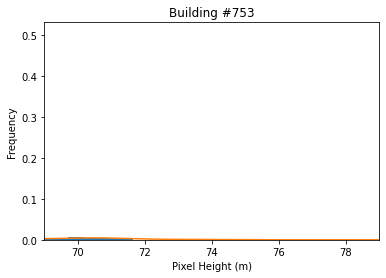

37.9599990844727 43.2599983215332 42.1300010681152 42.038847625255585


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


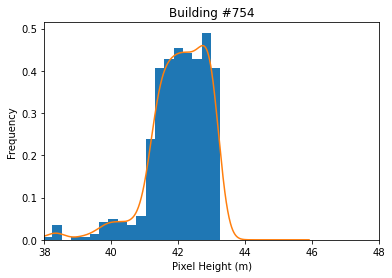

36.5400009155273 41.6500015258789 40.5200004577637 40.39376846313476


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


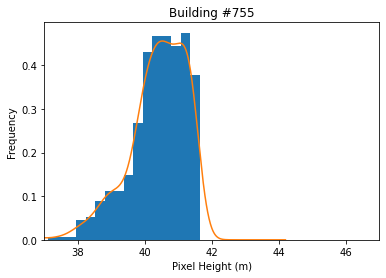

45.8400001525879 52.9199981689453 50.1800003051758 49.876444242426


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


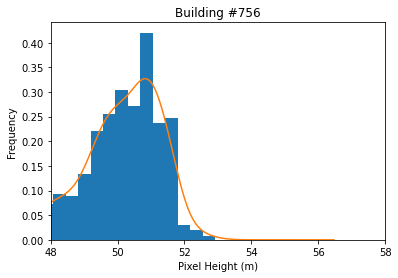

35.4799995422363 40.75 38.6100006103516 38.4494686886753


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


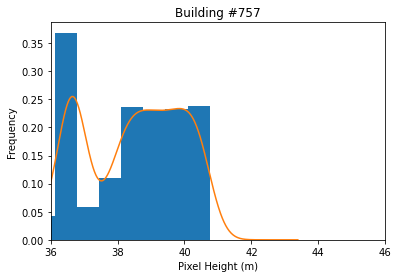

27.2399997711182 29.0400009155273 28.5599994659424 28.407738680815587


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


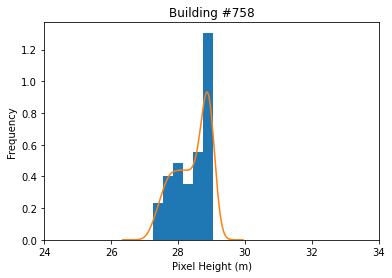

40.0499992370605 46.2900009155274 43.5099983215332 43.400865408090446


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


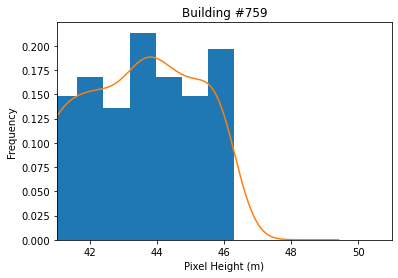

35.1199989318848 41.310001373291 38.8899993896484 38.86464343221232


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


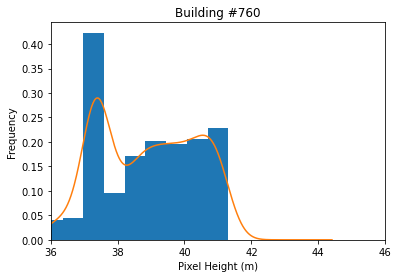

27.2099990844727 33.4700012207031 31.6399993896484 30.853902506634473


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


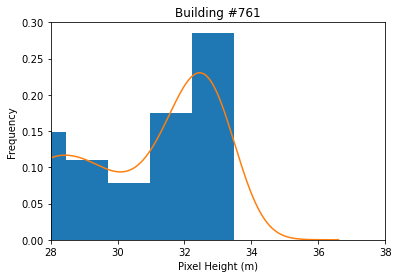

13.1899995803833 22.4699993133545 20.6299991607666 20.45133877061104


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


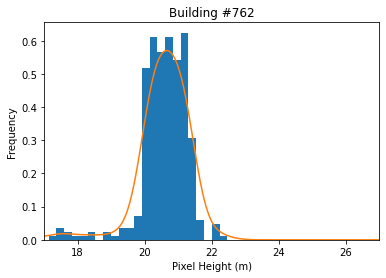

26.7900009155273 30.0300006866455 28.9799995422363 28.951343242208758


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


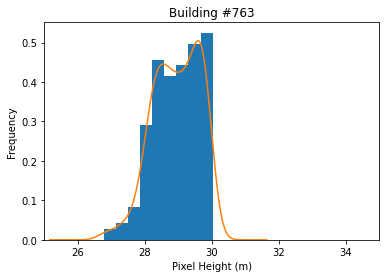

44.8600006103516 49.3199996948242 48.310001373291 48.189153439153436


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


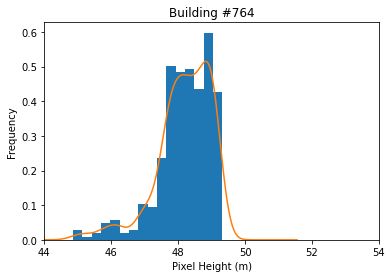

36.0099983215332 52.0400009155274 40.51499938964845 41.05714284157267


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


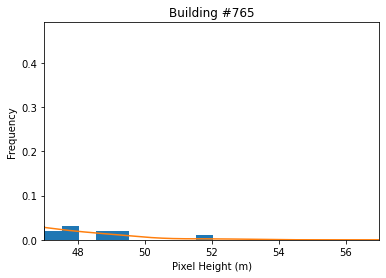

38.1300010681152 41.6399993896484 40.25 40.208164180926424


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


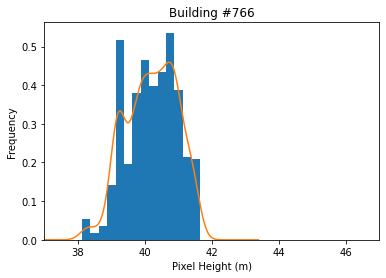

27.1499996185303 30.0699996948242 29.4200000762939 29.379067800812802


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


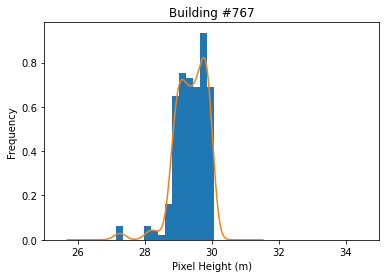

31.0499992370606 37.9099998474121 33.73500061035155 34.52247403154737


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


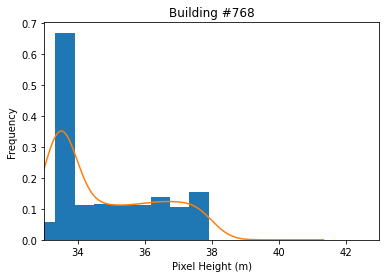

38.810001373291 40.8800010681152 40.3800010681152 40.280803612300325


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


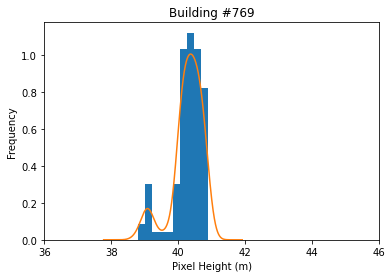

29.6100006103516 38.8800010681152 37.4050006866455 37.200760493260375


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


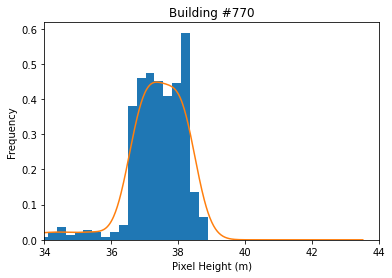

43.2999992370605 54.0200004577637 50.4900016784668 50.113475723483965


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


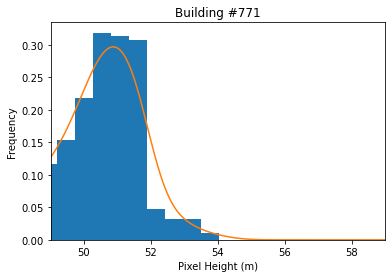

48.9300003051758 55.6199989318848 53.4700012207031 52.964680648431546


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


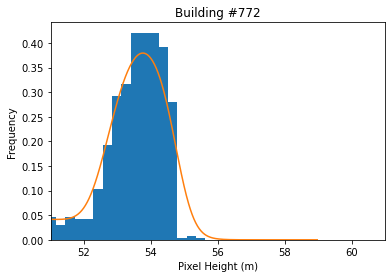

35.5499992370606 39.0699996948242 37.5900001525879 37.54614141205106


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


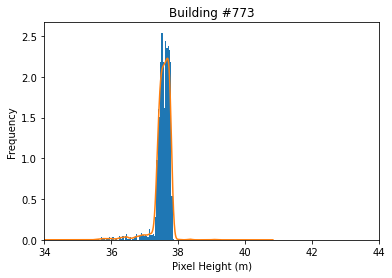

0.0 27.1399993896484 26.9500007629395 17.94968996861185


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


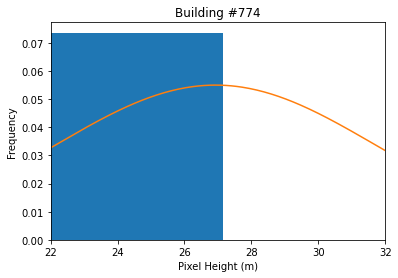

34.0900001525879 39.9000015258789 39.1199989318848 38.93058598762974


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


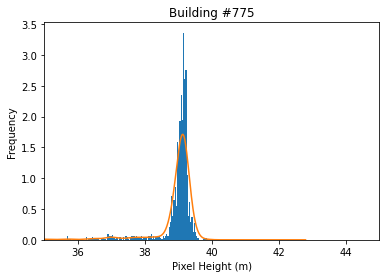

34.7700004577637 40.2299995422363 38.6149997711182 38.52159520103819


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


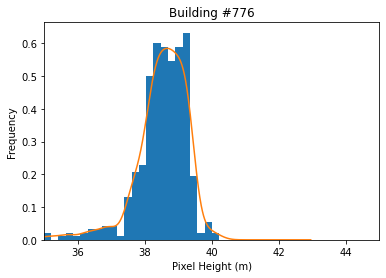

42.189998626709 46.9300003051758 45.8800010681152 45.74496035211004


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


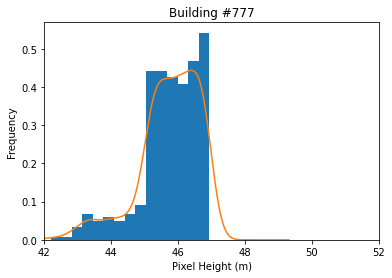

62.7400016784668 65.7799987792969 63.4799995422363 63.54806463180051


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


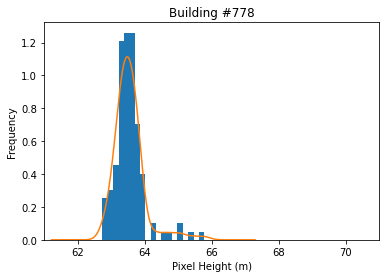

30.2299995422363 34.4300003051758 33.4099998474121 33.12326046376847


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


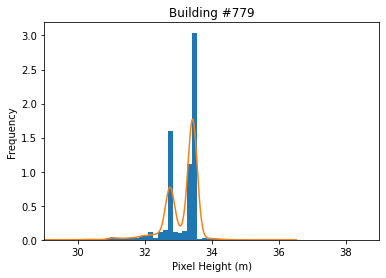

24.0400009155273 33.4099998474121 31.0499992370606 30.696925250700406


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


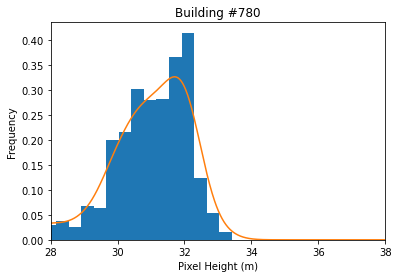

0.0 42.5099983215332 39.3199996948242 38.481593424015784


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


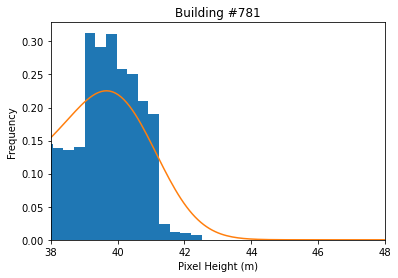

43.0400009155273 45.1399993896484 44.7599983215332 44.712704352612775


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


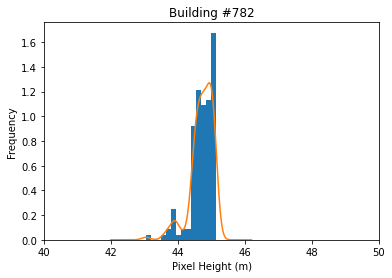

0.0 36.1500015258789 32.2099990844727 22.53574612623865


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


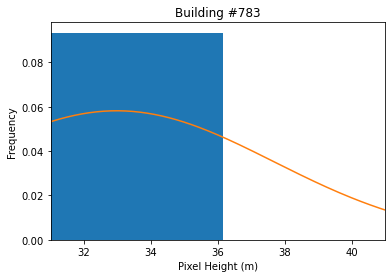

43.0200004577637 44.9799995422363 44.2599983215332 44.20985914955678


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


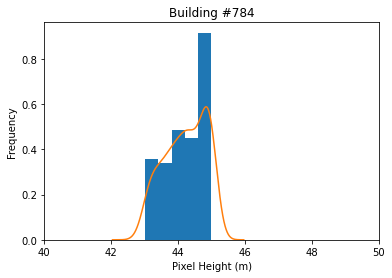

41.2200012207031 46.2599983215332 45.1100006103516 44.87244935625055


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


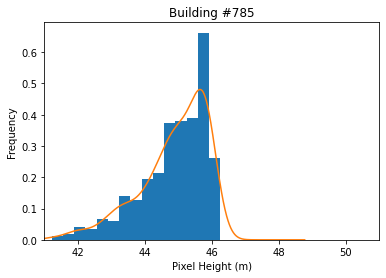

26.3700008392334 29.6599998474121 28.3400001525879 28.215294080622062


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


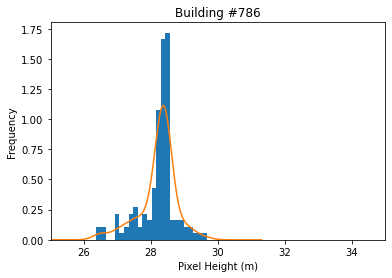

32.3800010681152 36.9500007629395 36.4700012207031 36.29861267178046


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


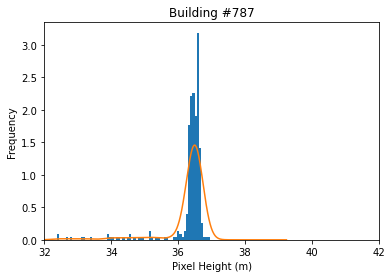

36.2799987792969 42.5699996948242 41.4799995422363 40.85124401840867


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


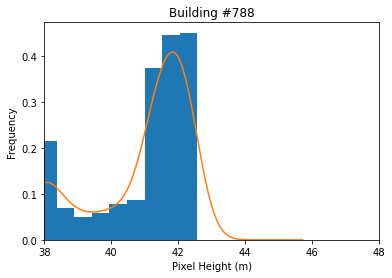

45.2200012207031 46.9000015258789 46.3199996948242 46.280609227679115


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


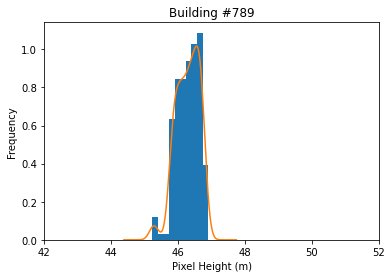

45.6300010681152 48.810001373291 48.0400009155274 47.962177189694174


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


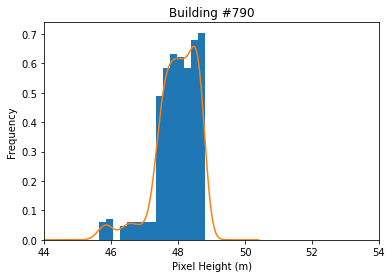

28.9699993133545 37.0099983215332 30.7000007629395 31.50139987945558


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


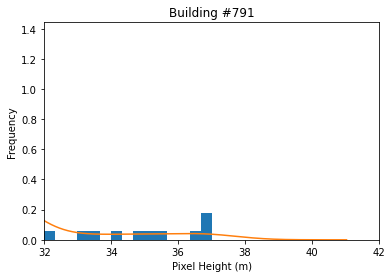

25.7299995422363 29.1100006103516 28.6200008392334 28.25569029873303


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


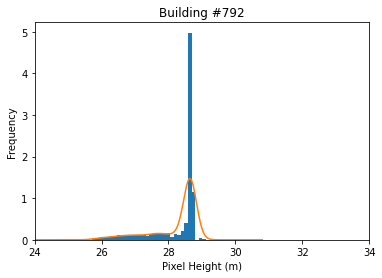

25.9099998474121 36.1599998474121 32.7599983215332 32.40122507739542


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


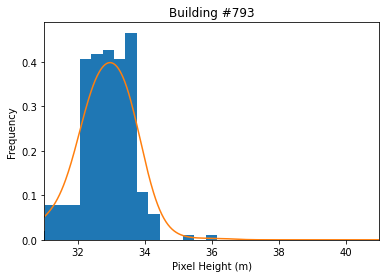

28.4200000762939 35.0400009155273 33.2299995422363 33.088429659851336


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


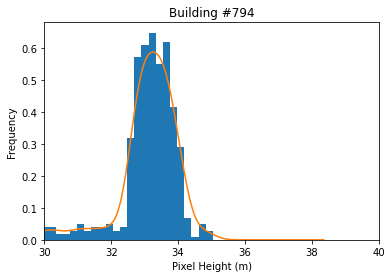

42.4500007629395 43.3899993896484 42.560001373291 42.61172098559001


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


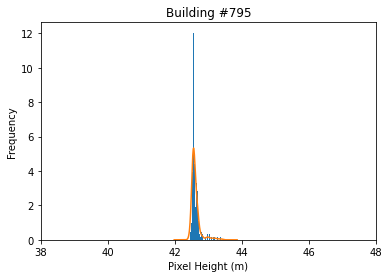

33.2000007629395 37.0699996948242 36.7700004577637 36.64437500997023


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


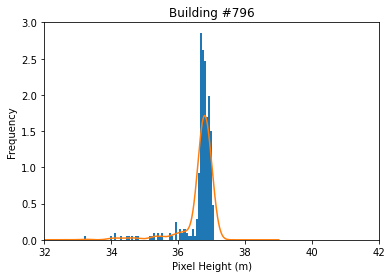

39.8600006103516 41.939998626709 41.5699996948242 41.497471140719014


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


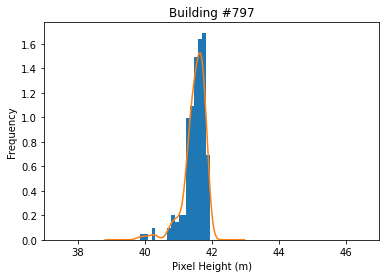

25.5200004577637 27.8600006103516 26.4799995422363 26.439814655869103


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


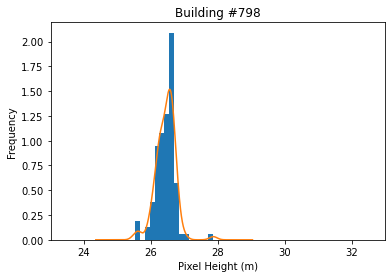

42.8800010681152 50.9599990844727 47.9599990844727 47.156107703658016


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


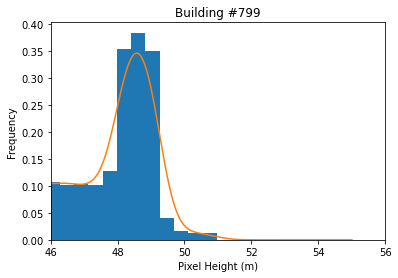

8.07999992370606 12.4099998474121 11.39499998092655 11.12342423814716


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


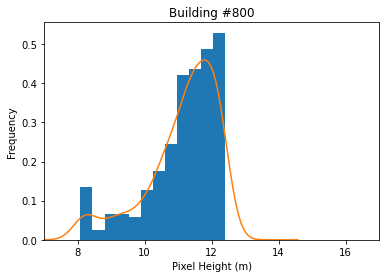

39.8600006103516 45.2099990844727 41.9599990844727 41.82239619002175


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


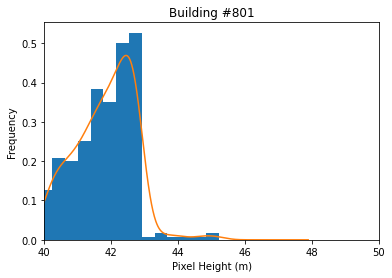

28.9400005340576 34.0499992370606 30.0400009155273 30.062054523121233


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


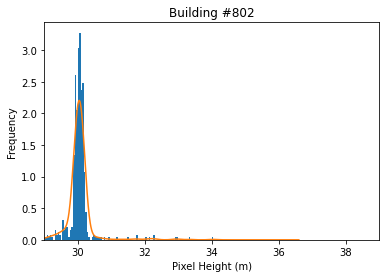

30.6299991607666 34.0099983215332 31.6900005340576 31.78805263251589


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


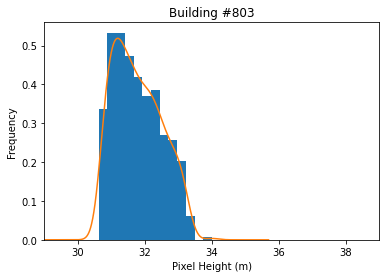

0.0 33.0400009155273 29.0900001525879 25.254307702871476


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


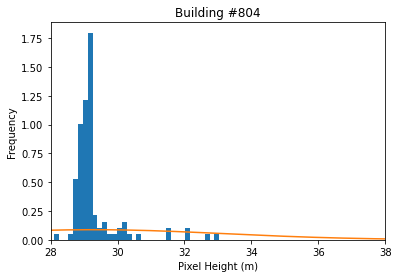

33.6500015258789 40.1699981689453 37.60999870300295 37.53437033759223


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


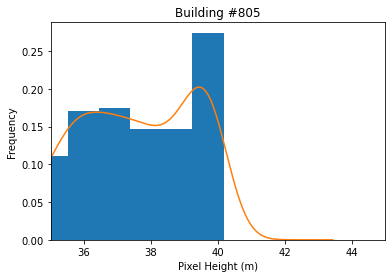

22.2099990844727 30.6399993896484 28.3500003814697 27.822832537369


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


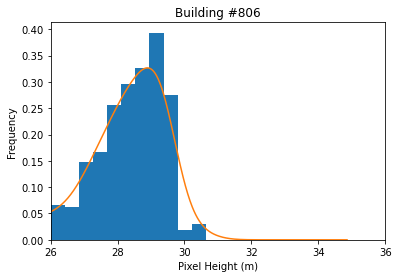

35.5499992370606 40.060001373291 38.5800018310547 38.552648760441684


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


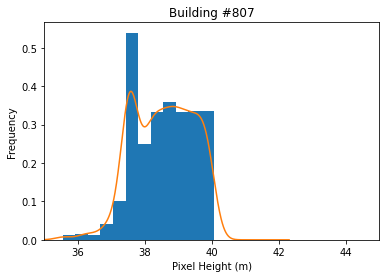

0.0 58.189998626709 49.4700012207031 50.09483249792071


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


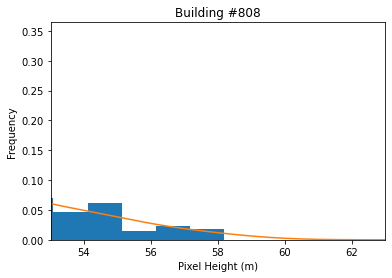

20.1700000762939 28.2000007629395 27.1599998474121 26.577891228369754


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


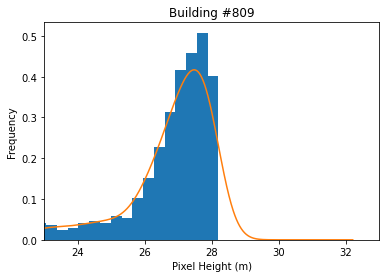

28.5400009155273 33.4900016784668 32.39500045776365 32.28821306130321


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


36.8400001525879 41.5699996948242 39.6300010681152 39.659304455743325


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


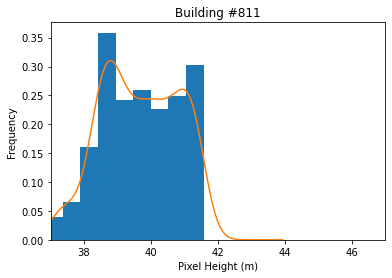

38.9900016784668 42.4900016784668 40.2999992370606 40.530999755859376


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


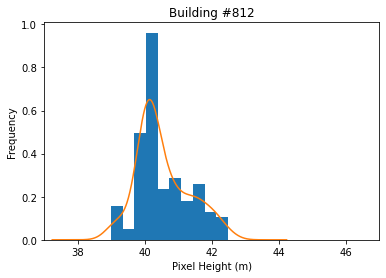

35.0299987792969 38.5400009155273 38.0699996948242 37.94522848946708


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


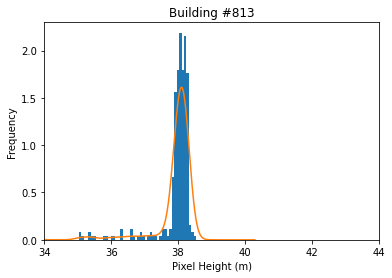

44.7799987792969 46.0800018310547 45.7799987792969 45.68107148579189


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


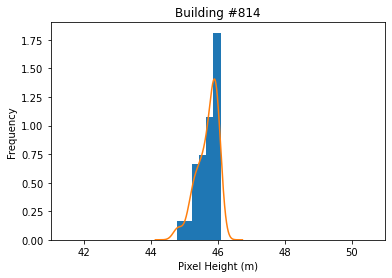

35.0400009155273 47.3600006103516 38.0 37.994511599873384


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


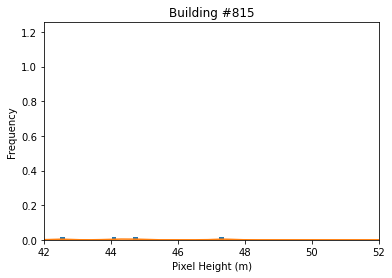

33.0400009155273 41.6300010681152 38.23500061035155 38.27519073324689


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


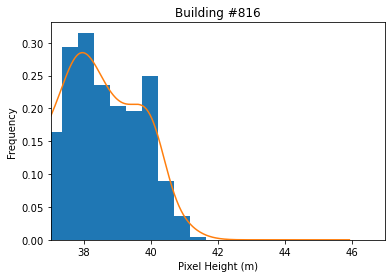

31.5799999237061 42.9900016784668 39.060001373291 39.10469872941075


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


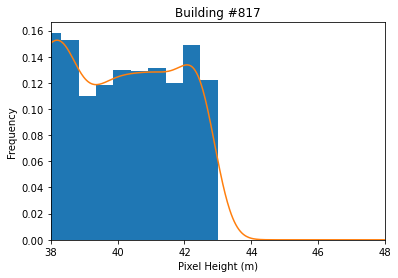

41.2299995422363 47.560001373291 44.7999992370606 44.759893877752894


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


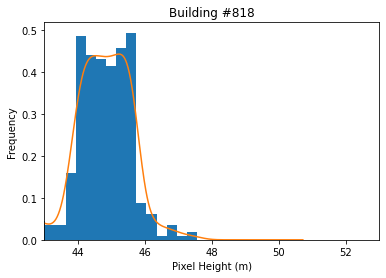

23.1900005340576 29.9099998474121 28.9949998855591 28.4879936291154


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


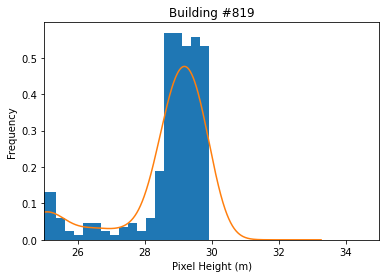

20.4300003051758 32.6500015258789 24.7700004577637 26.578692964498437


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


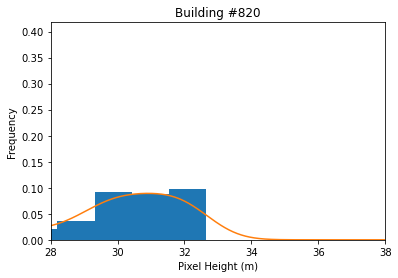

21.5499992370605 26.1800003051758 23.0699996948242 23.224987788686764


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


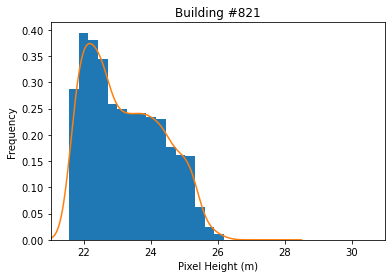

37.2299995422363 39.9300003051758 38.9500007629395 38.90492114960583


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


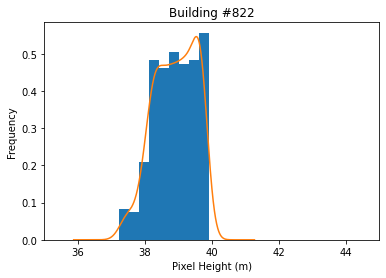

38.3899993896484 39.7099990844727 39.6500015258789 39.54902432604534


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


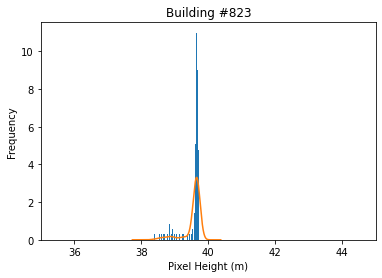

19.5599994659424 26.7199993133545 21.704999923706048 21.73947153634172


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


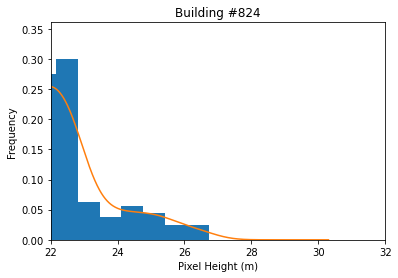

43.9900016784668 59.810001373291 46.4750003814697 48.034107140132356


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


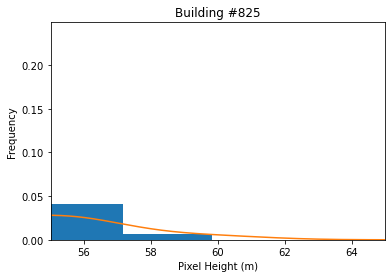

29.9300003051758 40.810001373291 38.98500061035155 38.81747865270484


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


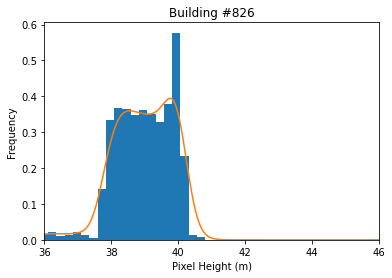

45.4199981689453 48.3800010681152 46.310001373291 46.44547014154939


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


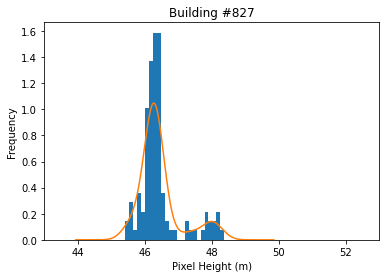

0.0 34.2799987792969 34.0999984741211 29.537869538030318


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


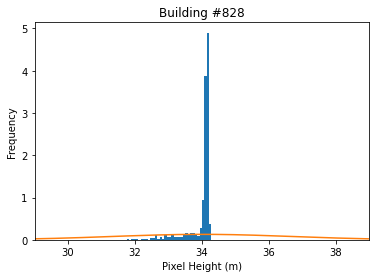

16.7999992370605 25.9599990844727 24.2299995422363 24.169337668497064


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


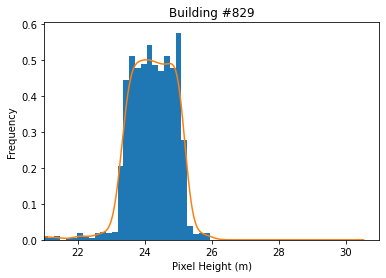

39.5499992370605 41.5400009155273 41.1199989318848 41.06301063619634


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


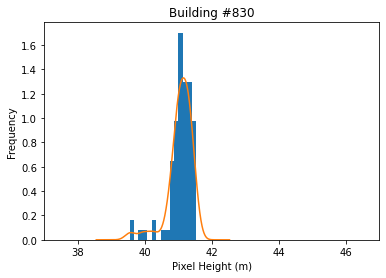

38.4799995422363 40.2400016784668 39.9199981689453 39.850450292363895


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


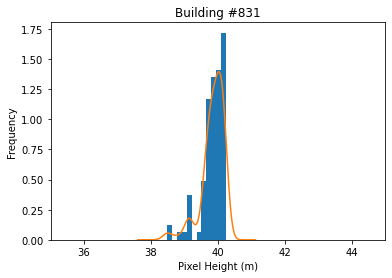

0.0 39.5400009155273 38.3499984741211 30.773452528307974


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


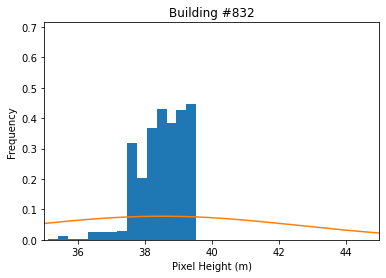

37.7299995422363 42.2999992370606 40.2299995422363 40.19274318282669


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


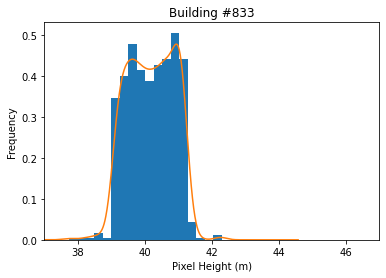

43.8600006103516 48.9900016784668 48.0900001525879 47.80763437414682


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


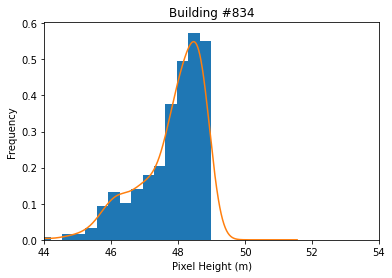

34.9000015258789 41.0 38.8899993896484 38.681728163043275


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


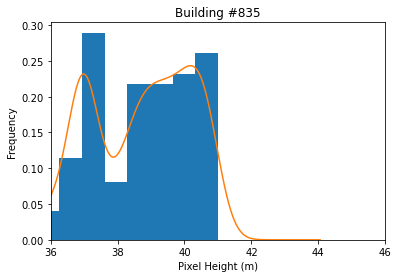

24.4500007629395 29.2800006866455 27.5100002288818 27.57231885852623


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


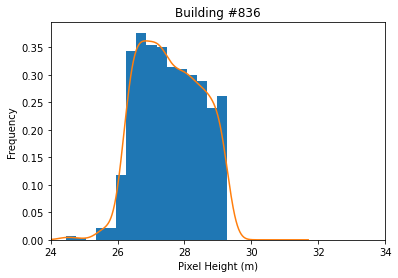

21.2299995422363 24.3600006103516 22.2249994277954 22.536428560529437


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


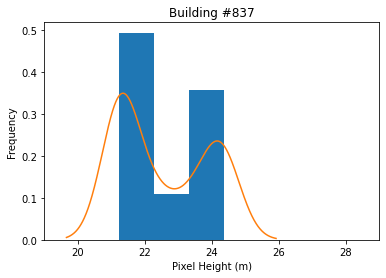

45.9500007629395 48.2999992370606 47.3150005340576 47.292045506564065


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


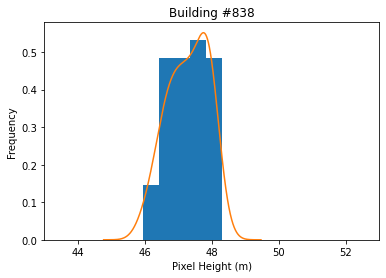

31.4500007629395 36.6300010681152 35.8300018310547 35.52895559405533


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


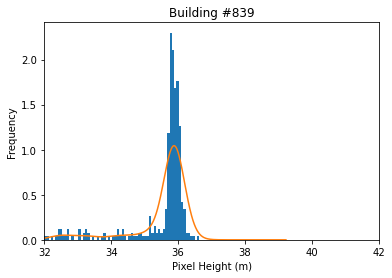

26.1399993896484 30.9200000762939 29.7800006866455 29.71265056826777


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


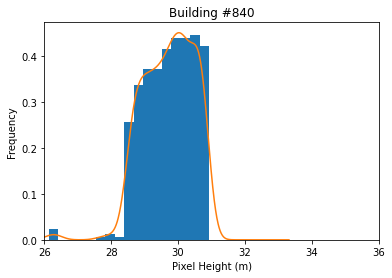

28.8600006103516 33.2000007629395 32.1300010681152 32.088458821151384


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


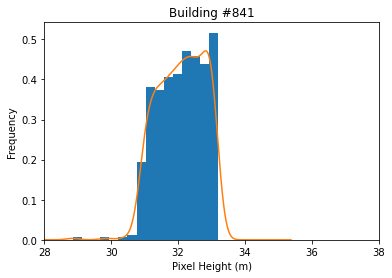

27.7900009155273 42.25 39.0200004577637 38.715553083816985


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


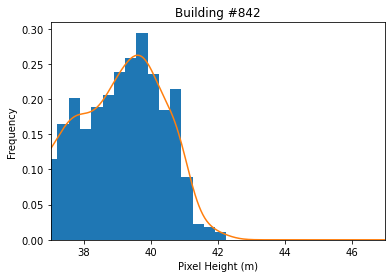

24.9899997711182 32.9300003051758 29.3999996185303 29.2868008666924


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


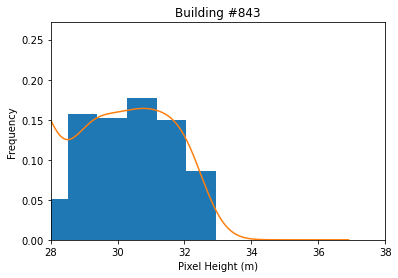

0.0 40.8400001525879 38.2400016784668 36.82842320647256


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


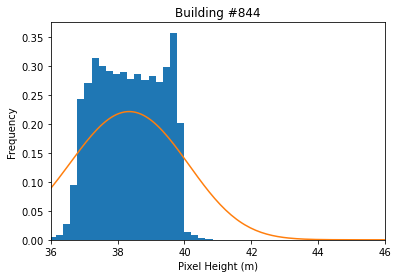

24.4500007629395 35.0900001525879 33.9900016784668 33.8735930777966


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


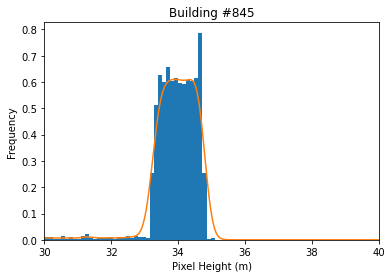

33.6399993896484 39.2299995422363 38.310001373291 38.08908952820102


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


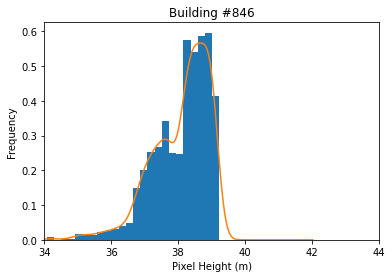

39.2400016784668 44.3899993896484 43.5499992370606 43.30861201722539


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


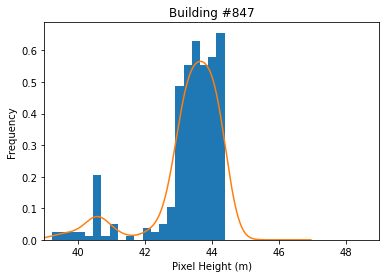

46.25 49.9300003051758 48.9000015258789 48.888610704264856


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


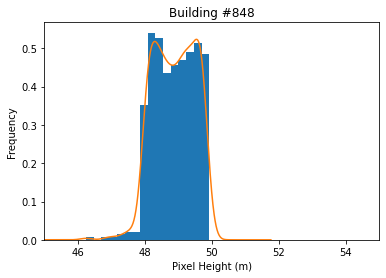

30.0300006866455 36.4900016784668 35.4799995422363 35.36390309456067


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


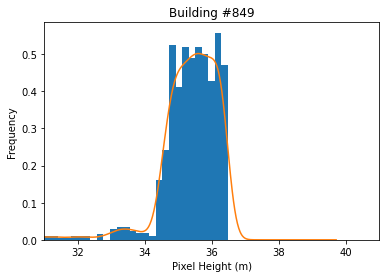

25.1000003814697 28.670000076294 25.8899993896484 26.249363179476763


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


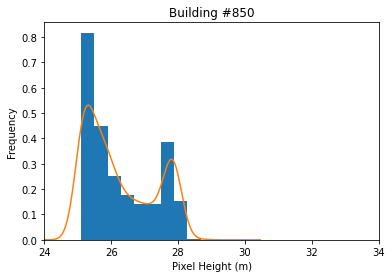

38.7799987792969 41.6699981689453 41.1399993896484 40.9229357308204


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


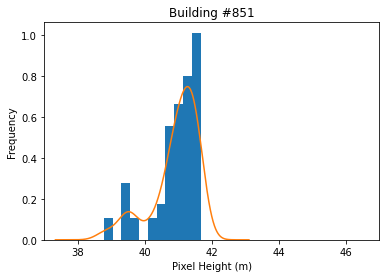

24.5300006866455 47.0099983215332 44.4199981689453 43.82596208732625


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


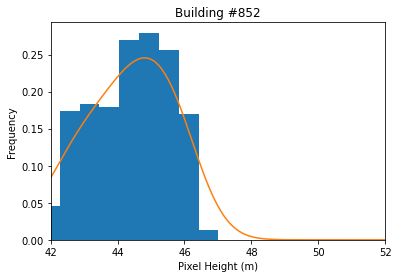

31.1599998474121 33.9099998474121 33.560001373291 33.42454262236885


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


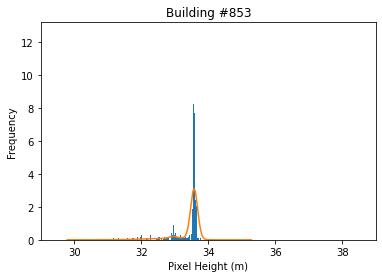

42.7000007629395 46.4799995422363 45.4599990844727 45.431732484997234


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


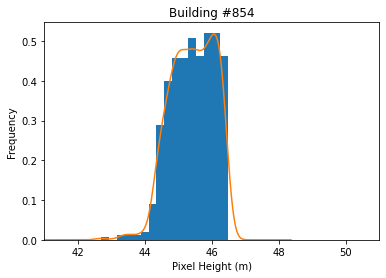

24.8899993896484 26.6200008392334 25.9200000762939 25.876050356055515


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


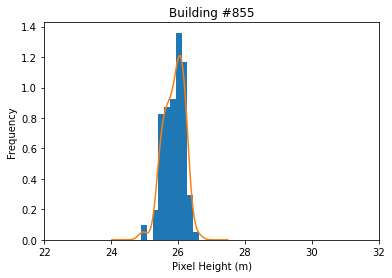

36.2700004577637 41.3899993896484 39.10499954223635 39.546672395712825


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


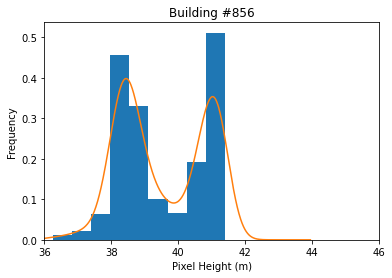

33.6699981689453 60.3800010681152 57.66500091552735 56.862243284681426


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


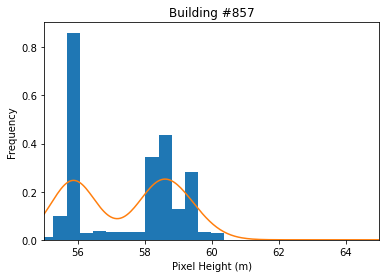

27.7999992370606 35.3199996948242 32.9900016784668 32.72359076245873


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


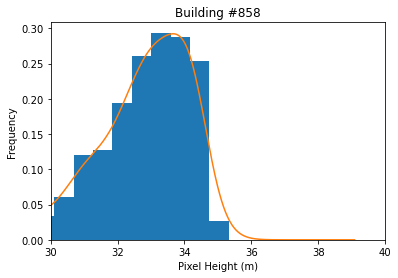

50.810001373291 54.5499992370606 53.8199996948242 53.5751588155353


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


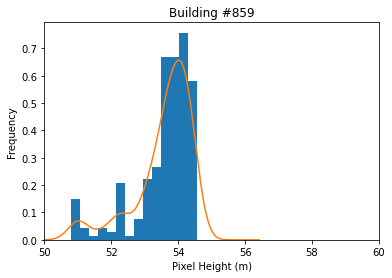

36.3499984741211 38.75 38.4349994659424 38.39204935167657


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


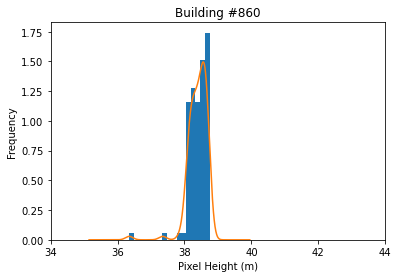

30.5200004577637 32.9099998474121 32.810001373291 32.555332590675114


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


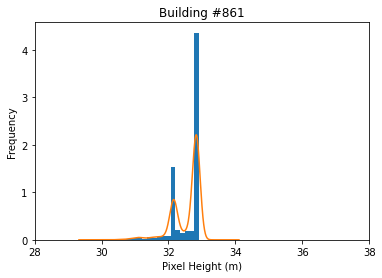

26.7399997711182 37.3800010681152 34.25 33.594694776341015


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


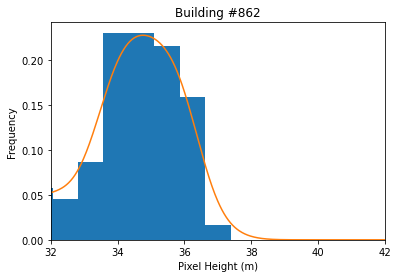

31.9899997711182 33.1800003051758 32.9300003051758 32.887590362364996


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


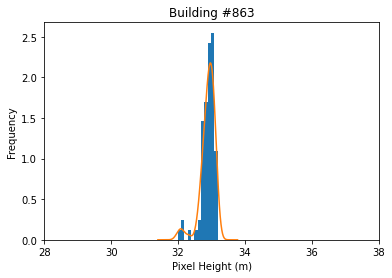

45.560001373291 47.0900001525879 46.9700012207031 46.7973831390666


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


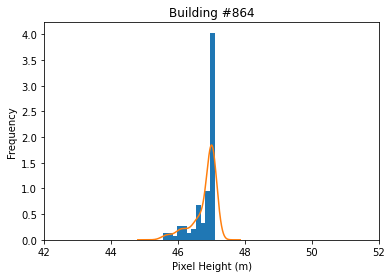

37.8300018310547 42.4700012207031 40.9149990081787 40.89200364140903


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


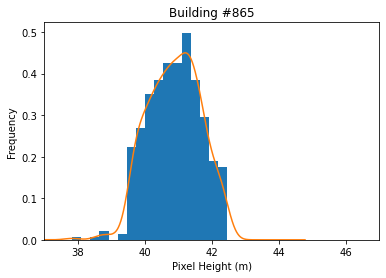

28.5300006866455 31.8700008392334 31.4799995422363 31.151063858194558


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


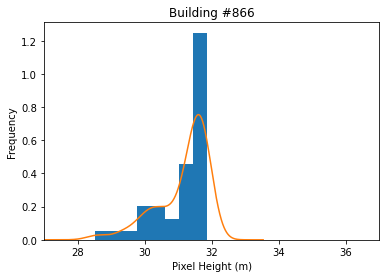

0.0 49.0299987792969 46.7700004577637 45.588239995320635


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


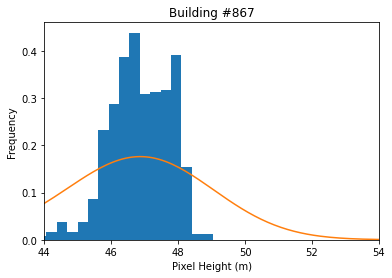

22.2399997711182 24.9400005340576 23.8700008392334 23.773714229038788


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


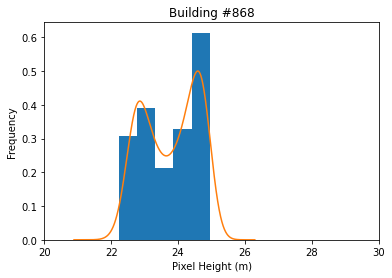

25.4799995422363 35.5900001525879 33.5499992370606 32.968144328323845


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


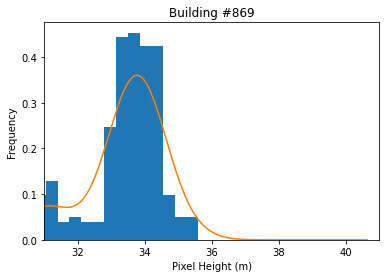

34.810001373291 42.7000007629395 37.9799995422363 38.12739957022309


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


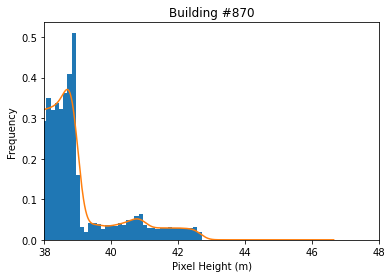

42.4099998474121 50.7400016784668 48.4199981689453 48.070115202098506


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


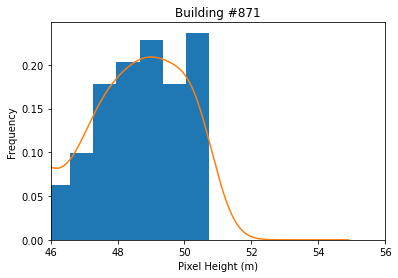

35.6100006103516 40.939998626709 38.3400001525879 38.417437985817095


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


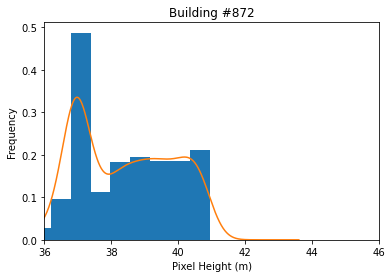

47.0699996948242 47.3899993896484 47.1800003051758 47.19081953705334


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


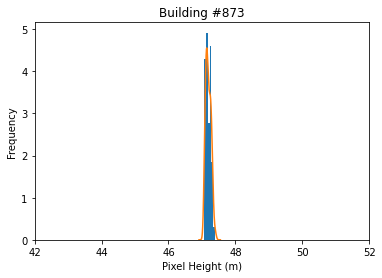

38.6300010681152 41.2799987792969 40.3499984741211 40.31558227028393


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


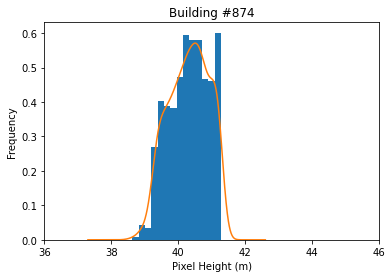

42.9099998474121 49.0099983215332 47.6500015258789 47.81483335040865


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


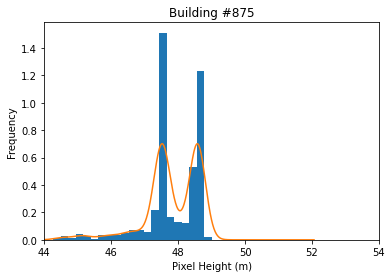

36.4199981689453 40.310001373291 39.0699996948242 39.06108832133681


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


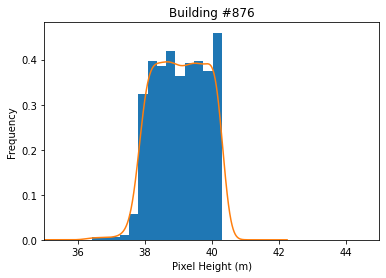

39.2599983215332 44.25 43.439998626709 43.27428123059745


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


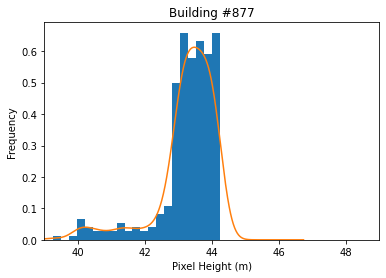

39.3699989318848 44.2400016784668 43.5 43.35067297862126


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


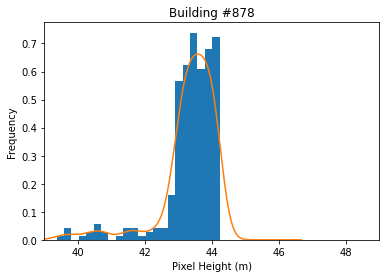

35.8800010681152 40.7999992370605 39.4799995422363 39.36418803397067


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


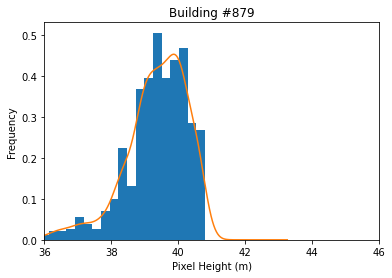

39.1300010681152 41.2799987792969 40.2599983215332 40.277368344758685


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


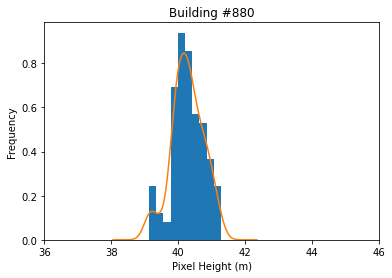

37.6599998474121 39.5900001525879 38.3499984741211 38.43422215779622


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


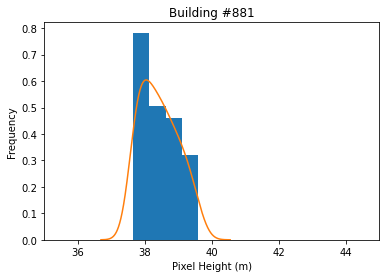

33.1300010681152 35.7400016784668 35.35499954223635 35.147263195640164


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


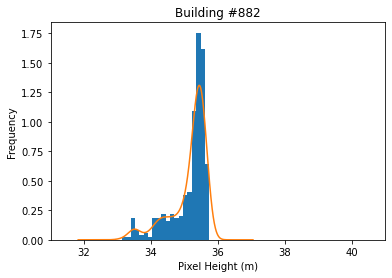

19.0900001525879 21.4799995422363 20.914999961853 20.87633924824851


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


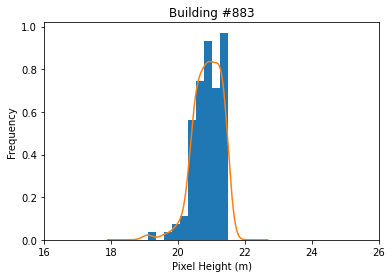

19.4099998474121 29.0 26.5799999237061 26.274230392592433


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


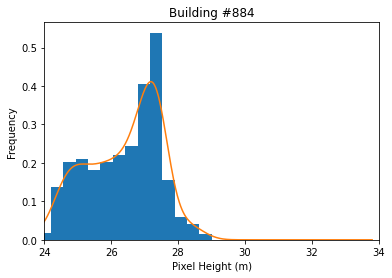

33.5999984741211 40.2700004577637 39.5400009155273 39.20928141885175


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


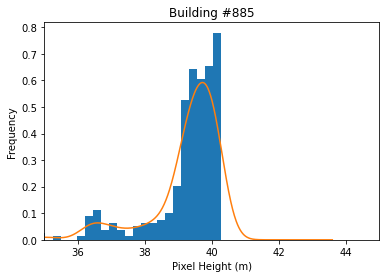

37.8400001525879 41.0699996948242 40.0850009918213 40.065090864354914


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


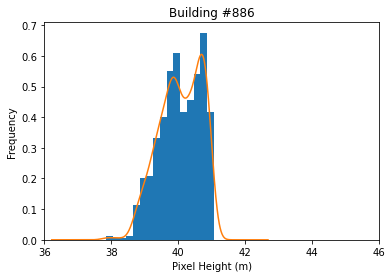

35.0200004577637 42.5299987792969 41.159999847412095 41.03267367680868


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


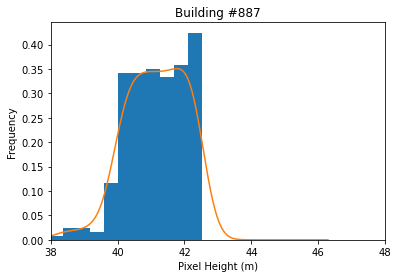

51.3899993896484 54.810001373291 53.8400001525879 53.39270539214645


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


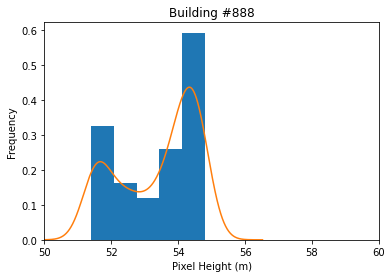

36.1500015258789 39.5999984741211 38.3400001525879 38.36008594290088


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


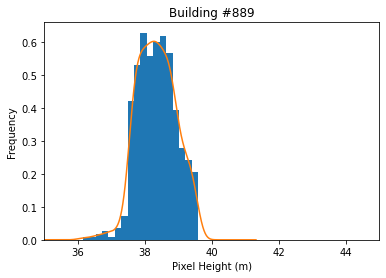

28.6000003814697 46.6399993896484 29.5900001525879 32.38583335422335


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


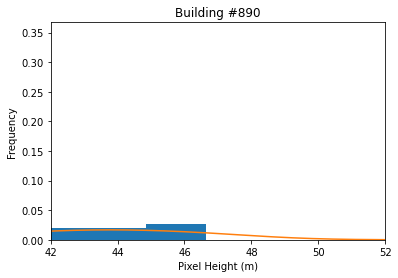

39.5299987792969 41.5299987792969 41.0699996948242 40.99839686619416


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


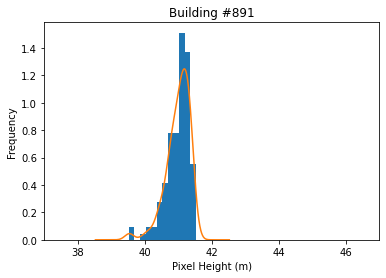

0.0 36.4300003051758 35.19499969482425 32.06944446074657


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


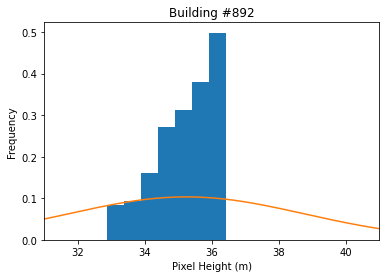

31.1499996185303 36.6100006103516 33.8400001525879 33.82163209242445


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


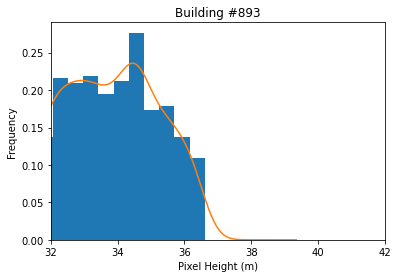

38.75 42.439998626709 41.1399993896484 41.167209741782756


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


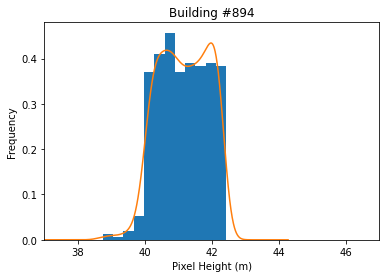

55.5 62.9199981689453 58.1300010681152 58.283600062320104


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


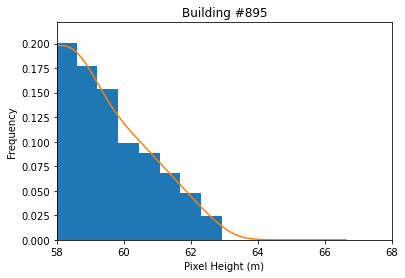

47.6399993896484 63.8899993896484 50.1300010681152 50.8129900276064


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


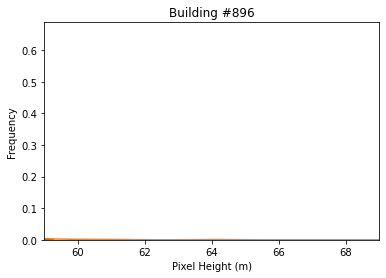

47.8300018310547 50.310001373291 49.8450012207031 49.57692315028264


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


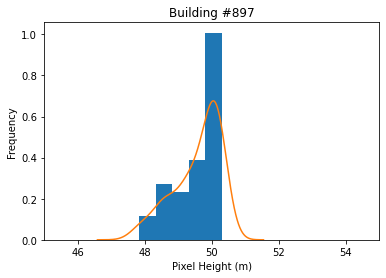

42.189998626709 45.2700004577637 45.1599998474121 44.79366667005751


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


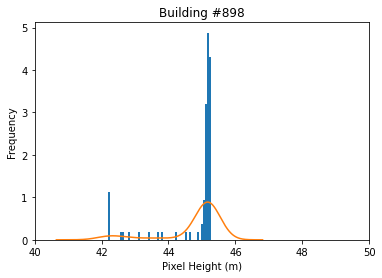

41.7000007629395 45.1399993896484 44.4700012207031 44.40842505062328


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


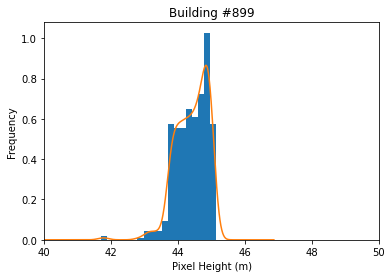

20.2399997711182 28.7399997711182 26.3799991607666 25.85038679207551


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


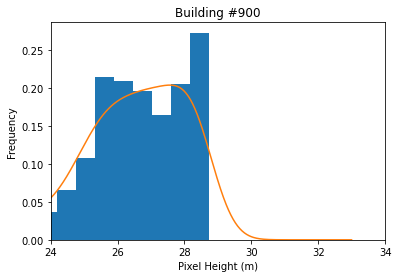

36.6300010681152 41.4099998474121 38.5999984741211 38.81265810074345


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


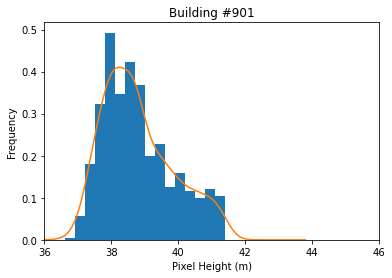

31.9400005340576 40.4300003051758 37.2400016784668 37.105310574763244


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


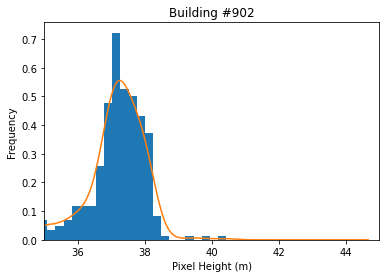

25.4400005340576 28.1399993896484 28.0400009155273 27.92620027309736


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


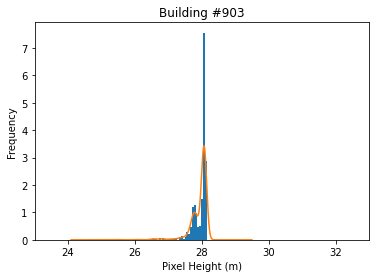

24.2299995422363 25.8600006103516 24.4899997711182 24.68923804873512


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


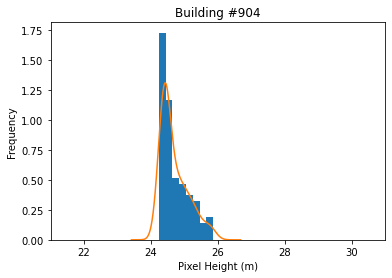

46.7099990844727 53.5099983215332 48.8400001525879 48.78044737630817


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


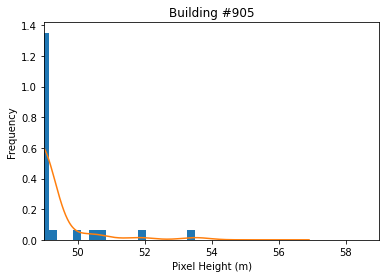

37.9599990844727 43.8300018310547 42.9549999237061 42.71858981939462


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


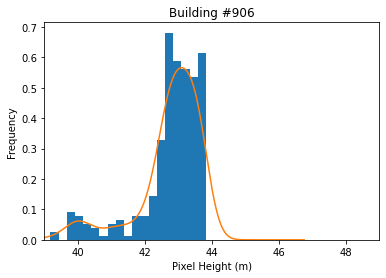

33.5800018310547 38.5 38.2000007629395 38.09977209194433


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


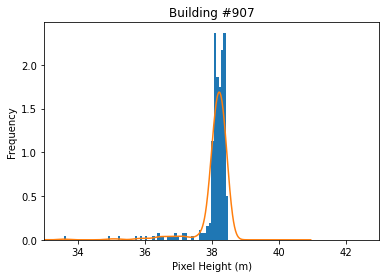

31.7199993133545 35.6500015258789 34.2299995422363 33.967153382127314


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


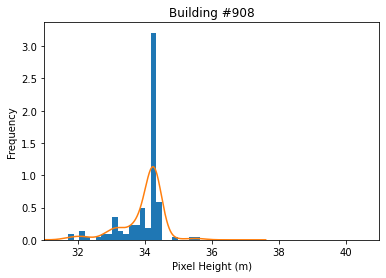

37.6599998474121 40.9700012207031 39.8199996948242 39.818697195097876


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


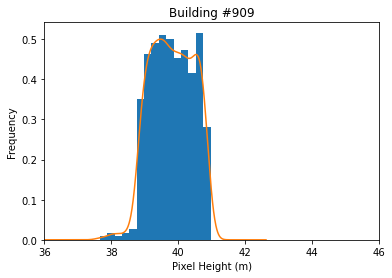

40.5400009155273 44.3199996948242 43.9000015258789 43.60182805215159


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


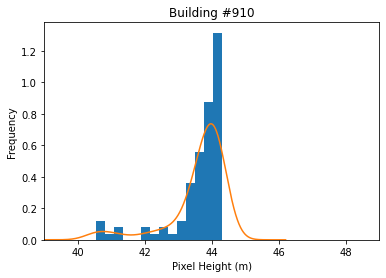

36.4199981689453 41.5900001525879 39.8400001525879 39.86677916357122


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


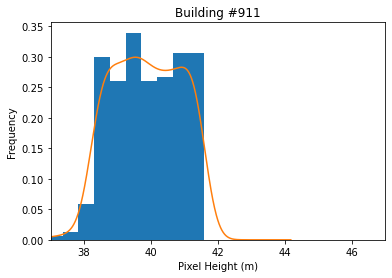

39.7999992370606 45.8800010681152 44.1199989318848 44.01163163436087


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


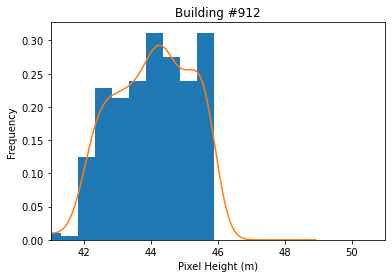

24.7199993133545 29.7199993133545 27.8799991607666 27.91265397109217


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


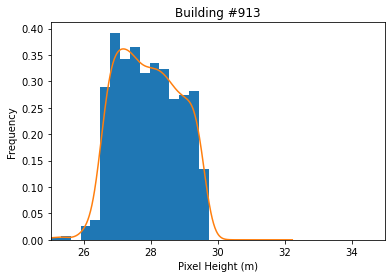

28.0499992370606 40.3800010681152 30.9699993133545 31.250890427260472


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


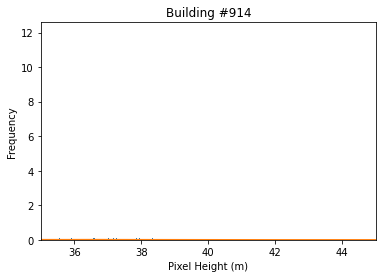

44.3800010681152 46.9500007629395 46.4099998474121 46.3320431589653


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


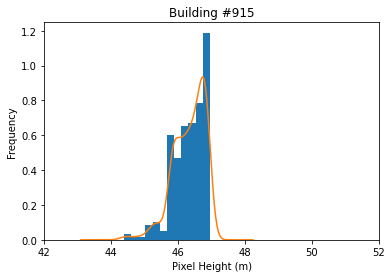

24.8799991607666 29.6399993896484 27.954999923706048 27.699714197431298


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


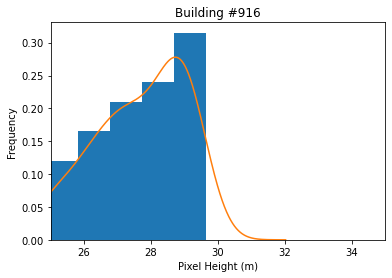

45.7999992370606 51.689998626709 48.0400009155274 48.019316823477986


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


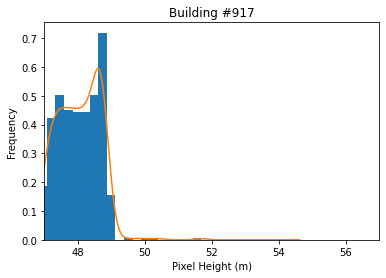

25.3199996948242 28.3199996948242 26.9949998855591 26.832215630047695


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


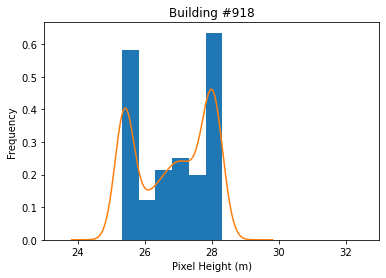

36.1500015258789 38.4000015258789 37.7700004577637 37.72069038951848


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


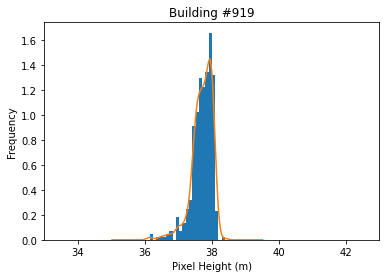

29.2999992370606 30.4400005340576 30.2399997711182 30.21321741187055


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


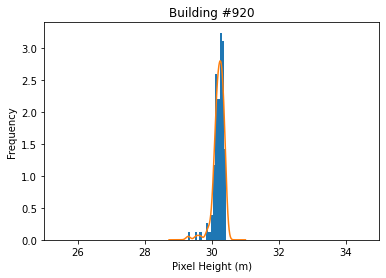

21.4300003051758 28.6100006103516 27.3450002670288 26.94436171105568


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


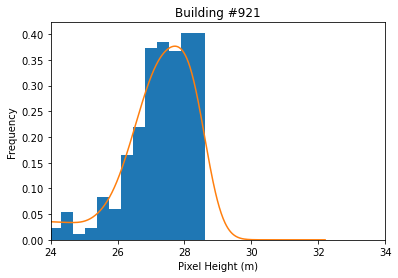

36.9500007629395 40.4500007629395 39.3649997711182 39.33826095643251


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


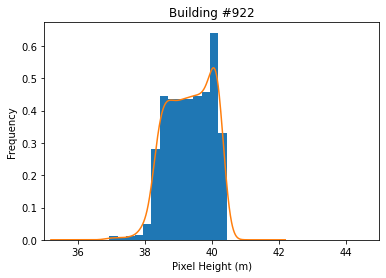

36.7599983215332 38.1500015258789 37.5900001525879 37.57621010069999


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


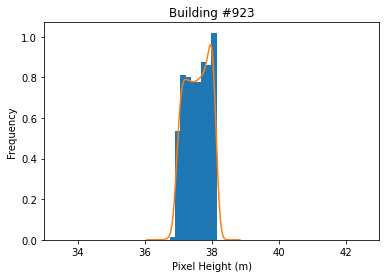

32.3899993896484 38.3800010681152 35.42499923706055 35.703301807619496


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


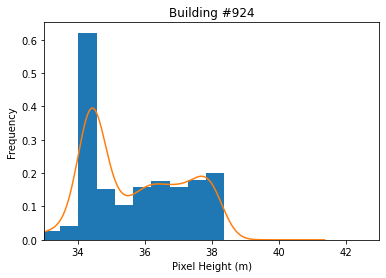

0.0 36.2999992370606 34.4500007629395 23.18893131226984


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


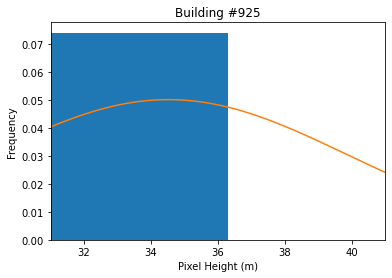

29.5499992370605 32.5900001525879 32.3899993896484 32.25734425778211


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


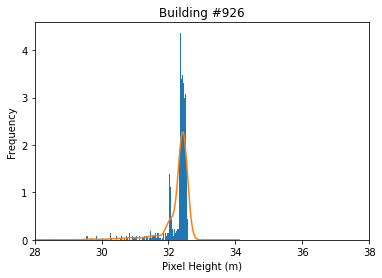

36.9599990844727 40.1399993896484 38.8199996948242 38.84928176989461


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


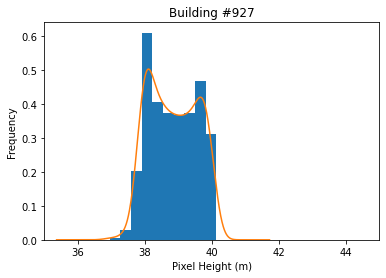

25.0499992370606 32.7799987792969 29.58500003814695 29.84829739044453


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


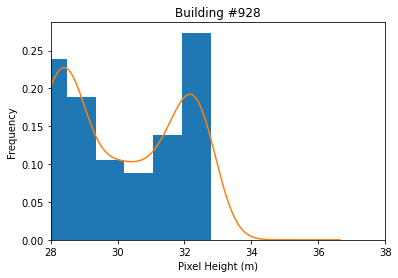

25.7999992370605 28.8899993896484 27.0799999237061 27.18100489588345


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


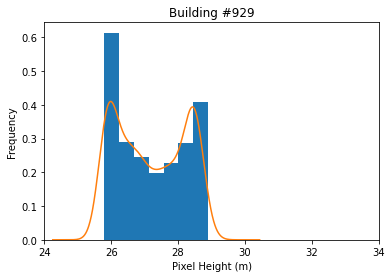

30.7399997711182 40.1800003051758 38.2599983215332 38.000198186566266


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


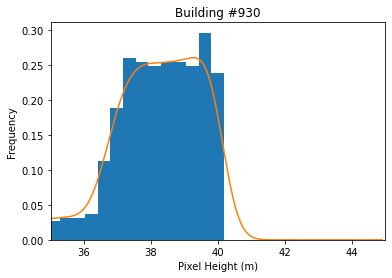

50.1399993896484 53.5999984741211 53.3300018310547 53.08894324884182


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


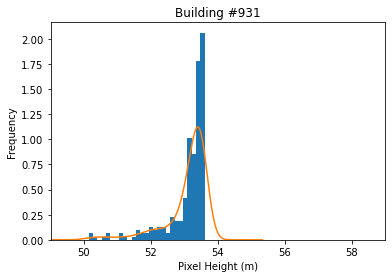

25.2600002288818 27.2399997711182 27.0599994659424 26.82457362034524


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


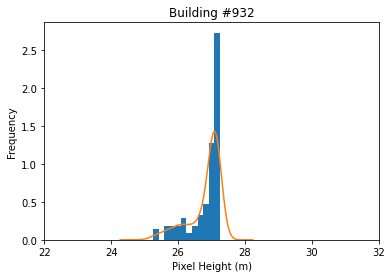

24.7999992370606 31.9899997711182 30.7099990844727 30.605130333471077


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


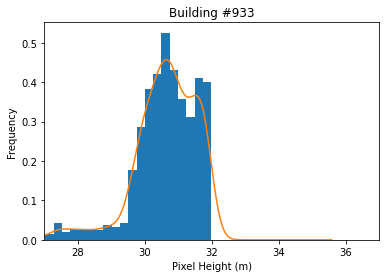

25.3299999237061 29.0200004577637 28.134999275207498 28.080073524923893


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


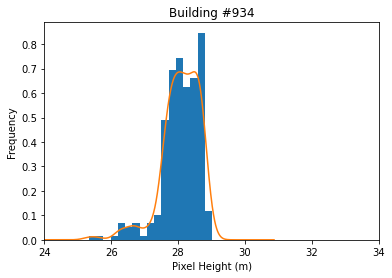

41.8800010681152 49.3800010681152 46.3699989318848 46.249057923503514


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


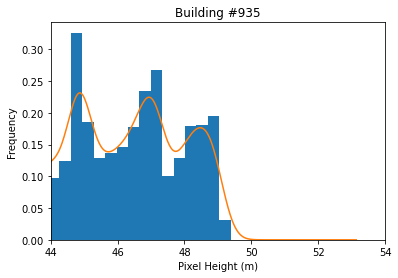

39.7700004577637 44.2599983215332 42.6399993896484 42.55336449270414


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


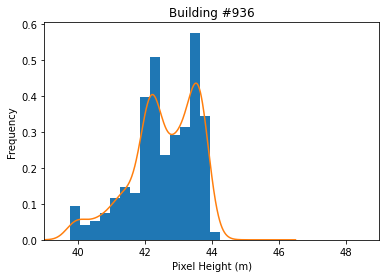

48.0499992370606 55.9300003051758 50.060001373291 50.084495334450274


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


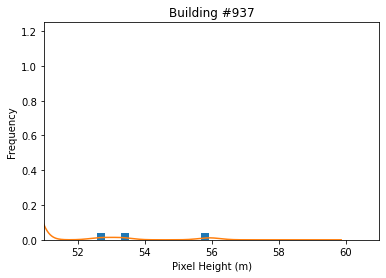

28.3400001525879 36.7000007629395 34.55000114440915 33.772408375565306


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


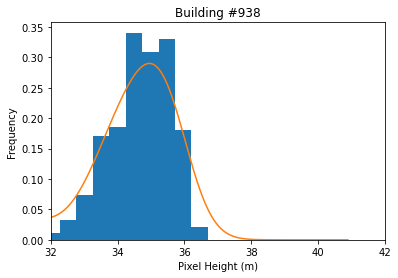

23.6299991607666 28.7399997711182 27.2199993133545 27.076593956224855


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


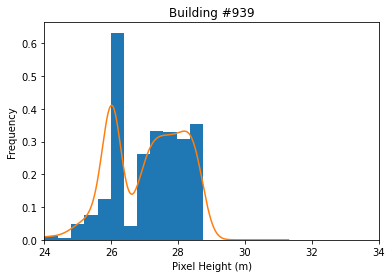

40.1800003051758 48.75 41.7450008392334 41.8319749546051


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


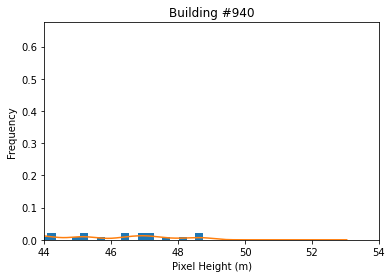

27.7199993133545 32.9199981689453 31.2600002288818 31.232757826945466


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


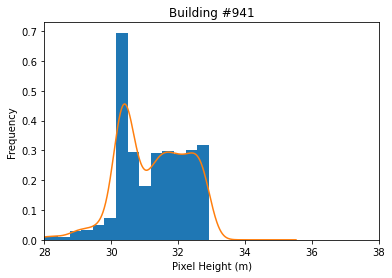

25.3799991607666 29.3899993896484 26.0699996948242 26.603329394291762


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


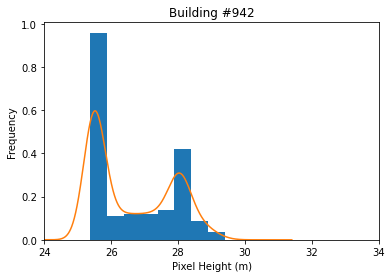

35.939998626709 40.5299987792969 39.5699996948242 39.507804306429534


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


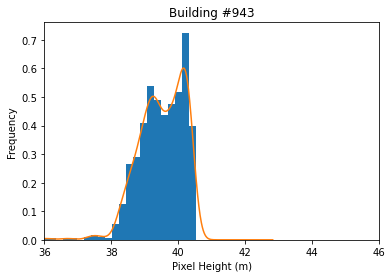

27.5 31.3700008392334 29.7800006866455 29.5286335737809


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


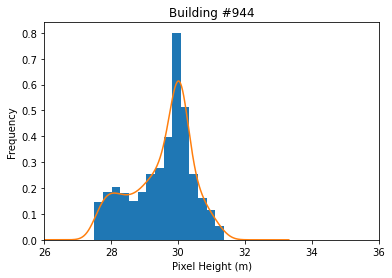

35.9199981689453 37.6199989318848 37.295000076293945 37.22272713401101


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


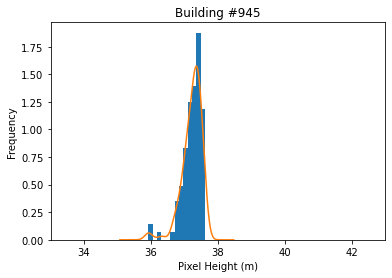

39.1100006103516 43.6500015258789 42.3699989318848 42.32759579382707


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


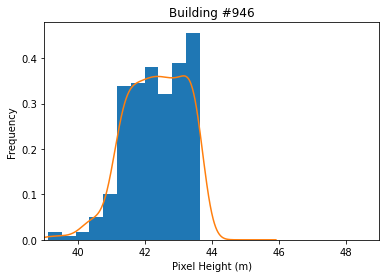

43.7999992370605 61.3699989318848 48.8800010681152 48.54150179628924


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


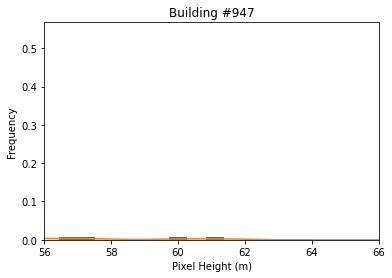

18.2299995422363 24.7099990844727 22.1100006103516 22.013974564253626


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


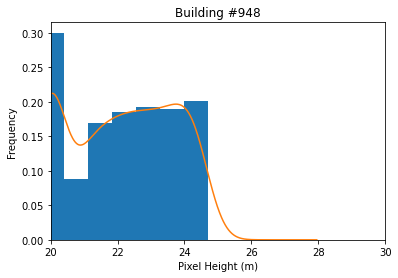

26.1399993896484 28.9799995422363 26.9200000762939 26.855211257934574


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


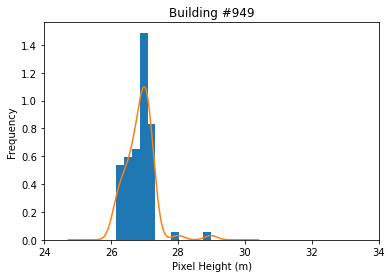

35.1800003051758 40.0900001525879 39.1300010681152 38.3638009809261


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


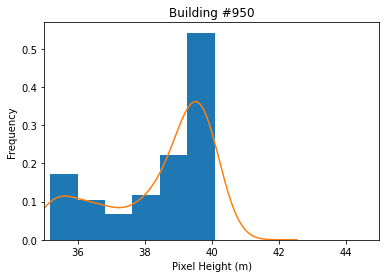

29.1599998474121 36.0699996948242 34.1800003051758 34.07185912871025


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


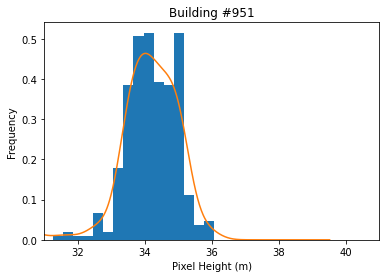

30.9099998474121 35.689998626709 33.75 33.76295705842649


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


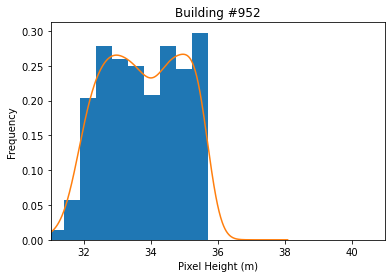

33.4700012207031 39.5499992370605 38.5499992370606 38.43309365897916


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


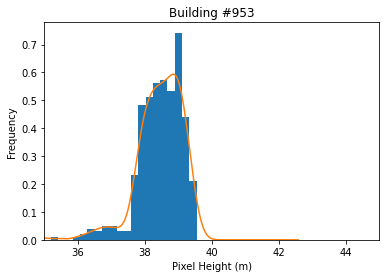

15.3500003814697 22.5900001525879 21.5649995803833 21.49044871330262


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


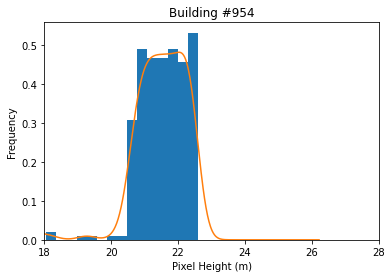

37.2900009155273 40.689998626709 39.7849998474121 39.66204539645802


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


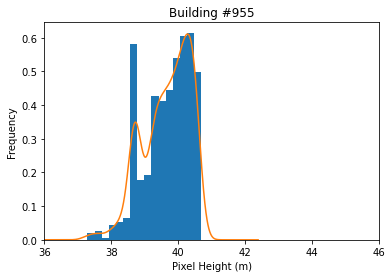

32.0299987792969 36.5200004577637 36.1699981689453 36.05172804057092


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


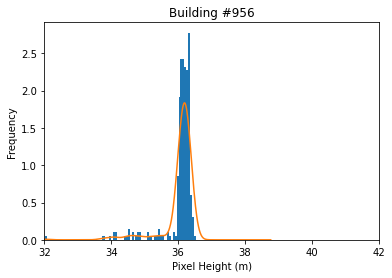

26.5300006866455 37.25 32.2900009155273 32.03910818588575


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


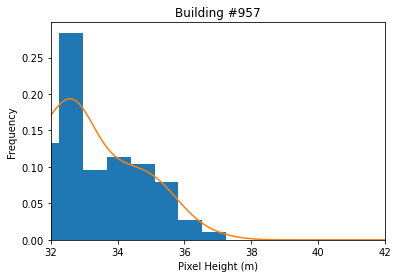

25.0 31.1599998474121 28.1900005340576 27.959607615340488


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


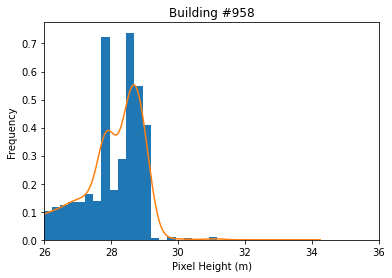

35.7799987792969 53.2200012207031 50.560001373291 50.180424236306514


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


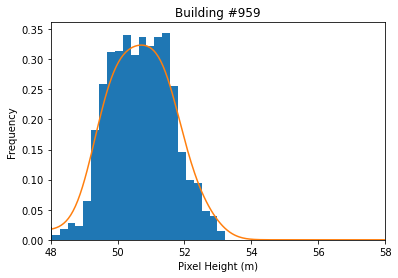

34.8899993896484 37.0699996948242 36.7549991607666 36.68272717793783


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


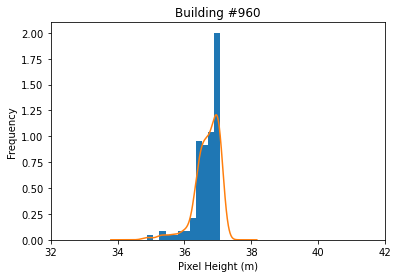

39.3199996948242 41.5699996948242 40.3499984741211 40.4044576189692


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


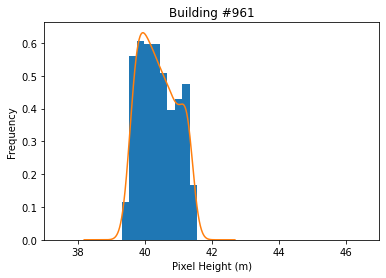

25.8999996185303 33.7799987792969 29.5300006866455 29.55906740494961


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


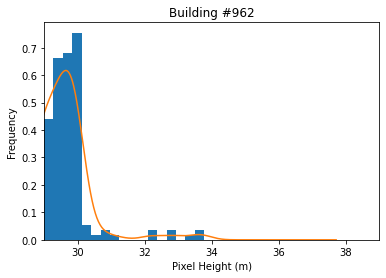

39.439998626709 43.5800018310547 42.7700004577637 42.62022224305168


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


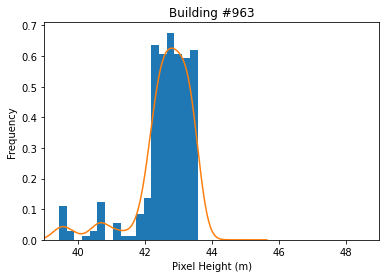

40.1500015258789 47.0699996948242 45.0900001525879 44.968097630942744


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


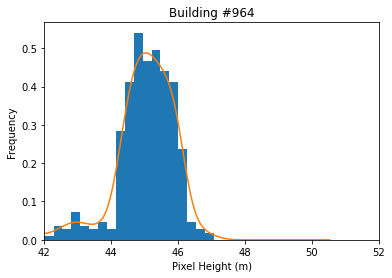

0.0 46.0499992370606 45.125 36.4868029768139


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


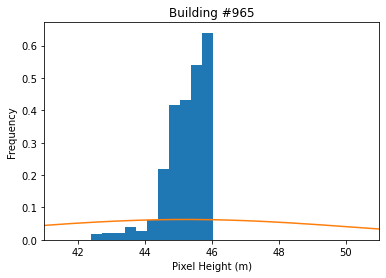

27.0699996948242 32.0499992370605 30.8899993896484 30.797347237442857


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


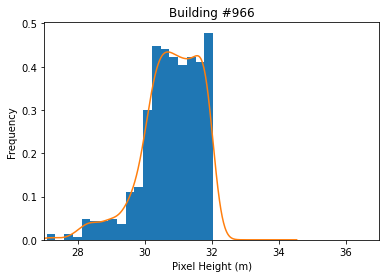

36.6199989318848 43.1699981689453 41.9700012207031 41.568670340775846


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


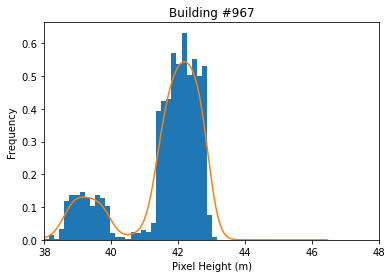

46.1599998474121 50.7400016784668 49.67000007629395 49.355400110880545


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


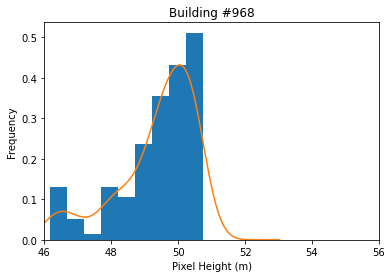

31.6000003814697 37.5900001525879 37.2700004577637 36.987734710313994


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


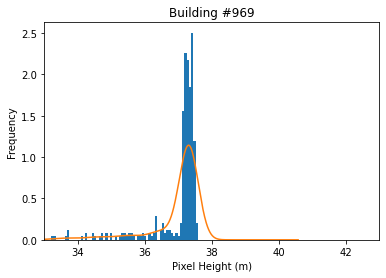

30.3799991607666 32.5099983215332 31.9300003051758 31.905070354121392


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


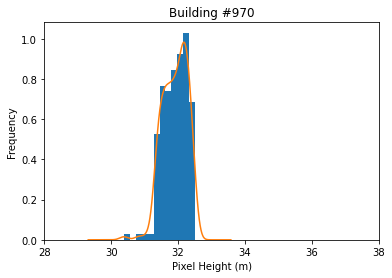

35.9599990844727 39.7599983215332 38.689998626709 38.764745316594286


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


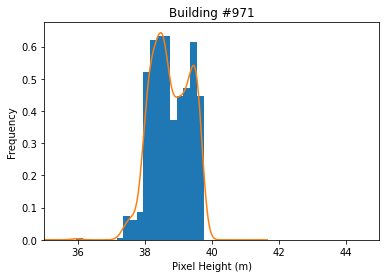

36.2999992370606 40.7799987792969 39.4199981689453 39.33447537722287


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


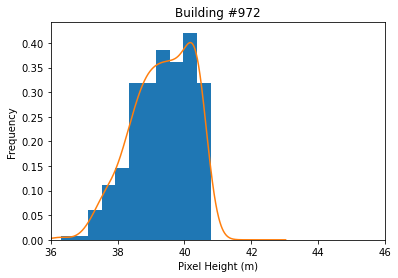

36.5800018310547 40.3400001525879 39.560001373291 39.081577335085186


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


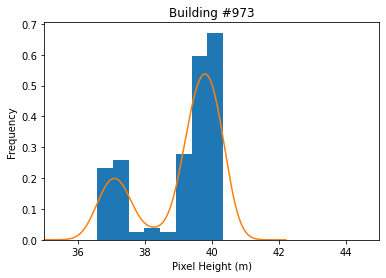

44.4599990844727 52.1300010681152 50.6399993896484 49.736632754307095


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


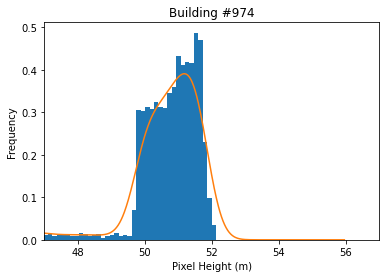

29.8400001525879 36.3899993896484 35.4099998474121 35.00197681900143


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


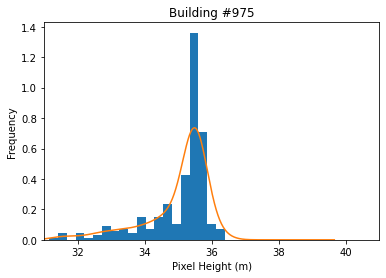

40.3800010681152 45.7299995422363 43.9000015258789 43.79962064127935


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


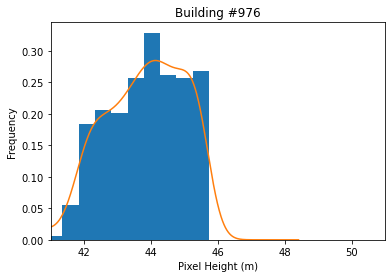

35.8300018310547 44.0499992370606 43.25 42.995926785082624


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


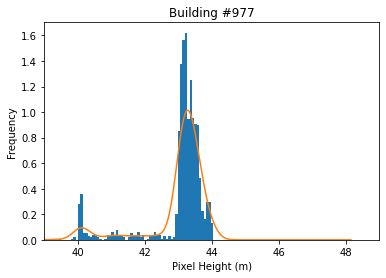

32.0900001525879 34.1199989318848 33.7400016784668 33.61255678263578


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


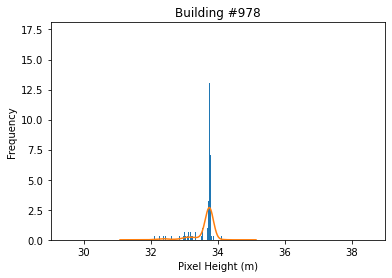

51.060001373291 51.9700012207031 51.5699996948242 51.55181821712779


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


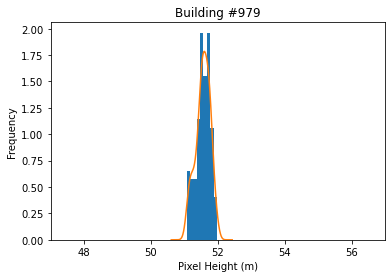

47.2700004577637 58.6100006103516 49.9950008392334 50.17942787284284


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


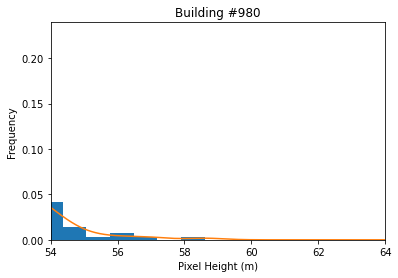

39.8499984741211 44.4099998474121 43.2799987792969 43.03896868514312


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


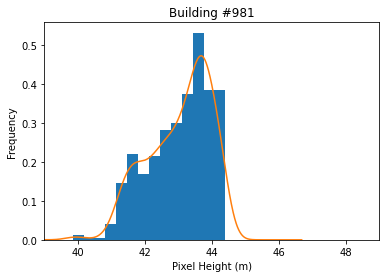

35.4099998474121 38.560001373291 38.2099990844727 38.060372481031884


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


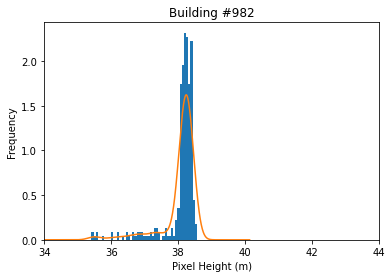

37.0400009155273 38.4300003051758 38.0200004577637 38.04370343243635


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


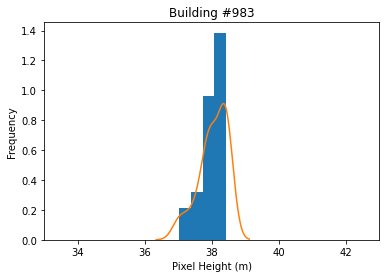

38.6199989318848 41.7099990844727 40.9799995422363 40.89606852267224


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


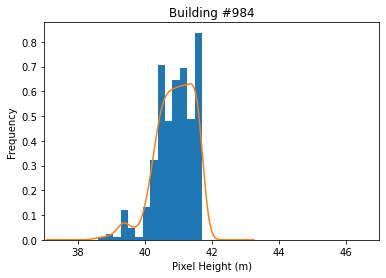

36.1500015258789 42.1500015258789 41.3449993133545 41.1149358015794


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


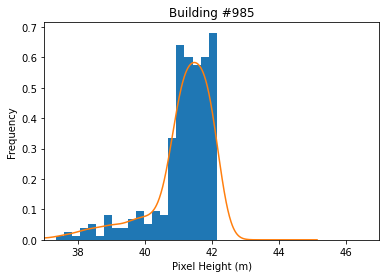

25.3299999237061 32.0 29.5900001525879 29.33681295980758


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


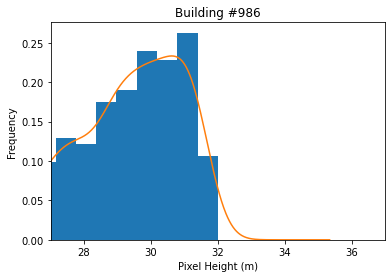

26.5200004577637 29.8199996948242 29.5300006866455 29.127300694605694


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


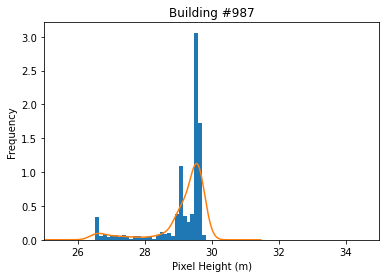

29.8700008392334 56.560001373291 53.8899993896484 53.50637483657598


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


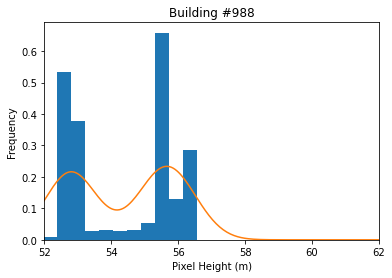

25.9799995422363 30.9599990844727 29.6700000762939 29.53138804510941


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


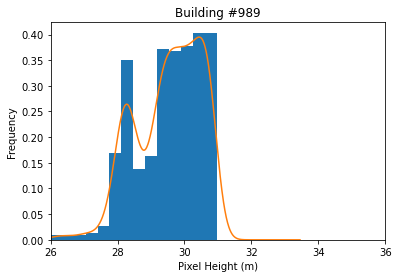

28.1599998474121 32.939998626709 31.6800003051758 31.630392936451734


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


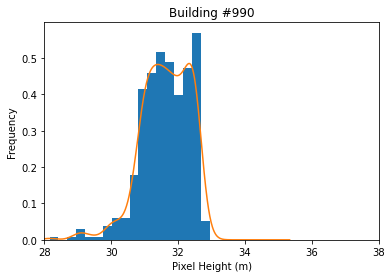

45.7400016784668 48.3600006103516 47.9000015258789 47.70649136995014


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


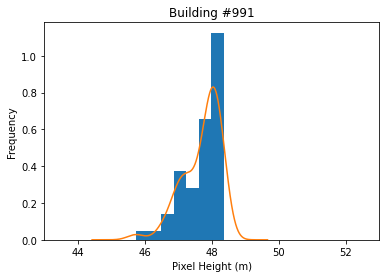

23.2999992370605 29.7199993133545 28.1200008392334 27.68544364947495


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


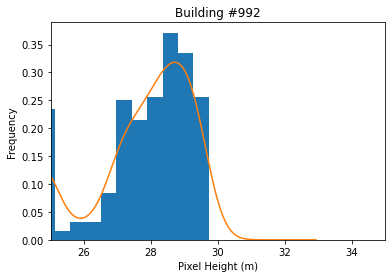

34.2099990844727 38.7700004577637 36.9799995422363 36.97956051678264


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


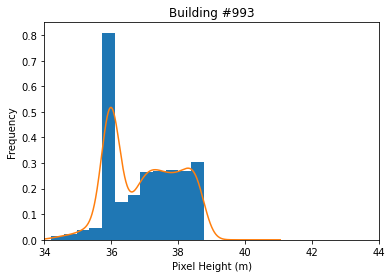

49.6100006103516 54.0099983215332 52.4300003051758 52.02072868051455


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


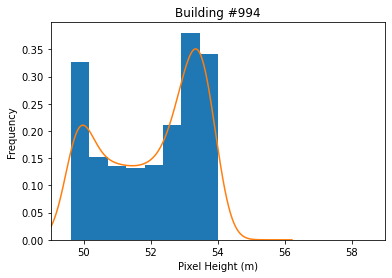

32.439998626709 43.0299987792969 39.9700012207031 39.60480218405252


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


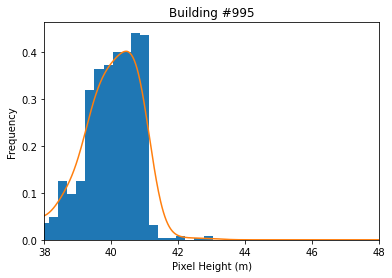

28.5499992370606 33.9099998474121 32.8899993896484 32.770237318135926


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


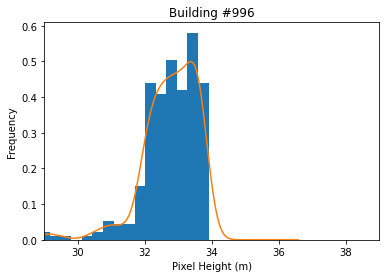

34.4000015258789 37.0 36.7799987792969 36.66660923793398


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


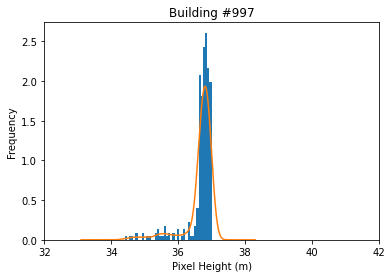

32.1599998474121 40.2599983215332 35.2000007629395 34.794331147637166


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


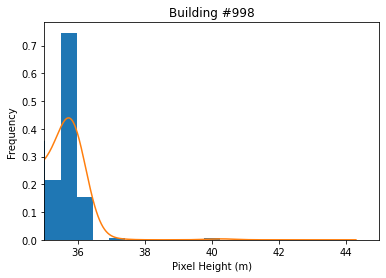

24.7099990844727 30.5400009155273 27.6299991607666 27.40084092740231


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


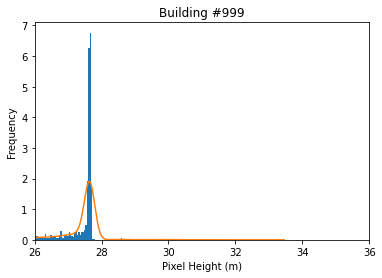

29.1100006103516 30.25 29.9300003051758 29.938148121774937


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\scipy\stats\stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


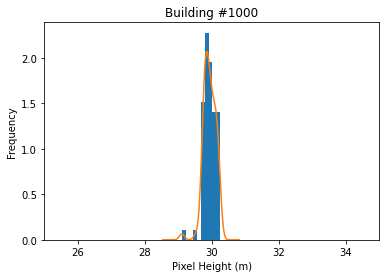

In [6]:
i = 0
for file in os.listdir(input_dsm_pixel):
    if i == 0:
        heightsPixels = pd.read_csv(os.path.join(input_dsm_pixel, file))
        uniqueID = heightsPixels['ID'].unique().tolist()
        j = 0
        for ID in uniqueID:
            if j < 2:
                plot_hist(ID, heightsPixels)
                #j += 1
        i = 1

#### Add other buildings info such as year of construction and areas as in Lantmätriet tables are added

#### Add NYKO3 id

In [52]:
buildings = gpd.read_file(final_buildings + '.shp')
buildings.drop(columns = 'NYKO3', inplace = True)

nyko3 = gpd.read_file(os.path.join(stad_source, 'NYKO3.shp'))
nyko3 = nyko3.loc[:, ['NYKO3', 'NAMN', 'Shape_Leng', 'Shape_Area', 'geometry']]
nyko3 = nyko3.to_crs('epsg:3006')

centroids = buildings.copy()
centroids.loc[:, 'geometry'] = buildings.loc[:'geometry'].centroid
centroids_in_nyko = gpd.sjoin(centroids, nyko3, op='within', how = 'left')

centroids_in_nyko['geometry'] = buildings['geometry']
columns_to_keep = list(buildings) + ['NYKO3']
buildings = centroids_in_nyko[columns_to_keep]
buildings['NYKO3'] = buildings['NYKO3'].astype(str)

# save file
buildings.to_file(final_buildings + '.shp')
buildings.to_excel(final_buildings + '.xlsx')
buildings = buildings.to_crs(epsg=4326)
buildings.to_file(final_buildings + '.geojson', driver='GeoJSON')

C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Check for duplicated records and keep only one

In [25]:
# check if any record is duplicated; returns all rows 
check_duplication(buildings, drop = False, inplace = True, ignore_index = True)   

No duplications


In [26]:
check_duplication(buildings, column = 'BuildingID')  

# Since there are duplicated buildingID, a new one will be created.
buildings['BuildingID'] = range(1, 1 + len(buildings))
#buildings['BuildingID'] = buildings.index + 1
#buildings.drop(columns = 'BuildingID', inplace = True)
check_duplication(buildings, column = 'BuildingID')  

590
No duplications


In [27]:
len(buildings)

66059

# Properties data

In [29]:
# copy data from data folder to ArcGIS connected folder
for files in os.listdir(source):
    name = os.path.splitext(os.path.basename(files))
    if (raw_properties in files)&(final_properties+name[1] not in os.listdir(destination)):
        shutil.copy(os.path.join(source, files), os.path.join(destination, files))
        
# rename the files in the destination folder
for files in os.listdir(destination):
    name = os.path.splitext(os.path.basename(files))
    if (raw_properties in files)&(final_properties+name[1] not in os.listdir(destination)):
        name = os.path.splitext(os.path.basename(files))
        os.rename(os.path.join(destination, files), os.path.join(destination, final_properties+name[1]))

In [30]:
# set the destination as the directory
os.chdir(destination)

In [31]:
#################### load data to process
properties = gpd.read_file(final_properties+'.shp')

In [32]:
# Drop entries with FNR = 0
# properties = properties[properties['FNR_FDS']!='0']
len(properties)

30164

In [33]:
check_duplication(properties, drop = False)   

No duplications


In [34]:
properties.columns

Index(['FNR_FDS', 'OBJEKT_ID', 'EXTERNID', 'DETALJTYP', 'KOMMUNKOD',
       'KOMMUNNAMN', 'TRAKT', 'BLOCKENHET', 'OMRNR', 'FASTIGHET', 'YTKVAL',
       'ADAT', 'OMRTYP', 'geometry'],
      dtype='object')

In [35]:
#### look for duplicates because of value 2 in YTKVAL where a property geometry can have a duplicate geometrically and 
#### in some fields
#properties.drop(columns=['FNR_FDS', 'OBJEKT_ID','FASTIGHET', 'OMRTYP','EXTERNID'], inplace = True)

#### Drop duplicated geometrical properties
# convert to wkb
properties["geometry"] = properties["geometry"].apply(lambda geom: geom.wkb)
check_duplication(properties, column = 'geometry', drop = False)   

80


C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\geopandas\geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


#### A number of properties have the same geometries; keep only the last updated one

In [36]:
properties = properties.sort_values(by = 'ADAT', ascending = False).drop_duplicates(["geometry"], keep = 'first')
# convert back to shapely geometry
properties["geometry"] = properties["geometry"].apply(lambda geom: shapely.wkb.loads(geom))

#### However, some records have the same FNR_FDS field, or OBJECKT_ID. That is because the file is property areas so a property may have many areas. Create new uuid

In [37]:
# delete/rename propeties shapefiles columns
# get properties attributes only
attributes_properties = attributes[attributes['File']=='riks']
updated_columns = []
drop_columns = []
for col in properties.columns:
    j = attributes_properties['Attribute'].tolist().index(col)
    updated_columns.append(attributes_properties['NewName'].tolist()[j])
drop_columns = [col for col in properties.columns if updated_columns[properties.columns.tolist().index(col)] == 'REMOVE']
updated_columns = [i for i in updated_columns if i != 'REMOVE']
properties.drop(drop_columns, inplace=True, axis=1)
properties.columns = updated_columns

In [38]:
# Since there are duplicated propertyID, a new one will be created.
#properties['PropertyID'] = properties.index + 1
properties['PropertyID'] = range(1, 1 + len(properties))

#### Add more info from Lantmäteriet table

In [50]:
# set the table source as the directory
os.chdir(table_source)
raw_info = 'VESHBYGG_43O.xlsx'
sheetname = 'Data'
# read file
info_table = pd.read_excel(raw_info, sheet_name = sheetname)
# use deep copy to reduce loading time of the data especially when debugging the code
info = copy.deepcopy(info_table)

In [51]:
info['FNR'] = info['FNR'].astype(str)

In [52]:
info = info[['FNR','YTABOST','YTABI','YTAVARDE','BYGGAR']]
info.columns = ['FNR','Boyta', 'Biarea', 'TotalArea', 'Year']

In [53]:
properties = properties.merge(info,how='left', on = 'FNR')

#### ADD NYKO3 id

In [58]:
# properties = gpd.read_file(final_properties + '.shp')
# properties.drop(columns = 'NYKO3', inplace = True)
# properties = properties.to_crs('epsg:3006')

nyko3 = gpd.read_file(os.path.join(stad_source, 'NYKO3.shp'))
nyko3 = nyko3.loc[:, ['NYKO3', 'NAMN', 'Shape_Leng', 'Shape_Area', 'geometry']]
nyko3 = nyko3.to_crs('epsg:3006')

centroids = properties.copy()
centroids.loc[:, 'geometry'] = properties.loc[:'geometry'].centroid
centroids_in_nyko = gpd.sjoin(centroids, nyko3, op='within', how = 'left')

centroids_in_nyko['geometry'] = properties['geometry']
columns_to_keep = list(properties) + ['NYKO3']
properties = centroids_in_nyko[columns_to_keep]
properties['NYKO3'] = properties['NYKO3'].astype(str)

# save file
# properties.to_file(final_properties + '.shp')
# properties.to_excel(final_properties + '.xlsx')
# properties = properties.to_crs(epsg=4326)
# properties.to_file(final_properties + '.geojson', driver='GeoJSON')

C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


# Addresses data

In [5]:
# set the table source as the directory
os.chdir(table_source)
#################### load data to process
addresses = gpd.read_file(final_addresses+'.shp')

In [6]:
# select only addresses within properties extent
polygon = extent.geometry[0]
addresses = addresses[addresses.within(polygon)]
len(addresses)

NameError: name 'extent' is not defined

In [7]:
addresses.columns

Index(['TableType', 'Street', 'AdrPlace', 'PostNb', 'PostOffice', 'Municipal',
       'TRAKT', 'BLOCK', 'ENHET', 'County', 'Commune', 'AdrAreaTp',
       'AddressID', 'PropertyID', 'BuildingID', 'Temp', 'geometry'],
      dtype='object')

In [43]:
# delete/rename addresses shapefiles columns
# get addresses attributes only
attributes_addresses = attributes[attributes['File']=='ADRPL_90A']
updated_columns = []
drop_columns = []
for col in addresses.columns:
    j = attributes_addresses['Attribute'].tolist().index(col)
    updated_columns.append(attributes_addresses['NewName'].tolist()[j])
drop_columns = [col for col in addresses.columns if updated_columns[addresses.columns.tolist().index(col)] == 'REMOVE']
updated_columns = [i for i in updated_columns if i != 'REMOVE']
addresses.drop(drop_columns, inplace=True, axis=1)
addresses.columns = updated_columns

C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
#### Drop duplicated geometrical addresses
# convert to wkb
addresses["geometry"] = addresses["geometry"].apply(lambda geom: geom.wkb)
check_duplication(addresses, drop = False)
# convert back to shapely geometry
addresses["geometry"] = addresses["geometry"].apply(lambda geom: shapely.wkb.loads(geom))

C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\geopandas\geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
C:\ProgramData\Anaconda3\envs\env_geo\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


No duplications


Add Block and Enhet fields from REGENH tables

In [45]:
os.chdir(table_source)
# add Block and Enhet 
blocks_pd = []
# get filenames
for s in ['A','B','C']:
    addresses_file = 'REGENH_01%s.xlsx'%s
    sheetname = 'Data'
    # read file
    addresses_pd = pd.read_excel(addresses_file, sheet_name = sheetname)
    blocks_pd.append(addresses_pd)
blocks = pd.concat(blocks_pd)

In [46]:
# delete/rename blocks shapefiles columns
# get blocks attributes only
attributes_blocks = attributes[attributes['File']=='REGENH_01']
updated_columns = []
drop_columns = []
for col in blocks.columns:
    j = attributes_blocks['Attribute'].tolist().index(col)
    updated_columns.append(attributes_blocks['NewName'].tolist()[j])
drop_columns = [col for col in blocks.columns if updated_columns[blocks.columns.tolist().index(col)] == 'REMOVE']
updated_columns = [i for i in updated_columns if i != 'REMOVE']
blocks.drop(drop_columns, inplace=True, axis=1)
blocks.columns = updated_columns

In [47]:
# merge addresses and blocks
addresses = addresses.merge(blocks,how='left', left_on='UUIDREGENH', right_on='UUID')
addresses.drop(columns = ['UUIDREGENH','UUID'], inplace = True)

In [48]:
# check coordinates systems and porject if necessary
print('Addresses CRS: ', addresses.crs)
#addresses  = addresses.to_crs('epsg:3006')
#print('Addresses CRS: ', addresses.crs)
#addressesShp.plot()

Addresses CRS:  epsg:3006


# Save files

### Save properties shapefile

In [4]:
# set the destination as the directory
os.chdir(destination)

In [50]:
properties.columns

Index(['FNR', 'PropertyID', 'Commune', 'Municipal', 'District', 'BlockEnhet',
       'AreaNb', 'YTKVAL', 'geometry'],
      dtype='object')

In [51]:
properties['FNR'] = properties['FNR'].astype(str)

In [52]:
properties.Commune.unique()

array(['1980', '0381', '1961', '1981', '1907'], dtype=object)

In [53]:
check_duplication(properties.loc[properties['Commune']=='1980', :], column = 'FNR', drop = False, 
                                     keep = 'first', inplace = True, ignore_index = True)

1678


In [81]:
# when done move it to Properties section above
buildings = gpd.read_file(final_buildings + ".shp")
properties_duplicated = properties.loc[properties['FNR'].duplicated(), :]
buildings = buildings.loc[buildings['PropertyID'].isin(properties_duplicated['PropertyID'].unique().tolist()), :]
buildings.to_file('testing.shp')

In [92]:
properties.loc[properties['PropertyID'] == 1752, :] #190100898

FNR  PropertyID Commune Municipal District BlockEnhet  AreaNb  \
13025  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13026  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13027  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13028  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13029  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
...          ...         ...     ...       ...      ...        ...     ...   
13213  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13214  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13215  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13216  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   
13217  190092994        1752    1980  VÄSTERÅS  ODLAREN          1     1.0   

       YTKVAL                                           geometry  Boyta  \
13025       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   42.0   
13026       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   42.0   
13027       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   38.0   
13028       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   40.0   
13029       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   40.0   
...       ...                                                ...    ...   
13213       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   45.0   
13214       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   38.0   
13215       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   40.0   
13216       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   40.0   
13217       1  POLYGON ((584121.054 6605048.282, 584111.082 6...   35.0   

       Biarea  TotalArea    Year  
13025     0.0       42.0  1985.0  
13026     0.0       42.0  1942.0  
13027     0.0       38.0  1952.0  
13028     0.0       40.0  1952.0  
13029     0.0       40.0  1952.0  
...       ...        ...     ...  
13213     0.0       45.0  1982.0  
13214     0.0       38.0  1982.0  
13215     0.0       40.0  1984.0  
13216     0.0       40.0  1965.0  
13217    10.0       37.0  1953.0  

[193 rows x 13 columns]

In [19]:
df_obj = properties.select_dtypes(['object'])
properties[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [21]:
# write the new properties shapefile
properties.to_file(final_properties + '.shp')
properties.to_excel(final_properties + '.xlsx')
properties = properties.to_crs(epsg=4326)
properties.to_file(final_properties + '.geojson', driver='GeoJSON')

### Save buildings shapefile

In [57]:
len(buildings)

66059

In [58]:
buildings.columns

Index(['BuildingID', 'Type', 'Name', 'Code', 'DSM_mean', 'DSM_max', 'DTM_mean',
       'DTM_max', 'geometry', 'Height', 'Purpose', 'Details', 'Area',
       'Volume'],
      dtype='object')

In [72]:
# convert type of id to float to make it possible to link addresses id to buildings id as database tables. Otherwise
# nan id won't be accepted
# buildings['BuildingID'] = buildings['BuildingID'].astype('float')

In [74]:
### add street address to buildings. 
# addressesInbuildings = gpd.sjoin(addresses, buildings, op='within')
# addressesInbuildings.sort_index(inplace=True)
# addressesInbuildings = addressesInbuildings.drop(['index_right'], axis=1)

# check_duplication(addressesInbuildings, column = 'BuildingID', drop = True, 
#                                      keep = 'first', inplace = True, ignore_index = True)

# # add street, zip code, number to buildings
# columns_to_add = ['Street','Municipal','PostNb','PostOffice', 'BuildingID']# 'AdrPlace','AdrPlaceTp','County','Commune','AdrAreaTp',
# buildingsWithaddresses = buildings.merge(addressesInbuildings[columns_to_add],how='left', left_on='BuildingID', right_on='BuildingID')

7603


In [36]:
properties = properties.to_crs(epsg=3006)

In [59]:
### because of limitation in the spatial join, we use the buildings centroids 
buildingsWithaddresses = buildings.copy()

buildings_centroids = buildingsWithaddresses.copy()
buildings_centroids['geometry'] =  buildings_centroids['geometry'].centroid

buildingsInproperties = gpd.sjoin(buildings_centroids, properties, op='within')
#buildingsInproperties.reset_index(inplace=True, drop=True)
buildingsInproperties.sort_index(inplace = True)
#buildingsInproperties['Commune'] = buildingsInproperties['Commune_left'] 
#buildingsInproperties['Municipal'] = buildingsInproperties['Municipal_left'] 
buildingsInproperties = buildingsInproperties.drop(['index_right'], axis=1)

<ipython-input-59-c95991c1e083>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3006
Right CRS: EPSG:4326

  buildingsInproperties = gpd.sjoin(buildings_centroids, properties, op='within')


In [60]:
# Keep all addresses columns with the building ID column
columns_to_keep = list(buildingsWithaddresses.columns) + ['PropertyID']
buildingsInproperties = buildingsInproperties[columns_to_keep]

In [61]:
buildingsInproperties.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - onshore and offshore.
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [62]:
buildingsInproperties["geometry"] = buildingsInproperties["geometry"].apply(lambda geom: geom.wkb)

In [63]:
buildingsInproperties["geometry"] = buildingsInproperties["geometry"].apply(lambda geom: geom.wkb)
check_duplication(buildingsInproperties, column = 'geometry', drop = False)
buildingsInproperties["geometry"] = buildingsInproperties["geometry"].apply(lambda geom: shapely.wkb.loads(geom))

No duplications


In [64]:
# return the polygon geomtry instead of centroids
buildingsInproperties['geometry'] = buildings['geometry']

In [65]:
len(buildingsInproperties)

66059

In [66]:
# save file
buildingsInproperties.to_file(final_buildings + '.shp')
buildingsInproperties.to_excel(final_buildings + '.xlsx')
buildingsInproperties = buildingsInproperties.to_crs(epsg=4326)
buildingsInproperties.to_file(final_buildings + '.geojson', driver='GeoJSON')
# save files to database
# write_to_postgis(buildingsInproperties, final_buildings, engine, primary_keys = ['BuildingID'], 
#                  foreign_keys = ['PropertyID'], reference_keys = ['PropertyID'], 
#                  reference_table_name = [final_properties])

In [15]:
buildingsInproperties= gpd.read_file(final_buildings + '.shp')

In [17]:
# save file
df_obj = buildingsInproperties.select_dtypes(['object'])
buildingsInproperties[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
#buildingsInproperties.drop(columns = 'FNR', inplace = True)
#buildingsInproperties.to_file(final_buildings + '.shp')
#buildingsInproperties.to_excel(final_buildings + '.xlsx')
buildingsInproperties = buildingsInproperties.to_crs(epsg=4326)
buildingsInproperties.to_file(final_buildings + '.geojson', driver='GeoJSON')

### Save addresses shapefile

In [58]:
buildings = gpd.read_file(final_buildings + '.shp')

In [17]:
# import pyproj
# pyproj.datadir.set_data_dir(r'C:\Users\akm03\.conda\envs\new_env_geo\share\proj')

In [26]:
addressesInproperties = gpd.sjoin(addresses, properties[['PropertyID','geometry']], op='within')

NameError: name 'properties' is not defined

In [81]:
# spatial join with properties to link each address to one. Some addresses are outside the building polygon and could
# be discarded 
addressesInproperties = gpd.sjoin(addresses, properties[['PropertyID','geometry']], op='within')
addressesInproperties.sort_index(inplace=True)
addressesInproperties = addressesInproperties.drop(['index_right'], axis=1)

In [28]:
addressesInproperties["geometry"] = addressesInproperties["geometry"].apply(lambda geom: geom.wkb)
check_duplication(addressesInproperties, column = 'geometry', drop = False)
# convert back to shapely geometry
addressesInproperties["geometry"] = addressesInproperties["geometry"].apply(lambda geom: shapely.wkb.loads(geom))

C:\Users\akm03\.conda\envs\new_env_geo\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


No duplications


In [45]:
# addressesInproperties = addressesInproperties.to_crs(epsg=4326)
# how = 'left' to keep all records even those who are not spatial joined.
addressesInbuildings = gpd.sjoin(addressesInproperties, buildings[['BuildingID','geometry']], 
                                 op='within', how='left')
addressesInbuildings.sort_index(inplace=True)
# addressesInbuildings = addressesInbuildings.drop(['index_right', 'FNR_x', 'FNR_y'], axis=1)

C:\Users\akm03\.conda\envs\new_env_geo\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [38]:
len(addressesInproperties), len(addresses), len(addressesInbuildings)

(36797, 36797, 37060)

In [39]:
check_duplication(addressesInbuildings, drop = True)

No duplications


In [46]:
addressesInbuildings['BuildingID'] = addressesInbuildings['BuildingID_right']
addressesInbuildings = addressesInbuildings.drop(['BuildingID_left', 'Temp', 'index_right', 'BuildingID_right'], axis=1)

In [47]:
addressesInbuildings.head()

TableType           Street AdrPlace   PostNb   PostOffice Municipal  \
0       90A  Simtuna Stångby       15  74971.0  Fjärdhundra   Simtuna   
1       90A        Kumla Vad      118  73398.0       Ransta     Kumla   
2       90A         Labacken      169  73398.0       Ransta     Kumla   
3       90A           Ransta      264  73398.0       Ransta     Kumla   
4       90A          Vallrum      106  73398.0       Ransta     Kumla   

       TRAKT BLOCK  ENHET  County  Commune  AdrAreaTp  \
0    STÅNGBY     2      8       3       81          3   
1  KUMLA-VAD     1     22      19       81          3   
2     RANSTA     2     27      19       81          3   
3     RANSTA     4      6      19       81          3   
4    VALLRUM     1      1      19       81          3   

                              AddressID  PropertyID  \
0  103409c0-37cc-48e3-a9fa-a24887248ff6       30021   
1  eda6d997-915b-498c-a81d-8e0347e3662d       22791   
2  3e8fc306-590e-48d0-a9ad-ed1e98ad0045       29972   
3  05ecf408-4d4f-4b0e-9997-023ccba36310       30050   
4  f6b89c2c-a1b1-4b3a-8506-7cc64c81f1b4        4757   

                         geometry  BuildingID  
0  POINT (601363.265 6627633.371)         NaN  
1  POINT (590552.375 6628375.250)     65581.0  
2  POINT (592378.193 6627721.835)     65497.0  
3  POINT (591471.118 6627664.815)     65573.0  
4  POINT (589859.178 6627118.347)     65904.0

In [56]:
addressesInbuildings = gpd.read_file(final_addresses + '.geojson')

In [48]:
addressesInbuildings = addressesInbuildings.rename(columns = {'address_id':'AddressID'})
addressesInbuildings = addressesInbuildings[['TableType','Street', 'AdrPlace', 'PostNb', 'PostOffice',
                                             'Municipal', 'TRAKT', 'BLOCK', 'ENHET', 
                                              'County','Commune', 'AdrAreaTp', 
                                             'AddressID', 'PropertyID', 'BuildingID','geometry']]

In [49]:
addressesInbuildings['BuildingID'] = addressesInbuildings['BuildingID'].fillna(0).astype(int)
addressesInbuildings['PostNb'] = addressesInbuildings['PostNb'].astype(int)

In [51]:
addressesInbuildings = gpd.GeoDataFrame(addressesInbuildings, geometry=addressesInbuildings['geometry'])

In [61]:
# # write the new addresses shapefile
# addressesInbuildings = addressesInbuildings.to_crs(epsg=3006)
addressesInbuildings.to_file(final_addresses + '.shp')
addressesInbuildings.to_excel(final_addresses + '.xlsx')

addressesInbuildings = addressesInbuildings.to_crs(epsg=4326)
addressesInbuildings.to_file(final_addresses + '.geojson', driver='GeoJSON')
# save files to database
# write_to_postgis(addressesInbuildings, final_addresses, engine, primary_keys = ['AddressID'], 
#                  foreign_keys = ['BuildingID','PropertyID'], reference_keys = ['BuildingID','PropertyID'], 
#                  reference_table_name = [final_buildings, final_properties])

C:\Users\akm03\.conda\envs\new_env_geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
Exception ignored in: <function ZipFile.__del__ at 0x000001E9F5C37760>
Traceback (most recent call last):
  File "C:\Users\akm03\.conda\envs\new_env_geo\lib\zipfile.py", line 1808, in __del__
    self.close()
  File "C:\Users\akm03\.conda\envs\new_env_geo\lib\zipfile.py", line 1825, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
